# AutoEncoder Wrapper

This notebook implements a flexible wrapper class for autoencoder experiments, providing:

1. A unified interface for working with different autoencoder architectures
2. Flexible parameter handling for dataset paths, model directories, etc.
3. Configuration options for easily switching between:
   - Different dataset directories
   - Various model architectures
   - Hyperparameter settings
   - Output/results directories
4. Separation of concerns between data handling, model definition, training, and evaluation

## Examples in this Notebook

This notebook includes several examples demonstrating how to use the AutoEncoder wrapper:

1. **Example 1:** Running a Single Model Experiment  
   Demonstrates training a single model with specific architecture and latent dimensions
   
2. **Example 2:** Running Multiple Architecture and Latent Dimension Study  
   Shows how to run a study comparing multiple architectures across different latent dimensions
   
3. **Example 3:** Loading and Analyzing Saved Model Results  
   Demonstrates loading and analyzing models saved from previous experiments
   
4. **Example 4:** Using a Custom Model Architecture  
   Explains how to define and use a custom model architecture with the experiment system
   
5. **Example 5:** Creating a Multi-Architecture Manager  
   Shows how to set up a manager for multiple architectures with advanced configuration
   
6. **Example 6:** Comparing Different Datasets with Same Architecture  
   Demonstrates using the same architecture on different datasets to compare their latent space characteristics

Navigate to any example by searching for its title.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from PIL import Image, ImageDraw
import os
import time
import json
import glob
import random
from tqdm import tqdm
import pandas as pd
from datetime import datetime

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Matplotlib settings for better visualization
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

## Model Architectures

The wrapper supports multiple autoencoder architectures, each with different characteristics:

1. **SimpleLinearAutoencoder**: Basic linear autoencoder with 2 layers
2. **DeeperLinearAutoencoder**: Linear autoencoder with 4 layers
3. **ConvAutoencoder**: Convolutional autoencoder with 3 conv/deconv layers
4. **DeeperConvAutoencoder**: Advanced convolutional autoencoder with 4 conv/deconv layers and larger kernels

In [2]:
# ==============================================
# MODEL DEFINITIONS - Supported architectures
# ==============================================

class SimpleLinearAutoencoder(nn.Module):
    def __init__(self, input_size=64*64, latent_dim=10):
        super(SimpleLinearAutoencoder, self).__init__()
        # Encoder (simple linear layers)
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        
        # Decoder (simple linear layers)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_size),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 64, 64))  # Reshape back to image dimensions
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


class DeeperLinearAutoencoder(nn.Module):
    def __init__(self, input_size=64*64, latent_dim=10):
        super(DeeperLinearAutoencoder, self).__init__()
        # Encoder with more layers
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        
        # Decoder with more layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_size),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 64, 64))
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


class ConvAutoencoder(nn.Module):
    def __init__(self, input_channels=1, latent_dim=10):
        super(ConvAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # Second convolutional layer
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # Third convolutional layer
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        
        # Calculate the size of the flattened features after convolutions
        # For 64x64 input with 3 stride-2 convs: 64 -> 32 -> 16 -> 8
        # So the flattened size is 64 channels * 8 * 8 = 4096
        self.flatten_size = 64 * 8 * 8
        
        # Latent space mapping
        self.fc_encoder = nn.Linear(self.flatten_size, latent_dim)
        self.fc_decoder = nn.Linear(latent_dim, self.flatten_size)
        
        # Decoder
        self.decoder = nn.Sequential(
            # First transpose convolutional layer
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # Second transpose convolutional layer
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # Third transpose convolutional layer
            nn.ConvTranspose2d(16, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Encode
        x = self.encoder(x)
        
        # Flatten and project to latent space
        x_flattened = x.view(x.size(0), -1)
        encoded = self.fc_encoder(x_flattened)
        
        # Project from latent space and reshape
        x_projected = self.fc_decoder(encoded)
        x_reshaped = x_projected.view(x.size(0), 64, 8, 8)
        
        # Decode
        decoded = self.decoder(x_reshaped)
        
        return encoded, decoded


class DeeperConvAutoencoder(nn.Module):
    """
    An improved convolutional autoencoder with:
    1. An additional conv/deconv layer for deeper feature learning
    2. More channels per layer (32, 64, 128, 256 vs 16, 32, 64)
    3. Mixture of 3x3 and 5x5 kernels to capture different spatial contexts
    """
    def __init__(self, input_channels=1, latent_dim=32):
        super(DeeperConvAutoencoder, self).__init__()
        
        # Encoder with larger filters and more channels
        self.encoder = nn.Sequential(
            # First convolutional layer with larger 5x5 kernel to capture more spatial context
            nn.Conv2d(input_channels, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            
            # Second convolutional layer
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            
            # Third convolutional layer
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            
            # Fourth convolutional layer (new)
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        
        # Calculate the size of the flattened features after convolutions
        # For 64x64 input with 4 stride-2 convs: 64 -> 32 -> 16 -> 8 -> 4
        # So the flattened size is 256 channels * 4 * 4 = 4096
        self.flatten_size = 256 * 4 * 4
        
        # Latent space mapping with an additional non-linearity
        self.fc_encoder = nn.Sequential(
            nn.Linear(self.flatten_size, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        
        self.fc_decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, self.flatten_size)
        )
        
        # Decoder with matching architecture
        self.decoder = nn.Sequential(
            # First transpose convolutional layer
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            
            # Second transpose convolutional layer
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            
            # Third transpose convolutional layer
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            
            # Fourth transpose convolutional layer with larger kernel to match the encoder
            nn.ConvTranspose2d(32, input_channels, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Encode
        x = self.encoder(x)
        
        # Flatten and project to latent space
        x_flattened = x.view(x.size(0), -1)
        encoded = self.fc_encoder(x_flattened)
        
        # Project from latent space and reshape
        x_projected = self.fc_decoder(encoded)
        x_reshaped = x_projected.view(x.size(0), 256, 4, 4)
        
        # Decode
        decoded = self.decoder(x_reshaped)
        
        return encoded, decoded


# Dictionary mapping architecture names to model classes
MODEL_ARCHITECTURES = {
    'simple_linear': SimpleLinearAutoencoder,
    'deeper_linear': DeeperLinearAutoencoder,
    'convolutional': ConvAutoencoder,
    'deeper_convolutional': DeeperConvAutoencoder
}

## Data Handling Components

These components handle dataset loading, preprocessing, and preparation for training.

In [3]:
# ==============================================
# DATA GENERATION - For creating synthetic datasets
# ==============================================

def generate_layered_dataset(
    output_dir='layered_geologic_patterns_dataset',
    num_samples_per_class=500,
    image_size=64,
    force_regenerate=False
):
    """
    Generate a dataset of synthetic images with two distinct layered pattern classes:
    1. Consistent layers with moderate orientation and thickness
    2. Highly variable layers with perpendicular orientation and extreme thickness variations
    """
    # Check if dataset already exists
    info_path = os.path.join(output_dir, 'dataset_info.npy')
    if os.path.exists(output_dir) and os.path.exists(info_path) and not force_regenerate:
        print(f"Loading existing dataset from {info_path}")
        try:
            dataset_info = np.load(info_path, allow_pickle=True).item()
            print(f"Successfully loaded dataset with {len(dataset_info['filenames'])} images.")
            return dataset_info
        except Exception as e:
            print(f"Error loading existing dataset: {e}")
            if not force_regenerate:
                print("Set force_regenerate=True to create a new dataset.")
                return None

    # Create output directory structure
    try:
        os.makedirs(output_dir, exist_ok=True)
    except Exception as e:
        print(f"Error creating output directory: {e}")
        return None

    # Define pattern classes and create their directories
    pattern_classes = ['consistent_layers', 'variable_layers']
    for pattern_type in pattern_classes:
        try:
            os.makedirs(os.path.join(output_dir, pattern_type), exist_ok=True)
        except Exception as e:
            print(f"Error creating directory for {pattern_type}: {e}")
            return None

    # Dictionary to store file paths and labels
    dataset_info = {
        'filenames': [],
        'labels': [],
        'label_names': pattern_classes,
        'params': {
            'image_size': image_size,
            'num_samples_per_class': num_samples_per_class
        }
    }

    # Generate images for each pattern class
    for class_idx, pattern_type in enumerate(pattern_classes):
        class_dir = os.path.join(output_dir, pattern_type)
        print(f"Generating {num_samples_per_class} '{pattern_type}' images...")

        for i in tqdm(range(num_samples_per_class)):
            # Create a blank white image
            img = Image.new('L', (image_size, image_size), color=255)
            draw = ImageDraw.Draw(img)

            if pattern_type == 'consistent_layers':
                # Consistent layers: moderate orientation and thickness
                angle_deg = random.uniform(30, 60)
                num_layers = random.randint(5, 8)
                base_thickness = random.randint(max(1, image_size // 15), max(3, image_size // 10))
            else:  # 'variable_layers'
                # Highly variable layers: perpendicular orientation
                angle_deg = random.uniform(120, 150)
                num_layers = random.randint(3, 15)
                base_thickness = random.randint(1, max(5, image_size // 5))

            angle_rad = np.radians(angle_deg)
            current_pos = 0
            
            while current_pos < image_size * 1.5:  # Ensure coverage even for diagonal
                # Slight thickness variation within the same sample
                thickness = max(1, base_thickness + random.randint(-base_thickness//3, base_thickness//3))
                
                # Calculate line coords based on angle and current position offset
                offset_x = current_pos * np.sin(angle_rad)
                offset_y = -current_pos * np.cos(angle_rad)
                
                # Line endpoints extended beyond image boundaries
                x0 = offset_x - image_size * np.cos(angle_rad) * 2
                y0 = offset_y - image_size * np.sin(angle_rad) * 2
                x1 = offset_x + image_size * np.cos(angle_rad) * 2
                y1 = offset_y + image_size * np.sin(angle_rad) * 2
                
                # Draw layer: black lines on white background
                draw.line([(x0, y0), (x1, y1)], fill=0, width=thickness)
                
                # Move to next layer position
                gap_multiplier = 1.5 if pattern_type == 'variable_layers' else 1.0
                gap = random.randint(max(1, thickness // 2), int(thickness * gap_multiplier))
                current_pos += thickness + gap

            # Save the image
            filename = os.path.join(class_dir, f"{pattern_type}_{i:05d}.png")
            try:
                img.save(filename)
                dataset_info['filenames'].append(filename)
                dataset_info['labels'].append(class_idx)
            except Exception as e:
                print(f"Error saving image {filename}: {e}")
                continue

    # Save dataset info
    try:
        np.save(info_path, dataset_info)
        print(f"\nLayered pattern dataset generation complete.")
        print(f"Total images generated: {len(dataset_info['filenames'])}")
        print(f"Images saved to {output_dir}")
        print(f"Dataset info saved to {info_path}")
    except Exception as e:
        print(f"Error saving dataset info: {e}")

    return dataset_info


def visualize_dataset_samples(dataset_info, samples_per_class=5, figure_size=(15, 8)):
    """
    Visualize random samples from each class in the dataset.
    
    Parameters:
    -----------
    dataset_info : dict
        Dictionary containing dataset information
    samples_per_class : int
        Number of samples to display per class
    figure_size : tuple
        Size of the figure to display
    """
    if not dataset_info.get('filenames'):
        print("Error: No filenames found in dataset_info.")
        return

    unique_labels = sorted(list(set(dataset_info.get('labels', []))))
    label_names = dataset_info.get('label_names', [f"Class {i}" for i in unique_labels])
    
    num_classes = len(unique_labels)
    plt.figure(figsize=figure_size)
    
    # For each class
    for i, label in enumerate(unique_labels):
        # Get indices of this class
        indices = [j for j, l in enumerate(dataset_info['labels']) if l == label]
        
        # Select random samples
        sample_indices = random.sample(indices, min(samples_per_class, len(indices)))
        
        # Plot each sample
        for j, idx in enumerate(sample_indices):
            img_path = dataset_info['filenames'][idx]
            img = Image.open(img_path)
            
            ax = plt.subplot(num_classes, samples_per_class, i * samples_per_class + j + 1)
            ax.imshow(img, cmap='gray')
            
            # Add class label only to the first image of each row
            if j == 0:
                ax.set_ylabel(label_names[label], fontsize=12, rotation=0, labelpad=40, ha='right', va='center')

            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis('off')

    plt.suptitle("Synthetic Layered Geologic Pattern Samples", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


def visualize_raw_data_tsne(dataset_path='layered_geologic_patterns_dataset/dataset_info.npy', random_state=42):
    """
    Create a t-SNE visualization of all raw image data (not latent representations).
    
    Args:
        dataset_path: Path to the dataset info file
        random_state: Random seed for reproducibility
    """
    print("Loading dataset...")
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset not found at {dataset_path}")
    
    # Load dataset info
    dataset_info = np.load(dataset_path, allow_pickle=True).item()
    
    # Get class names
    class_names = dataset_info.get('label_names', [f"Class {i}" for i in range(len(np.unique(dataset_info['labels'])))])
    print(f"Dataset contains {len(class_names)} classes: {class_names}")
    
    # Use all available samples
    total_samples = len(dataset_info['filenames'])
    sample_indices = np.arange(total_samples)
    
    print(f"Preparing all {total_samples} images for t-SNE...")
    
    # Load images and flatten them
    images = []
    labels = []
    
    for idx in sample_indices:
        # Load image
        img_path = dataset_info['filenames'][idx]
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        
        # Flatten the image to a 1D vector
        img_array = np.array(img).flatten() / 255.0  # Normalize to [0, 1]
        
        images.append(img_array)
        labels.append(dataset_info['labels'][idx])
    
    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)
    
    print(f"Running t-SNE on all {X.shape[0]} images of dimension {X.shape[1]}...")
    print("This might take a while...")
    
    # Apply t-SNE
    start_time = time.time()
    tsne = TSNE(n_components=2, perplexity=min(30, len(X)-1), n_iter=1000, random_state=random_state)
    X_tsne = tsne.fit_transform(X)
    elapsed = time.time() - start_time
    print(f"t-SNE completed in {elapsed:.2f} seconds")
    
    # Calculate silhouette score on t-SNE results
    silhouette = silhouette_score(X_tsne, y)
    print(f"Silhouette score on t-SNE embedding: {silhouette:.4f}")
    
    # Visualize the t-SNE embedding
    plt.figure(figsize=(12, 10))
    
    # Plot each class with a different color
    unique_labels = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        mask = y == label
        plt.scatter(
            X_tsne[mask, 0], X_tsne[mask, 1],
            c=[colors[i]],
            label=class_names[label],
            alpha=0.7,
            s=50,
            edgecolors='none'
        )
    
    # Add silhouette score to title
    title = f't-SNE Visualization of All Raw Image Data (n={len(X)})'
    title += f'\nSilhouette Score: {silhouette:.4f}'
    
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return X_tsne, y, silhouette

In [4]:
# ==============================================
# DATASET HANDLER - For loading and preprocessing datasets
# ==============================================

class ShapeDataset(Dataset):
    def __init__(self, dataset_info):
        """
        Initialize the dataset.
        
        Args:
            dataset_info: Either a path to the dataset directory or a dictionary
                         containing 'filenames' and 'labels'
        """
        # Check if dataset_info is a string (directory path) or a dictionary
        if isinstance(dataset_info, dict):
            # It's already a dictionary with filenames and labels
            self.filenames = dataset_info['filenames']
            self.labels = dataset_info['labels']
            self.from_directory = False
        else:
            # It's a directory path - load from there
            self.dataset_dir = dataset_info
            self.classes = self._get_classes()
            self.filenames = []
            self.labels = []
            self._load_from_directory()
            self.from_directory = True
    
    def _get_classes(self):
        """Get class folders in the dataset directory"""
        class_dirs = [d for d in os.listdir(self.dataset_dir) 
                if os.path.isdir(os.path.join(self.dataset_dir, d))]
        print(f"Found classes: {class_dirs}")
        return class_dirs
    
    def _load_from_directory(self):
        """Load all images from the directory structure"""
        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.dataset_dir, class_name)
            class_files = glob.glob(os.path.join(class_dir, '*.png'))
            
            for file in class_files:
                self.filenames.append(file)
                self.labels.append(i)
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        
        # Transform to tensor and normalize
        img = np.array(img)
        img = img / 255.0  # Normalize to [0, 1]
        img = torch.tensor(img).float().unsqueeze(0)  # Add channel dimension [1, H, W]
        
        return img, img, label  # Return (input, target, label)


# ==============================================
# DATA CONSISTENCY UTILITIES
# ==============================================

def seed_worker(worker_id):
    """
    Function to ensure DataLoader workers have deterministic behavior
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)


def create_and_save_consistent_split(dataset_info, test_ratio=0.2, seed=42, split_path="data_split.json"):
    """
    Create and save a consistent train/test split for reproducibility
    
    Args:
        dataset_info: Dataset information dict with filenames and labels
        test_ratio: Proportion of data to use for testing
        seed: Random seed for reproducibility
        split_path: Path to save the split indices
        
    Returns:
        Dictionary with train and test indices
    """
    # Set random seed for reproducibility
    np.random.seed(seed)
    
    total_samples = len(dataset_info['filenames'])
    indices = np.random.permutation(total_samples)
    split_idx = int(total_samples * (1 - test_ratio))
    
    train_indices = indices[:split_idx].tolist()
    test_indices = indices[split_idx:].tolist()
    
    # Create split info dictionary
    split_info = {
        'train_indices': train_indices,
        'test_indices': test_indices,
        'seed': seed,
        'test_ratio': test_ratio,
        'created_at': time.strftime("%Y-%m-%d %H:%M:%S")
    }
    
    # Save to file
    with open(split_path, 'w') as f:
        json.dump(split_info, f)
    
    print(f"Data split saved to {split_path}: {len(train_indices)} training samples, {len(test_indices)} test samples")
    return split_info


def load_or_create_data_split(dataset_info, split_path="data_split.json", test_ratio=0.2, seed=42):
    """
    Load an existing data split or create a new one if it doesn't exist
    
    Args:
        dataset_info: Dataset information with filenames and labels
        split_path: Path to the split file
        test_ratio: Proportion of data to use for testing
        seed: Random seed for reproducibility
        
    Returns:
        Dictionary with train and test indices
    """
    if os.path.exists(split_path):
        with open(split_path, 'r') as f:
            split_info = json.load(f)
        print(f"Loaded existing data split from {split_path}")
        return split_info
    else:
        return create_and_save_consistent_split(dataset_info, test_ratio, seed, split_path)


def get_train_test_data(dataset_info, split_info):
    """
    Create train and test dataset info based on split indices
    
    Args:
        dataset_info: Dataset information with filenames and labels
        split_info: Dictionary with train and test indices
        
    Returns:
        Tuple of (train_info, test_info) dictionaries
    """
    train_indices = split_info['train_indices']
    test_indices = split_info['test_indices']
    
    train_info = {
        'filenames': [dataset_info['filenames'][i] for i in train_indices],
        'labels': [dataset_info['labels'][i] for i in train_indices]
    }
    
    test_info = {
        'filenames': [dataset_info['filenames'][i] for i in test_indices],
        'labels': [dataset_info['labels'][i] for i in test_indices]
    }
    
    return train_info, test_info

## Visualization Utilities

These functions help visualize:
1. Training progress
2. Reconstruction quality
3. Latent space structure using t-SNE

In [5]:
# ==============================================
# VISUALIZATION FUNCTIONS
# ==============================================

def plot_with_labels(low_dim_embs, labels, class_names=None, title="t-SNE Visualization", ax=None):
    """
    Plot t-SNE data with color-coded labels on a given axis
    
    Args:
        low_dim_embs: Low-dimensional embeddings from t-SNE
        labels: Class labels for each point
        class_names: List of class names for the legend
        title: Plot title
        ax: Matplotlib axis to plot on (if None, creates a new figure)
    """
    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()
        
    unique_labels = np.unique(labels)
    # Use rainbow colormap for consistent visualization
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax.scatter(
            low_dim_embs[mask, 0], 
            low_dim_embs[mask, 1],
            c=[colors[i]],
            label=class_names[label] if class_names is not None else f'Class {label}',
            alpha=0.7
        )
    
    ax.legend()
    ax.set_title(title, fontsize=14)
    ax.grid(alpha=0.3)
    return ax


def visualize_reconstructions(model, test_data, test_labels, class_names=None, n_samples=10, device='cpu', view_indices=None):
    """Visualize original images and their reconstructions"""
    model.eval()
    
    if view_indices is not None:
        # Use the same indices as during training
        view_data = test_data[view_indices].to(device)
        view_labels = test_labels[view_indices] if test_labels is not None else None
    else:
        # Fallback to first n_samples
        n_samples = min(n_samples, len(test_data))
        view_data = test_data[:n_samples].to(device)
        view_labels = test_labels[:n_samples] if test_labels is not None else None
    
    with torch.no_grad():
        _, decoded_data = model(view_data)
    
    # Use a simple two-row layout: original images on top, reconstructions on bottom
    n_images = len(view_data)
    f, a = plt.subplots(2, n_images, figsize=(n_images * 2, 4))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    
    # Add a title to the figure
    plt.suptitle(f'Original (top) vs. Reconstructed (bottom)', fontsize=14)
    
    # Original images on top row
    for i in range(n_images):
        a[0][i].imshow(view_data[i, 0].cpu().numpy(), cmap='gray')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
        
        # If available, add small class labels
        if class_names is not None and view_labels is not None and i < len(view_labels):
            class_idx = view_labels[i].item()
            if i == 0:
                a[0][i].set_ylabel("Original", fontsize=10)
            a[0][i].set_title(class_names[class_idx], fontsize=8)
    
    # Reconstructed images on bottom row
    for i in range(n_images):
        a[1][i].imshow(decoded_data[i, 0].cpu().numpy(), cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
        if i == 0:
            a[1][i].set_ylabel("Reconstructed", fontsize=10)
    
    plt.tight_layout()
    plt.show()


def visualize_dual_reconstructions(model, train_data, train_labels, test_data, test_labels, 
                                 class_names=None, n_samples=5, device='cpu', view_indices=None):
    """
    Visualize reconstructions from both training and test data side by side
    
    Args:
        model: Trained autoencoder model
        train_data: Tensor of training data
        train_labels: Tensor of training labels
        test_data: Tensor of test data
        test_labels: Tensor of test labels
        class_names: List of class names for labels
        n_samples: Number of samples to show from each dataset
        device: Device to run model on
        view_indices: Specific indices to view (if None, uses first n_samples)
    """
    model.eval()
    
    # Process view indices or use defaults
    if view_indices is not None:
        train_view_indices = view_indices[:len(view_indices)//2]
        test_view_indices = view_indices[len(view_indices)//2:]
        
        train_view_data = train_data[train_view_indices].to(device)
        train_view_labels = train_labels[train_view_indices] if train_labels is not None else None
        
        test_view_data = test_data[test_view_indices].to(device)
        test_view_labels = test_labels[test_view_indices] if test_labels is not None else None
    else:
        # Use first n_samples from each dataset
        n_train = min(n_samples, len(train_data))
        n_test = min(n_samples, len(test_data))
        
        train_view_data = train_data[:n_train].to(device)
        train_view_labels = train_labels[:n_train] if train_labels is not None else None
        
        test_view_data = test_data[:n_test].to(device)
        test_view_labels = test_labels[:n_test] if test_labels is not None else None
    
    # Generate reconstructions
    with torch.no_grad():
        _, train_decoded = model(train_view_data)
        _, test_decoded = model(test_view_data)
    
    # Create figure with 4 rows: train original, train reconstructed, test original, test reconstructed
    n_train_images = len(train_view_data)
    n_test_images = len(test_view_data)
    max_images = max(n_train_images, n_test_images)
    
    # Create appropriate figure size
    fig_width = max_images * 2
    fig, axes = plt.subplots(4, max_images, figsize=(fig_width, 8))
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    
    # Add a title to the figure
    plt.suptitle(f'Train (top) vs. Test (bottom) Reconstructions', fontsize=14)
    
    # Train original images (row 0)
    for i in range(max_images):
        if i < n_train_images:
            axes[0][i].imshow(train_view_data[i, 0].cpu().numpy(), cmap='gray')
            
            # If available, add class labels as text below images
            if class_names is not None and train_view_labels is not None:
                class_idx = train_view_labels[i].item()
                class_text = class_names[class_idx] if class_idx < len(class_names) else f"Class {class_idx}"
                axes[0][i].text(32, 70, class_text, fontsize=8, ha="center")
        
        axes[0][i].set_xticks([])
        axes[0][i].set_yticks([])
        
        if i == 0:
            axes[0][i].set_ylabel("Train Original", fontsize=10)
    
    # Train reconstructed images (row 1)
    for i in range(max_images):
        if i < n_train_images:
            axes[1][i].imshow(train_decoded[i, 0].cpu().numpy(), cmap='gray')
        
        axes[1][i].set_xticks([])
        axes[1][i].set_yticks([])
        
        if i == 0:
            axes[1][i].set_ylabel("Train Recon", fontsize=10)
    
    # Test original images (row 2)
    for i in range(max_images):
        if i < n_test_images:
            axes[2][i].imshow(test_view_data[i, 0].cpu().numpy(), cmap='gray')
            
            # If available, add class labels as text below images
            if class_names is not None and test_view_labels is not None:
                class_idx = test_view_labels[i].item()
                class_text = class_names[class_idx] if class_idx < len(class_names) else f"Class {class_idx}"
                axes[2][i].text(32, 70, class_text, fontsize=8, ha="center")
        
        axes[2][i].set_xticks([])
        axes[2][i].set_yticks([])
        
        if i == 0:
            axes[2][i].set_ylabel("Test Original", fontsize=10)
    
    # Test reconstructed images (row 3)
    for i in range(max_images):
        if i < n_test_images:
            axes[3][i].imshow(test_decoded[i, 0].cpu().numpy(), cmap='gray')
        
        axes[3][i].set_xticks([])
        axes[3][i].set_yticks([])
        
        if i == 0:
            axes[3][i].set_ylabel("Test Recon", fontsize=10)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make space for the suptitle
    plt.show()


def visualize_latent_space(model, train_data, train_labels, test_data, test_labels, 
                           class_names=None, device='cpu', max_samples=5000, perplexity=30):
    """
    Generate and visualize t-SNE projection of the latent space with silhouette scores
    for both train and test data side by side
    """
    model.eval()
    with torch.no_grad():
        # Process training data
        encoded_train, _ = model(train_data.to(device))
        encoded_train = encoded_train.view(encoded_train.size(0), -1).detach().cpu().numpy()
        
        # Process test data
        encoded_test, _ = model(test_data.to(device))
        encoded_test = encoded_test.view(encoded_test.size(0), -1).detach().cpu().numpy()
    
    # Set up figure with two subplots for train and test data
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Process train data
    plot_only_train = min(max_samples, encoded_train.shape[0])
    tsne_train = TSNE(perplexity=perplexity, n_components=2, init='pca', max_iter=5000, random_state=42)
    low_dim_embs_train = tsne_train.fit_transform(encoded_train[:plot_only_train])
    train_labels_subset = train_labels.numpy()[:plot_only_train]
    
    # Calculate train silhouette score if there's more than one class
    train_title = "Train Data t-SNE"
    train_score = None
    if len(np.unique(train_labels_subset)) > 1:
        try:
            train_score = silhouette_score(low_dim_embs_train, train_labels_subset)
            print(f"Train t-SNE Silhouette Score: {train_score:.3f}")
            train_title = f"Train Data t-SNE (Silhouette: {train_score:.3f})"
        except Exception as e:
            print(f"Could not calculate train silhouette score: {e}")
    
    # Process test data
    plot_only_test = min(max_samples, encoded_test.shape[0])
    tsne_test = TSNE(perplexity=perplexity, n_components=2, init='pca', max_iter=5000, random_state=42)
    low_dim_embs_test = tsne_test.fit_transform(encoded_test[:plot_only_test])
    test_labels_subset = test_labels.numpy()[:plot_only_test]
    
    # Calculate test silhouette score if there's more than one class
    test_title = "Test Data t-SNE"
    test_score = None
    if len(np.unique(test_labels_subset)) > 1:
        try:
            test_score = silhouette_score(low_dim_embs_test, test_labels_subset)
            print(f"Test t-SNE Silhouette Score: {test_score:.3f}")
            test_title = f"Test Data t-SNE (Silhouette: {test_score:.3f})"
        except Exception as e:
            print(f"Could not calculate test silhouette score: {e}")
    
    # Plot both visualizations
    plot_with_labels(low_dim_embs_train, train_labels_subset, class_names, train_title, ax=ax1)
    plot_with_labels(low_dim_embs_test, test_labels_subset, class_names, test_title, ax=ax2)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'train': (low_dim_embs_train, train_labels_subset, train_score),
        'test': (low_dim_embs_test, test_labels_subset, test_score)
    }

## Core AutoEncoder Wrapper Class

This class manages the training and evaluation of different autoencoder architectures, with flexible configuration options for:
- Dataset loading and splitting
- Model selection and configuration
- Training parameters
- Evaluation and visualization methods
- Results storage and logging

In [6]:
# ==============================================
# CORE AUTOENCODER WRAPPER CLASS
# ==============================================

class AutoEncoderWrapper:
    """
    A flexible wrapper for training and evaluating autoencoder models on different datasets.
    
    This class provides a unified interface for:
    1. Dataset loading and preprocessing
    2. Model creation and configuration
    3. Training with customizable parameters
    4. Evaluation and visualization of results
    5. Saving and loading models and results
    """
    
    def __init__(self, config=None):
        """
        Initialize the AutoEncoderWrapper with configuration parameters
        
        Args:
            config: Dictionary with configuration parameters (if None, uses defaults)
        """
        # Set default configuration
        self.config = {
            # Dataset parameters
            'dataset_path': 'layered_geologic_patterns_dataset/dataset_info.npy',
            'data_split_path': 'data_split.json',
            'test_ratio': 0.2,
            'random_seed': 42,
            'force_new_split': False,
            
            # Model parameters
            'architecture': 'simple_linear',
            'latent_dim': 10,
            'input_size': 64*64,
            'input_channels': 1,
            
            # Training parameters
            'batch_size': 32,
            'epochs': 10,
            'learning_rate': 0.001,
            'weight_decay': 1e-5,
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',
            
            # Results parameters
            'output_dir': 'autoencoder_results',
            'experiment_name': None,
            'save_model': True,
            'visualization_interval': 500,
            'num_visualizations': 5,
            
            # Silhouette calculation options
            'calculate_train_silhouette': True,
            'calculate_test_silhouette': True,
        }
        
        # Update configuration with provided values
        if config is not None:
            self.config.update(config)
            
        # Initialize state variables
        self.model = None
        self.history = None
        self.dataset_info = None
        self.split_info = None
        self.train_info = None
        self.test_info = None
        self.train_loader = None
        self.test_data = None
        self.test_labels = None
        self.class_names = None
        
        # Create output directory if it doesn't exist
        if self.config['output_dir']:
            os.makedirs(self.config['output_dir'], exist_ok=True)
            
        # Set random seeds for reproducibility
        self._set_random_seeds()
        
        # Create experiment name if not provided
        if self.config['experiment_name'] is None:
            timestamp = time.strftime("%Y%m%d_%H%M%S")
            self.config['experiment_name'] = f"{self.config['architecture']}_{self.config['latent_dim']}d_{timestamp}"
    
    def _set_random_seeds(self):
        """Set random seeds for reproducibility"""
        random_seed = self.config['random_seed']
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)
        random.seed(random_seed)
    
    def load_dataset(self, dataset_path=None):
        """
        Load dataset from file or use the one in the configuration
        
        Args:
            dataset_path: Path to dataset info file (if None, uses config value)
            
        Returns:
            Dataset info dictionary
        """
        # Use provided path or config value
        if dataset_path is not None:
            self.config['dataset_path'] = dataset_path
        
        dataset_path = self.config['dataset_path']
        
        # Check if dataset path exists
        if not os.path.exists(dataset_path):
            raise FileNotFoundError(f"Dataset not found at {dataset_path}")
        
        # Load the dataset
        print(f"Loading dataset from {dataset_path}")
        self.dataset_info = np.load(dataset_path, allow_pickle=True).item()
        
        # Get class names
        self.class_names = self.dataset_info.get('label_names', 
                               [f"Class {i}" for i in range(len(np.unique(self.dataset_info['labels'])))])
        
        print(f"Loaded dataset with {len(self.dataset_info['filenames'])} samples")
        print(f"Classes: {self.class_names}")
        
        return self.dataset_info
    
    def create_data_split(self, data_split_path=None, force_new_split=None, test_ratio=None):
        """
        Create train/test split or load existing one
        
        Args:
            data_split_path: Path to save/load data split (if None, uses config value)
            force_new_split: Whether to force creation of a new split (if None, uses config value)
            test_ratio: Proportion of data for testing (if None, uses config value)
            
        Returns:
            Tuple of (train_info, test_info) dictionaries
        """
        # Use provided values or config values
        if data_split_path is not None:
            self.config['data_split_path'] = data_split_path
        
        if force_new_split is not None:
            self.config['force_new_split'] = force_new_split
            
        if test_ratio is not None:
            self.config['test_ratio'] = test_ratio
        
        data_split_path = self.config['data_split_path']
        force_new_split = self.config['force_new_split']
        test_ratio = self.config['test_ratio']
        
        # Check if dataset has been loaded
        if self.dataset_info is None:
            raise ValueError("Dataset must be loaded before creating a data split")
        
        # Create or load data split
        if force_new_split or not os.path.exists(data_split_path):
            print(f"Creating new data split with test ratio {test_ratio}")
            self.split_info = create_and_save_consistent_split(
                self.dataset_info, 
                test_ratio=test_ratio, 
                seed=self.config['random_seed'],
                split_path=data_split_path
            )
        else:
            print(f"Loading existing data split from {data_split_path}")
            self.split_info = load_or_create_data_split(
                self.dataset_info,
                split_path=data_split_path,
                test_ratio=test_ratio,
                seed=self.config['random_seed']
            )
        
        # Get train and test data
        self.train_info, self.test_info = get_train_test_data(self.dataset_info, self.split_info)
        
        print(f"Split data into {len(self.train_info['filenames'])} train and {len(self.test_info['filenames'])} test samples")
        
        return self.train_info, self.test_info
    
    def prepare_data_loaders(self, batch_size=None):
        """
        Prepare data loaders for training and testing
        
        Args:
            batch_size: Batch size for training (if None, uses config value)
            
        Returns:
            Tuple of (train_loader, test_data, test_labels)
        """
        # Use provided batch size or config value
        if batch_size is not None:
            self.config['batch_size'] = batch_size
            
        batch_size = self.config['batch_size']
        
        # Check if data split has been created
        if self.train_info is None or self.test_info is None:
            raise ValueError("Data split must be created before preparing data loaders")
        
        # Create train dataset and loader
        train_dataset = ShapeDataset(self.train_info)
        self.train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True,
            worker_init_fn=seed_worker
        )
        
        # Load test data into memory for visualization and evaluation
        test_dataset = ShapeDataset(self.test_info)
        all_test_data = []
        all_test_labels = []
        
        for i in range(len(test_dataset)):
            img, _, label = test_dataset[i]
            all_test_data.append(img)
            all_test_labels.append(label)
        
        self.test_data = torch.stack(all_test_data)
        self.test_labels = torch.tensor(all_test_labels)
        
        print(f"Prepared data loaders with batch size {batch_size}")
        print(f"Train loader has {len(self.train_loader)} batches")
        print(f"Test data has {len(self.test_data)} samples")
        
        return self.train_loader, self.test_data, self.test_labels
    
    def create_model(self, architecture=None, latent_dim=None):
        """
        Create a model with the specified architecture and latent dimension
        
        Args:
            architecture: Model architecture name (if None, uses config value)
            latent_dim: Latent dimension size (if None, uses config value)
            
        Returns:
            Created model
        """
        # Use provided values or config values
        if architecture is not None:
            self.config['architecture'] = architecture
            
        if latent_dim is not None:
            self.config['latent_dim'] = latent_dim
            
        architecture = self.config['architecture']
        latent_dim = self.config['latent_dim']
        
        # Check if architecture is valid
        if architecture not in MODEL_ARCHITECTURES:
            raise ValueError(f"Unknown architecture: {architecture}. Available: {list(MODEL_ARCHITECTURES.keys())}")
        
        # Create the model
        model_class = MODEL_ARCHITECTURES[architecture]
        
        # Handle different model initializations
        if architecture in ['convolutional', 'deeper_convolutional']:
            self.model = model_class(input_channels=self.config['input_channels'], latent_dim=latent_dim)
        else:
            self.model = model_class(input_size=self.config['input_size'], latent_dim=latent_dim)
        
        print(f"Created model: {self.model.__class__.__name__} with latent dimension {latent_dim}")
        
        return self.model
    
    def memory_efficient_evaluation(self, data, loss_func, batch_size=64, device=None):
        """
        Evaluate model on data in a memory-efficient way
        
        Args:
            data: Data tensor to evaluate
            loss_func: Loss function to use
            batch_size: Batch size for evaluation
            device: Device to run evaluation on (if None, uses config value)
            
        Returns:
            Average loss
        """
        # Use provided device or config value
        if device is None:
            device = self.config['device']
            
        # Set model to evaluation mode
        self.model.eval()
        
        n_samples = data.size(0)
        total_loss = 0.0
        
        with torch.no_grad():
            for i in range(0, n_samples, batch_size):
                batch = data[i:i+batch_size].to(device)
                encoded, decoded = self.model(batch)
                loss = loss_func(decoded, batch)
                total_loss += loss.item() * batch.size(0)
        
        avg_loss = total_loss / n_samples
        return avg_loss
    
    def train(self, epochs=None, learning_rate=None, weight_decay=None, device=None, 
              visualization_interval=None, num_visualizations=None):
        """
        Train the model with the specified parameters
        
        Args:
            epochs: Number of training epochs (if None, uses config value)
            learning_rate: Learning rate (if None, uses config value)
            weight_decay: Weight decay for regularization (if None, uses config value)
            device: Device to train on (if None, uses config value)
            visualization_interval: Steps between visualizations (if None, uses config value)
            num_visualizations: Number of visualizations during training (if None, uses config value)
            
        Returns:
            Tuple of (model, history) with the trained model and training history
        """
        # Use provided values or config values
        if epochs is not None:
            self.config['epochs'] = epochs
            
        if learning_rate is not None:
            self.config['learning_rate'] = learning_rate
            
        if weight_decay is not None:
            self.config['weight_decay'] = weight_decay
            
        if device is not None:
            self.config['device'] = device
            
        if visualization_interval is not None:
            self.config['visualization_interval'] = visualization_interval
            
        if num_visualizations is not None:
            self.config['num_visualizations'] = num_visualizations
            
        epochs = self.config['epochs']
        learning_rate = self.config['learning_rate']
        weight_decay = self.config['weight_decay']
        device = self.config['device']
        visualization_interval = self.config['visualization_interval']
        num_visualizations = self.config['num_visualizations']
        
        # Check if model, train loader, and test data have been created
        if self.model is None:
            raise ValueError("Model must be created before training")
            
        if self.train_loader is None:
            raise ValueError("Train loader must be created before training")
            
        if self.test_data is None or self.test_labels is None:
            raise ValueError("Test data must be loaded before training")
        
        print(f"Training {self.model.__class__.__name__} for {epochs} epochs on {device}")
        print(f"Learning rate: {learning_rate}, Weight decay: {weight_decay}")
        
        # Move model to device
        self.model = self.model.to(device)
        
        # Setup optimizer with weight decay for regularization
        optimizer = torch.optim.Adam(
            self.model.parameters(), 
            lr=learning_rate, 
            weight_decay=weight_decay
        )
        
        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3
        )
        
        # Setup loss function
        loss_func = nn.MSELoss()
        
        # Select representative samples from each class for visualization
        class_samples = {}
        samples_per_class = 2  # Number of samples to show for each class
        
        for i in range(len(self.test_labels)):
            label = self.test_labels[i].item()
            if label not in class_samples:
                class_samples[label] = []
            
            if len(class_samples[label]) < samples_per_class:
                class_samples[label].append(i)
        
        # Create view data with selected samples
        view_indices = []
        for label in sorted(class_samples.keys()):
            view_indices.extend(class_samples[label])
        
        view_data = self.test_data[view_indices].to(device)
        view_labels = self.test_labels[view_indices]
        
        # Training history
        history = {
            'train_loss': [],
            'test_loss': [],
            'epochs': epochs,
            'learning_rate': learning_rate,
            'weight_decay': weight_decay,
            'model_name': self.model.__class__.__name__,
            'architecture': self.config['architecture'],
            'latent_dim': self.config['latent_dim'],
            'experiment_name': self.config['experiment_name'],
            'train_silhouette_scores': [],
            'test_silhouette_scores': [],
            'view_indices': view_indices
        }
        
        # Calculate epochs for visualization
        if num_visualizations >= epochs:
            key_epochs = list(range(epochs))  # Visualize every epoch
        else:
            # Always include first and last epochs, with others equally spaced
            if num_visualizations == 1:
                key_epochs = [epochs - 1]  # Just show the last epoch
            elif num_visualizations == 2:
                key_epochs = [0, epochs - 1]  # Show first and last epochs
            else:
                # Calculate step size for equally spaced epochs
                step = (epochs - 1) / (num_visualizations - 1)
                key_epochs = []
                for i in range(num_visualizations):
                    key_epoch = min(round(i * step), epochs - 1)
                    if key_epoch not in key_epochs:  # Avoid duplicates
                        key_epochs.append(key_epoch)
        
        print(f"Visualizing at epochs: {key_epochs}")
        
        # Collect training data for t-SNE visualization
        train_data_tensor = None
        train_labels_tensor = None
        
        for batch in self.train_loader:
            if len(batch) == 3:
                x, _, labels = batch
            elif len(batch) == 2:
                x, _ = batch
                labels = None
            else:
                raise ValueError(f"Unexpected batch size: {len(batch)}")
            
            # Initialize or concatenate tensors
            if train_data_tensor is None:
                train_data_tensor = x.clone()
                train_labels_tensor = labels.clone() if labels is not None else None
            else:
                train_data_tensor = torch.cat((train_data_tensor, x), 0)
                if labels is not None and train_labels_tensor is not None:
                    train_labels_tensor = torch.cat((train_labels_tensor, labels), 0)
            
            # Limit to max 500 samples to prevent memory issues
            if train_data_tensor.size(0) >= 500:
                break
                
        # Training loop
        start_time = time.time()
        total_steps = 0
        final_visualization_done = False
        
        for epoch in range(epochs):
            self.model.train()
            epoch_loss = 0.0
            batches = 0
            
            for step, batch in enumerate(self.train_loader):
                # Unpack the batch
                if len(batch) == 3:
                    x, y, label = batch
                elif len(batch) == 2:
                    x, y = batch
                    label = None
                else:
                    raise ValueError(f"Unexpected batch size: {len(batch)}")

                b_x = x.float().to(device)

                # Forward pass
                encoded, decoded = self.model(b_x)
                loss = loss_func(decoded, b_x)
                
                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Track loss
                epoch_loss += loss.item()
                batches += 1
                total_steps += 1
                
                is_final_step = (epoch == epochs - 1) and (step == len(self.train_loader) - 1)
                
                # Do visualization on scheduled steps or at final step
                should_visualize = (step % visualization_interval == 0 and epoch in key_epochs) or is_final_step
                
                if should_visualize:
                    if is_final_step:
                        print(f"Performing final visualization at epoch {epoch}, step {step}")
                        final_visualization_done = True
                    
                    self.model.eval()
                    
                    # Evaluate on test data
                    test_loss = self.memory_efficient_evaluation(
                        self.test_data, loss_func, batch_size=self.config['batch_size'], device=device
                    )
                    
                    print(f'Epoch: {epoch}, Step: {step} | train loss: {loss.item():.4f} | test loss: {test_loss:.4f}')
                    
                    # Record metrics
                    history['train_loss'].append(loss.item())
                    history['test_loss'].append(test_loss)
                    
                    # Visualizations
                    with torch.no_grad():
                        # Get reconstructions for train and test data
                        _, train_decoded = self.model(train_data_tensor.to(device))
                        _, test_decoded = self.model(view_data)
                        
                        # Visualize train reconstructions
                        visualize_reconstructions(
                            self.model, 
                            train_data_tensor[:len(view_data)], 
                            train_labels_tensor[:len(view_data)] if train_labels_tensor is not None else None,
                            class_names=self.class_names,
                            device=device
                        )
                        
                        # Visualize test reconstructions
                        visualize_reconstructions(
                            self.model, 
                            view_data, 
                            view_labels,
                            class_names=self.class_names,
                            device=device
                        )
                        
                        # Visualize latent space
                        if not is_final_step:
                            results = visualize_latent_space(
                                self.model,
                                train_data_tensor,
                                train_labels_tensor,
                                self.test_data,
                                self.test_labels,
                                class_names=self.class_names,
                                device=device
                            )
                            
                            # Extract and store silhouette scores
                            if self.config['calculate_train_silhouette'] and 'train' in results and len(results['train']) >= 3:
                                _, _, train_score = results['train']
                                if train_score is not None:
                                    history['train_silhouette_scores'].append(train_score)
                            
                            if self.config['calculate_test_silhouette'] and 'test' in results and len(results['test']) >= 3:
                                _, _, test_score = results['test']
                                if test_score is not None:
                                    history['test_silhouette_scores'].append(test_score)
                    
                    self.model.train()
            
            # End of epoch - evaluate on full test set
            self.model.eval()
            test_loss = self.memory_efficient_evaluation(
                self.test_data, loss_func, batch_size=self.config['batch_size'], device=device
            )
            
            avg_train_loss = epoch_loss / batches
            
            # Update history
            history['train_loss'].append(avg_train_loss)
            history['test_loss'].append(test_loss)
            
            # Update learning rate scheduler
            scheduler.step(test_loss)
            
            print(f'Epoch {epoch}/{epochs} completed | '
                  f'Train loss: {avg_train_loss:.4f} | '
                  f'Test loss: {test_loss:.4f}')
        
        # Training complete
        train_time = time.time() - start_time
        print(f"Training completed in {train_time:.2f} seconds")
        
        # Final evaluation
        self.model.eval()
        
        # Calculate final train loss
        final_train_loss = None
        if train_data_tensor is not None:
            train_data_tensor = train_data_tensor.to(device)
            final_train_loss = self.memory_efficient_evaluation(
                train_data_tensor, loss_func, batch_size=self.config['batch_size'], device=device
            )
            print(f"Final train loss: {final_train_loss:.4f}")

        final_test_loss = self.memory_efficient_evaluation(
            self.test_data, loss_func, batch_size=self.config['batch_size'], device=device
        )
        print(f"Final test loss: {final_test_loss:.4f}")
        
        # Calculate final silhouette scores
        print("Generating final latent space visualization and metrics")
        with torch.no_grad():
            # Show final silhouette scores
            results = visualize_latent_space(
                self.model,
                train_data_tensor,
                train_labels_tensor,
                self.test_data,
                self.test_labels,
                class_names=self.class_names,
                device=device
            )
            
            # Extract final silhouette scores
            final_train_silhouette = None
            if self.config['calculate_train_silhouette'] and 'train' in results and len(results['train']) >= 3:
                _, _, final_train_silhouette = results['train']
                if final_train_silhouette is not None:
                    print(f"Final train silhouette score: {final_train_silhouette:.4f}")
            
            final_test_silhouette = None
            if self.config['calculate_test_silhouette'] and 'test' in results and len(results['test']) >= 3:
                _, _, final_test_silhouette = results['test']
                if final_test_silhouette is not None:
                    print(f"Final test silhouette score: {final_test_silhouette:.4f}")
        
        # Save training results
        history['final_train_loss'] = final_train_loss
        history['final_test_loss'] = final_test_loss
        history['training_time'] = train_time
        history['final_train_silhouette'] = final_train_silhouette
        history['final_test_silhouette'] = final_test_silhouette
        history['final_silhouette'] = final_test_silhouette  # For backward compatibility
        
        # Save the history
        self.history = history
        
        # Save model if requested
        if self.config['save_model']:
            self.save_model()
        
        return self.model, self.history
    
    def save_model(self, save_path=None):
        """
        Save the model and training history
        
        Args:
            save_path: Path to save the model (if None, uses experiment name in output directory)
            
        Returns:
            Path where the model was saved
        """
        # Check if model and history exist
        if self.model is None:
            raise ValueError("Model must be trained before saving")
            
        if self.history is None:
            print("Warning: No training history to save")
            
        # Use provided save path or create one from experiment name
        if save_path is None:
            # Use output_dir if provided, otherwise use current directory
            if self.config['output_dir']:
                save_path = os.path.join(self.config['output_dir'], f"{self.config['experiment_name']}_model.pth")
            else:
                save_path = f"{self.config['experiment_name']}_model.pth"
                
        # Save model, optimizer state, and history
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'history': self.history,
            'config': self.config
        }, save_path)
        
        print(f"Model saved to {save_path}")
        
        return save_path
    
    def load_model(self, load_path):
        """
        Load a previously saved model
        
        Args:
            load_path: Path to the saved model file
            
        Returns:
            Loaded model
        """
        # Check if the file exists
        if not os.path.exists(load_path):
            raise FileNotFoundError(f"Model file not found at {load_path}")
            
        # Load the checkpoint
        checkpoint = torch.load(load_path, map_location=torch.device(self.config['device']))
        
        # Extract the configuration
        if 'config' in checkpoint:
            loaded_config = checkpoint['config']
            print(f"Loaded configuration from checkpoint")
            
            # Update the current configuration with loaded values
            self.config.update(loaded_config)
            
            # Create the model using the loaded configuration
            self.create_model(
                architecture=self.config['architecture'],
                latent_dim=self.config['latent_dim']
            )
        else:
            # If no configuration is found, try to extract information from the filename
            filename = os.path.basename(load_path)
            
            # Extract architecture and latent dimension if possible
            architecture = None
            for arch in MODEL_ARCHITECTURES.keys():
                if arch in filename:
                    architecture = arch
                    break
                    
            latent_match = filename.split('_')
            latent_dim = None
            for part in latent_match:
                if part.endswith('d'):
                    try:
                        latent_dim = int(part[:-1])
                        break
                    except ValueError:
                        pass
            
            if architecture is None or latent_dim is None:
                raise ValueError("Could not determine model architecture and latent dimension from filename")
                
            self.create_model(architecture=architecture, latent_dim=latent_dim)
            
        # Load the model weights
        self.model.load_state_dict(checkpoint['model_state_dict'])
        
        # Load the history
        if 'history' in checkpoint:
            self.history = checkpoint['history']
            print(f"Loaded history from checkpoint")
            
            # Print some information about the loaded model
            if self.history:
                print(f"Model was trained for {self.history.get('epochs', 'unknown')} epochs")
                print(f"Final test loss: {self.history.get('final_test_loss', 'unknown')}")
                print(f"Final test silhouette score: {self.history.get('final_silhouette', 'unknown')}")
        
        # Set the model to evaluation mode
        self.model.eval()
        
        print(f"Model loaded successfully from {load_path}")
        
        return self.model
    
    def evaluate(self, test_data=None, test_labels=None, device=None):
        """
        Evaluate the model on test data
        
        Args:
            test_data: Test data tensor (if None, uses the loaded test data)
            test_labels: Test labels tensor (if None, uses the loaded test labels)
            device: Device to run evaluation on (if None, uses config value)
            
        Returns:
            Dictionary with evaluation results
        """
        # Use provided values or loaded values
        if test_data is None:
            test_data = self.test_data
            
        if test_labels is None:
            test_labels = self.test_labels
            
        if device is None:
            device = self.config['device']
            
        # Check if model and test data exist
        if self.model is None:
            raise ValueError("Model must be trained or loaded before evaluation")
            
        if test_data is None or test_labels is None:
            raise ValueError("Test data must be loaded before evaluation")
            
        # Set the model to evaluation mode
        self.model.eval()
        
        # Calculate test loss
        loss_func = nn.MSELoss()
        test_loss = self.memory_efficient_evaluation(
            test_data, loss_func, batch_size=self.config['batch_size'], device=device
        )
        
        # Extract latent representations and calculate silhouette score
        with torch.no_grad():
            encoded, _ = self.model(test_data.to(device))
            encoded = encoded.view(encoded.size(0), -1).detach().cpu().numpy()
            
            # Calculate silhouette score if there's more than one class
            silhouette = None
            if len(np.unique(test_labels.numpy())) > 1:
                try:
                    silhouette = silhouette_score(encoded, test_labels.numpy())
                except Exception as e:
                    print(f"Could not calculate silhouette score: {e}")
        
        # Create evaluation results dictionary
        results = {
            'test_loss': test_loss,
            'silhouette_score': silhouette,
            'latent_dim': self.config['latent_dim'],
            'architecture': self.config['architecture']
        }
        
        print(f"Evaluation results:")
        print(f"Test loss: {test_loss:.4f}")
        print(f"Silhouette score: {silhouette:.4f}" if silhouette is not None else "Silhouette score: N/A")
        
        return results
    
    def visualize_reconstructions(self, samples=None, labels=None, n_samples=10, device=None):
        """
        Visualize original and reconstructed images
        
        Args:
            samples: Samples to visualize (if None, uses test data)
            labels: Labels for the samples (if None, uses test labels)
            n_samples: Number of samples to visualize
            device: Device to run visualization on (if None, uses config value)
        """
        # Use provided values or default values
        if samples is None:
            samples = self.test_data
            
        if labels is None:
            labels = self.test_labels
            
        if device is None:
            device = self.config['device']
            
        # Check if model and samples exist
        if self.model is None:
            raise ValueError("Model must be trained or loaded before visualization")
            
        if samples is None:
            raise ValueError("Samples must be provided for visualization")
            
        # Visualize reconstructions
        visualize_reconstructions(
            self.model,
            samples,
            labels,
            class_names=self.class_names,
            n_samples=n_samples,
            device=device
        )
    
    def visualize_latent_space(self, train_data=None, train_labels=None, test_data=None, test_labels=None, device=None):
        """
        Visualize the latent space using t-SNE
        
        Args:
            train_data: Training data tensor (if None, uses a subset of training data)
            train_labels: Training labels tensor (if None, uses corresponding labels)
            test_data: Test data tensor (if None, uses the loaded test data)
            test_labels: Test labels tensor (if None, uses the loaded test labels)
            device: Device to run visualization on (if None, uses config value)
            
        Returns:
            Dictionary with train and test silhouette scores
        """
        # Use provided values or loaded values
        if test_data is None:
            test_data = self.test_data
            
        if test_labels is None:
            test_labels = self.test_labels
            
        if device is None:
            device = self.config['device']
            
        # Check if model and test data exist
        if self.model is None:
            raise ValueError("Model must be trained or loaded before visualization")
            
        if test_data is None or test_labels is None:
            raise ValueError("Test data must be loaded before visualization")
            
        # If train data is not provided, collect a subset of the training data
        if train_data is None or train_labels is None:
            if self.train_loader is not None:
                train_data_list = []
                train_labels_list = []
                
                for batch in self.train_loader:
                    if len(batch) == 3:
                        x, _, labels = batch
                    elif len(batch) == 2:
                        x, _ = batch
                        labels = torch.zeros(x.size(0))  # Dummy labels
                    else:
                        raise ValueError(f"Unexpected batch size: {len(batch)}")
                        
                    train_data_list.append(x)
                    train_labels_list.append(labels)
                    
                    if len(train_data_list) >= 5:  # Limit to 5 batches
                        break
                        
                train_data = torch.cat(train_data_list, dim=0)
                train_labels = torch.cat(train_labels_list, dim=0)
            else:
                # If no train loader, use test data
                train_data = test_data
                train_labels = test_labels
                print("Warning: No training data available, using test data for both visualizations")
        
        # Visualize latent space
        return visualize_latent_space(
            self.model,
            train_data,
            train_labels,
            test_data,
            test_labels,
            class_names=self.class_names,
            device=device
        )
    
    def run_experiment(self):
        """
        Run a complete experiment with the current configuration
        
        This is a convenience method that calls all necessary methods in sequence:
        1. Load dataset
        2. Create data split
        3. Prepare data loaders
        4. Create model
        5. Train model
        6. Evaluate model
        7. Visualize results
        
        Returns:
            Tuple of (model, history, results) with the trained model, training history, and evaluation results
        """
        # 1. Load dataset
        self.load_dataset()
        
        # 2. Create data split
        self.create_data_split()
        
        # 3. Prepare data loaders
        self.prepare_data_loaders()
        
        # 4. Create model
        self.create_model()
        
        # 5. Train model
        self.train()
        
        # 6. Evaluate model
        results = self.evaluate()
        
        # 7. Visualize results
        self.visualize_reconstructions()
        self.visualize_latent_space()
        
        return self.model, self.history, results

## Usage Example

Here's an example of how to use the AutoEncoderWrapper class to train and evaluate different autoencoder architectures.

In [7]:
# Example 1: Basic usage with default configuration
def run_basic_example():
    # Create autoencoder wrapper with default configuration
    autoencoder = AutoEncoderWrapper()
    
    # Run a complete experiment
    model, history, results = autoencoder.run_experiment()
    
    # Print results
    print("\nExperiment results:")
    print(f"Architecture: {autoencoder.config['architecture']}")
    print(f"Latent dimension: {autoencoder.config['latent_dim']}")
    print(f"Final test loss: {results['test_loss']:.4f}")
    print(f"Silhouette score: {results['silhouette_score']:.4f}" if results['silhouette_score'] is not None else "Silhouette score: N/A")
    
    return autoencoder

# Example 2: Custom configuration
def run_custom_config_example():
    # Create a custom configuration
    config = {
        'architecture': 'deeper_convolutional',
        'latent_dim': 16,
        'batch_size': 64,
        'epochs': 5,
        'learning_rate': 0.0005,
        'output_dir': 'latent_dim_exploration_results',
        'experiment_name': f"custom_deeper_conv_16d_{time.strftime('%Y%m%d_%H%M%S')}"
    }
    
    # Create autoencoder wrapper with custom configuration
    autoencoder = AutoEncoderWrapper(config)
    
    # Load dataset
    autoencoder.load_dataset()
    
    # Create data split
    autoencoder.create_data_split()
    
    # Prepare data loaders
    autoencoder.prepare_data_loaders()
    
    # Create model
    autoencoder.create_model()
    
    # Train model
    model, history = autoencoder.train()
    
    # Evaluate model
    results = autoencoder.evaluate()
    
    # Visualize results
    autoencoder.visualize_reconstructions()
    autoencoder.visualize_latent_space()
    
    return autoencoder

# Example 3: Loading a pre-trained model
def load_pretrained_model(model_path):
    # Create autoencoder wrapper
    autoencoder = AutoEncoderWrapper()
    
    # Load pre-trained model
    autoencoder.load_model(model_path)
    
    # Load dataset (needed for evaluation)
    autoencoder.load_dataset()
    
    # Create data split
    autoencoder.create_data_split()
    
    # Prepare data loaders (needed for visualization)
    autoencoder.prepare_data_loaders()
    
    # Evaluate model
    results = autoencoder.evaluate()
    
    # Visualize results
    autoencoder.visualize_reconstructions()
    autoencoder.visualize_latent_space()
    
    return autoencoder


# You can run any of these examples by uncommenting the line below
# autoencoder = run_basic_example()
# autoencoder = run_custom_config_example()
# autoencoder = load_pretrained_model('path/to/model.pth')

## Comparative Experiments

This section demonstrates how to use the AutoEncoderWrapper to run comparative experiments:
1. Testing different latent dimensions for the same architecture
2. Comparing different architectures with the same latent dimension
3. Visualizing and analyzing comparative results

In [8]:
# Utility function to run an experiment with a specific architecture and latent dimension
def run_single_experiment(architecture, latent_dim, epochs=5, output_dir='latent_dim_exploration_results'):
    """
    Run a single experiment with the specified architecture and latent dimension
    
    Args:
        architecture: Model architecture name
        latent_dim: Latent dimension size
        epochs: Number of training epochs
        output_dir: Directory to save results
        
    Returns:
        Tuple of (autoencoder, results) with the trained autoencoder and evaluation results
    """
    print(f"\n\n{'='*80}")
    print(f"Running experiment with architecture={architecture}, latent_dim={latent_dim}")
    print(f"{'='*80}")
    
    # Create timestamp for unique experiment naming
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    
    # Create configuration
    config = {
        'architecture': architecture,
        'latent_dim': latent_dim,
        'epochs': epochs,
        'batch_size': 32,
        'learning_rate': 0.001,
        'output_dir': output_dir,
        'experiment_name': f"{architecture}_{latent_dim}d_{timestamp}",
        'num_visualizations': 2  # Only visualize at the beginning and end of training
    }
    
    # Create autoencoder wrapper
    autoencoder = AutoEncoderWrapper(config)
    
    # Run experiment
    model, history, results = autoencoder.run_experiment()
    
    # Return the autoencoder and results
    return autoencoder, results


# Run latent dimension exploration experiments
def run_latent_dim_exploration(architecture='deeper_convolutional', 
                              latent_dims=[8, 16, 32, 64, 128],
                              epochs=5,
                              output_dir='latent_dim_exploration_results'):
    """
    Run experiments with different latent dimensions for the same architecture
    
    Args:
        architecture: Model architecture name
        latent_dims: List of latent dimensions to test
        epochs: Number of training epochs for each experiment
        output_dir: Directory to save results
        
    Returns:
        Dictionary with results for each latent dimension
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Store results for each latent dimension
    results_dict = {}
    
    # Run experiment for each latent dimension
    for latent_dim in latent_dims:
        autoencoder, eval_results = run_single_experiment(
            architecture=architecture,
            latent_dim=latent_dim,
            epochs=epochs,
            output_dir=output_dir
        )
        
        # Store the results
        results_dict[latent_dim] = {
            'autoencoder': autoencoder,
            'results': eval_results,
            'history': autoencoder.history
        }
    
    return results_dict


# Run architecture comparison experiments
def run_architecture_comparison(architectures=['simple_linear', 'deeper_linear', 'convolutional', 'deeper_convolutional'],
                               latent_dim=32,
                               epochs=5,
                               output_dir='architecture_comparison_results'):
    """
    Run experiments with different architectures using the same latent dimension
    
    Args:
        architectures: List of architectures to test
        latent_dim: Latent dimension size
        epochs: Number of training epochs for each experiment
        output_dir: Directory to save results
        
    Returns:
        Dictionary with results for each architecture
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Store results for each architecture
    results_dict = {}
    
    # Run experiment for each architecture
    for architecture in architectures:
        autoencoder, eval_results = run_single_experiment(
            architecture=architecture,
            latent_dim=latent_dim,
            epochs=epochs,
            output_dir=output_dir
        )
        
        # Store the results
        results_dict[architecture] = {
            'autoencoder': autoencoder,
            'results': eval_results,
            'history': autoencoder.history
        }
    
    return results_dict

## Visualization and Analysis

The following functions provide tools for visualizing and analyzing the results of multiple experiments:

In [9]:
# Function to plot metrics vs. latent dimension
def plot_metric_vs_latent_dim(results_dict, metric_name='test_loss', title=None, xlabel='Latent Dimension', ylabel=None):
    """
    Plot a specific metric vs. latent dimension
    
    Args:
        results_dict: Dictionary with results from latent dimension exploration
        metric_name: Name of the metric to plot ('test_loss' or 'silhouette_score')
        title: Plot title (if None, uses metric name)
        xlabel: X-axis label
        ylabel: Y-axis label (if None, uses metric name)
    """
    if not results_dict:
        print("No results to plot")
        return
    
    # Extract latent dimensions and metric values
    latent_dims = []
    metric_values = []
    
    for latent_dim, result in results_dict.items():
        latent_dims.append(latent_dim)
        metric_values.append(result['results'][metric_name])
    
    # Sort by latent dimension
    latent_dims, metric_values = zip(*sorted(zip(latent_dims, metric_values)))
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(latent_dims, metric_values, 'o-', linewidth=2)
    
    # Add labels and title
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel if ylabel else metric_name.replace('_', ' ').title(), fontsize=12)
    plt.title(title if title else f"{metric_name.replace('_', ' ').title()} vs. Latent Dimension", fontsize=14)
    
    # Use log scale for x-axis
    plt.xscale('log', base=2)
    
    # Add grid
    plt.grid(alpha=0.3)
    
    # Show plot
    plt.tight_layout()
    plt.show()


# Function to plot training loss curves for multiple experiments
def plot_training_loss_curves(results_dict, metric_name='train_loss', title=None):
    """
    Plot training loss curves for multiple experiments
    
    Args:
        results_dict: Dictionary with results from experiments
        metric_name: Name of the metric to plot ('train_loss' or 'test_loss')
        title: Plot title (if None, uses metric name)
    """
    if not results_dict:
        print("No results to plot")
        return
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Sort keys to ensure consistent order
    sorted_keys = sorted(results_dict.keys())
    
    # Use colors from rainbow colormap
    colors = plt.cm.rainbow(np.linspace(0, 1, len(sorted_keys)))
    
    # Plot each experiment
    for i, key in enumerate(sorted_keys):
        result = results_dict[key]
        history = result['history']
        
        if metric_name in history and len(history[metric_name]) > 0:
            steps = range(1, len(history[metric_name]) + 1)
            plt.plot(steps, history[metric_name], 
                     label=f"{key}",
                     color=colors[i],
                     linewidth=2)
    
    # Add labels and title
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel(metric_name.replace('_', ' ').title(), fontsize=12)
    plt.title(title if title else f"{metric_name.replace('_', ' ').title()} during Training", fontsize=14)
    
    # Add legend
    plt.legend()
    
    # Add grid
    plt.grid(alpha=0.3)
    
    # Show plot
    plt.tight_layout()
    plt.show()


# Function to create comparative visualization of reconstructions
def compare_reconstructions(results_dict, n_samples=5):
    """
    Create comparative visualization of reconstructions from multiple experiments
    
    Args:
        results_dict: Dictionary with results from experiments
        n_samples: Number of samples to show for each experiment
    """
    if not results_dict:
        print("No results to compare")
        return
    
    # Get the first autoencoder to access test data
    first_autoencoder = list(results_dict.values())[0]['autoencoder']
    
    # Get test data and labels
    test_data = first_autoencoder.test_data
    test_labels = first_autoencoder.test_labels
    class_names = first_autoencoder.class_names
    
    # Select a few samples for visualization
    n_samples = min(n_samples, len(test_data))
    view_data = test_data[:n_samples]
    view_labels = test_labels[:n_samples]
    
    # Create figure
    n_experiments = len(results_dict)
    fig, axes = plt.subplots(n_experiments + 1, n_samples, figsize=(n_samples * 2, (n_experiments + 1) * 2))
    
    # Plot original images in the first row
    for i in range(n_samples):
        axes[0, i].imshow(view_data[i, 0].numpy(), cmap='gray')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        
        # Add class label
        if class_names is not None and i < len(view_labels):
            class_idx = view_labels[i].item()
            axes[0, i].set_title(class_names[class_idx], fontsize=8)
    
    # Add row label for originals
    axes[0, 0].set_ylabel("Original", fontsize=10)
    
    # Plot reconstructions for each experiment
    sorted_keys = sorted(results_dict.keys())
    for i, key in enumerate(sorted_keys):
        autoencoder = results_dict[key]['autoencoder']
        model = autoencoder.model
        
        # Generate reconstructions
        device = autoencoder.config['device']
        model.eval()
        with torch.no_grad():
            _, decoded = model(view_data.to(device))
        
        # Plot reconstructions
        for j in range(n_samples):
            axes[i + 1, j].imshow(decoded[j, 0].cpu().numpy(), cmap='gray')
            axes[i + 1, j].set_xticks([])
            axes[i + 1, j].set_yticks([])
        
        # Add row label
        axes[i + 1, 0].set_ylabel(f"{key}", fontsize=10)
    
    # Add overall title
    plt.suptitle(f"Comparison of Reconstructions", fontsize=14)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make space for the suptitle
    plt.show()


# Function to create summary table of results
def create_results_table(results_dict):
    """
    Create a summary table of results from multiple experiments
    
    Args:
        results_dict: Dictionary with results from experiments
        
    Returns:
        DataFrame with results summary
    """
    if not results_dict:
        print("No results to summarize")
        return None
    
    # Create empty lists for each column
    keys = []
    test_losses = []
    silhouette_scores = []
    train_times = []
    
    # Extract data from results
    for key, result in sorted(results_dict.items()):
        keys.append(key)
        
        # Extract metrics
        results = result['results']
        history = result['history']
        
        test_losses.append(results.get('test_loss', 'N/A'))
        silhouette_scores.append(results.get('silhouette_score', 'N/A'))
        train_times.append(history.get('training_time', 'N/A'))
    
    # Create DataFrame
    df = pd.DataFrame({
        'Key': keys,
        'Test Loss': test_losses,
        'Silhouette Score': silhouette_scores,
        'Training Time (s)': train_times
    })
    
    return df

## Complete Exploration Example

Here's a complete example that shows how to:
1. Explore different latent dimensions for a specific architecture
2. Compare results across different latent dimensions
3. Visualize the effects of latent dimension changes on reconstruction quality and latent space structure

In [10]:
# Complete Example: Latent Dimension Exploration

def run_complete_latent_dim_exploration(architecture='convolutional',
                                       latent_dims=[8, 16, 32, 64],
                                       epochs=5,
                                       output_dir='latent_dim_exploration_results'):
    """
    Run a complete latent dimension exploration and analysis
    
    Args:
        architecture: Model architecture to use
        latent_dims: List of latent dimensions to explore
        epochs: Number of epochs for each experiment
        output_dir: Directory to save results
    """
    print(f"Starting latent dimension exploration for {architecture} architecture")
    print(f"Testing latent dimensions: {latent_dims}")
    print(f"Training for {epochs} epochs each")
    print(f"Saving results to {output_dir}")
    
    # Run the experiments
    results_dict = run_latent_dim_exploration(
        architecture=architecture,
        latent_dims=latent_dims,
        epochs=epochs,
        output_dir=output_dir
    )
    
    # Create summary table
    results_df = create_results_table(results_dict)
    print("\nResults Summary:")
    display(results_df)
    
    # Plot test loss vs. latent dimension
    plot_metric_vs_latent_dim(
        results_dict,
        metric_name='test_loss',
        title=f"Test Loss vs. Latent Dimension ({architecture})",
        ylabel="Test Loss (MSE)"
    )
    
    # Plot silhouette score vs. latent dimension
    plot_metric_vs_latent_dim(
        results_dict,
        metric_name='silhouette_score',
        title=f"Silhouette Score vs. Latent Dimension ({architecture})",
        ylabel="Silhouette Score"
    )
    
    # Plot training loss curves
    plot_training_loss_curves(
        results_dict,
        metric_name='train_loss',
        title=f"Training Loss Curves ({architecture})"
    )
    
    # Compare reconstructions
    compare_reconstructions(results_dict, n_samples=5)
    
    print(f"\nLatent dimension exploration complete for {architecture} architecture")
    return results_dict, results_df


# Example usage:
# To run this complete exploration, uncomment the following lines
# Change the parameters as needed

# Run with default parameters (convolutional architecture, latent dimensions [8, 16, 32, 64])
# results_dict, results_df = run_complete_latent_dim_exploration()

# Run with custom parameters
# results_dict, results_df = run_complete_latent_dim_exploration(
#     architecture='deeper_convolutional',
#     latent_dims=[8, 16, 32, 64, 128],
#     epochs=10,
#     output_dir='deeper_conv_latent_dim_exploration'
# )

## Adapting to New Datasets

The AutoEncoderWrapper can be easily adapted to work with new datasets. Here's how:

1. **Option 1: Use the built-in dataset generation functions**
   - Use `generate_layered_dataset()` to create synthetic geologic patterns
   - Specify output directory, number of samples, and image size

2. **Option 2: Load and format an existing dataset**
   - Organize your dataset in a specific directory structure (classes as subdirectories)
   - Use the `ShapeDataset` class which will automatically load from the directory structure

3. **Option 3: Create a custom preprocessing function**
   - Create a function that loads and processes your specific dataset format
   - Format the data into the expected dictionary structure used by the wrapper

In [11]:
def enhanced_training_visualizations(self, architecture_name, latent_dim, model, history, train_loader, test_data, test_labels, class_names):
    """
    Generate the same visualizations during training as we do when loading models.
    
    Args:
        architecture_name: Name of the architecture used
        latent_dim: Latent dimension size
        model: Trained model
        history: Training history
        train_loader: DataLoader for training data
        test_data: Test data 
        test_labels: Test labels
        class_names: List of class names
    """
    # Get device
    device = self.config['device']
    
    # 1. Get representative training samples (2 per class)
    train_view_data, train_view_labels = self._get_representative_samples(
        train_loader, class_names, samples_per_class=2
    )
    
    # 2. Plot loss curve
    plt.figure(figsize=(10, 4))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f"{architecture_name.capitalize()} Autoencoder (Latent Dim: {latent_dim}) - Loss Curve")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 3. Show original vs reconstructed images
    with torch.no_grad():
        model.eval()
        # Convert to tensor if numpy
        if isinstance(train_view_data, np.ndarray):
            train_view_data = torch.tensor(train_view_data, dtype=torch.float32)
        
        train_view_data = train_view_data.to(device)
        reconstructions = model(train_view_data).cpu().numpy()
        train_view_data = train_view_data.cpu().numpy()
        
        # Plot the first 10 examples
        max_samples = min(10, len(train_view_data))
        
        plt.figure(figsize=(15, 4))
        for i in range(max_samples):
            # Original
            plt.subplot(2, max_samples, i + 1)
            img = np.transpose(train_view_data[i], (1, 2, 0))
            # If grayscale, adjust display
            if img.shape[2] == 1:
                img = img.squeeze(2)
            plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
            plt.title(f"Class: {class_names[train_view_labels[i]]}")
            plt.axis('off')
            
            # Reconstruction
            plt.subplot(2, max_samples, i + 1 + max_samples)
            recon = np.transpose(reconstructions[i], (1, 2, 0))
            if recon.shape[2] == 1:
                recon = recon.squeeze(2)
            plt.imshow(recon, cmap='gray' if recon.ndim == 2 else None)
            plt.title("Reconstruction")
            plt.axis('off')
        
        plt.suptitle(f"{architecture_name.capitalize()} Autoencoder (Latent Dim: {latent_dim}) - Sample Reconstructions", 
                    fontsize=16)
        plt.tight_layout()
        plt.show()
    
    # 4. Visualize latent space (using 2D PCA projection)
    with torch.no_grad():
        model.eval()
        # Convert to tensor if numpy
        if isinstance(test_data, np.ndarray):
            test_data = torch.tensor(test_data, dtype=torch.float32)
        
        test_data = test_data.to(device)
        
        # Extract latent vectors
        if hasattr(model, 'encode'):
            latent_vectors = model.encode(test_data).cpu().numpy()
        else:
            # For models without explicit encode method, get the embedding before decoder
            # This is architecture-specific and may need adjustment
            test_encoded = model.encoder(test_data).cpu().numpy()
            latent_vectors = test_encoded.reshape(test_encoded.shape[0], -1)
        
        # Reduce to 2D using PCA
        pca = PCA(n_components=2)
        latent_vectors_2d = pca.fit_transform(latent_vectors)
        
        # Plot
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], 
                             c=test_labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, ticks=range(len(class_names)))
        plt.title(f"{architecture_name.capitalize()} Autoencoder (Latent Dim: {latent_dim}) - PCA of Latent Space")
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.grid(True, alpha=0.3)
        
        # Add class labels as legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', 
                           markerfacecolor=plt.cm.tab10(i / 10), 
                           markersize=8) for i in range(len(class_names))]
        plt.legend(handles=handles, labels=class_names, title="Classes")
        
        plt.tight_layout()
        plt.show()
        
    print(f"\nVisualization complete for {architecture_name.capitalize()} Autoencoder with latent dimension {latent_dim}")
    print(f"Explained variance ratio of PCA components: {pca.explained_variance_ratio_}")

## Practical Applications

Here are some practical applications of the AutoEncoderWrapper:

1. **Minimum Latent Feature Analysis**
   - Find the minimum latent dimension required to effectively discriminate between classes
   - Analyze how reconstruction quality degrades with reduced dimensions

2. **Architecture Comparison for Specific Domains**
   - Compare different architectures on the same dataset
   - Identify which architectures are most effective for specific types of data

3. **Feature Extraction and Transfer Learning**
   - Use the encoder portion as a feature extractor for downstream tasks
   - Fine-tune pre-trained autoencoders on new datasets

In [12]:
# Example 1: Find the minimum latent dimension for effective discrimination

def find_minimum_latent_dimension(architecture='deeper_convolutional', 
                                 start_dim=2, 
                                 max_dim=128,
                                 step_factor=2,
                                 silhouette_threshold=0.7,
                                 epochs=5):
    """
    Find the minimum latent dimension required for effective class discrimination
    
    Args:
        architecture: Model architecture to use
        start_dim: Starting latent dimension
        max_dim: Maximum latent dimension to test
        step_factor: Factor to increase dimension by in each step
        silhouette_threshold: Silhouette score threshold for 'good' separation
        epochs: Number of epochs for each experiment
        
    Returns:
        Tuple of (minimum dimension, results dictionary)
    """
    print(f"Finding minimum latent dimension for {architecture} architecture")
    print(f"Starting from dimension {start_dim}, maximum {max_dim}")
    print(f"Silhouette threshold: {silhouette_threshold}")
    
    # Generate latent dimensions to test (powers of step_factor)
    latent_dims = []
    current_dim = start_dim
    while current_dim <= max_dim:
        latent_dims.append(current_dim)
        current_dim *= step_factor
    
    # Create output directory
    output_dir = f'min_latent_dim_{architecture}'
    os.makedirs(output_dir, exist_ok=True)
    
    # Run experiments for each dimension
    results_dict = {}
    
    for latent_dim in latent_dims:
        # Create configuration
        config = {
            'architecture': architecture,
            'latent_dim': latent_dim,
            'epochs': epochs,
            'output_dir': output_dir,
            'experiment_name': f"{architecture}_{latent_dim}d_min_search"
        }
        
        # Create and run autoencoder
        print(f"\nTesting latent dimension: {latent_dim}")
        autoencoder = AutoEncoderWrapper(config)
        model, history, results = autoencoder.run_experiment()
        
        # Store results
        results_dict[latent_dim] = {
            'autoencoder': autoencoder,
            'results': results,
            'history': history
        }
        
        # Check if we've reached the threshold
        silhouette_score = results.get('silhouette_score')
        if silhouette_score is not None and silhouette_score >= silhouette_threshold:
            print(f"\nFound minimum latent dimension: {latent_dim}")
            print(f"Silhouette score: {silhouette_score:.4f} (threshold: {silhouette_threshold})")
            break
    
    # Create summary table
    results_df = create_results_table(results_dict)
    print("\nResults Summary:")
    display(results_df)
    
    # Find the minimum dimension that meets the threshold
    min_dim = None
    for dim, result in sorted(results_dict.items()):
        silhouette_score = result['results'].get('silhouette_score')
        if silhouette_score is not None and silhouette_score >= silhouette_threshold:
            min_dim = dim
            break
    
    if min_dim is None:
        print(f"No latent dimension reached the threshold of {silhouette_threshold}")
        # Return the dimension with the highest silhouette score
        best_dim = max(results_dict.items(), key=lambda x: x[1]['results'].get('silhouette_score', 0))[0]
        print(f"Best dimension found: {best_dim}")
        return best_dim, results_dict
    
    return min_dim, results_dict


# Example 2: Extract and use the encoder for feature extraction

def extract_and_use_encoder(autoencoder_wrapper, test_data=None):
    """
    Extract the encoder from a trained autoencoder and use it for feature extraction
    
    Args:
        autoencoder_wrapper: Trained AutoEncoderWrapper instance
        test_data: Test data tensor (if None, uses the wrapper's test data)
        
    Returns:
        Tuple of (encoder, features) with the encoder model and extracted features
    """
    # Check if the autoencoder has been trained
    if autoencoder_wrapper.model is None:
        raise ValueError("Autoencoder must be trained before extracting the encoder")
    
    # Get the encoder from the model
    encoder = autoencoder_wrapper.model.encoder
    
    # If the model is convolutional, need to include the fc_encoder
    if hasattr(autoencoder_wrapper.model, 'fc_encoder'):
        # Create a custom wrapper that includes both the conv encoder and fc encoder
        class EncoderWrapper(nn.Module):
            def __init__(self, conv_encoder, fc_encoder, flatten_size):
                super(EncoderWrapper, self).__init__()
                self.conv_encoder = conv_encoder
                self.fc_encoder = fc_encoder
                self.flatten_size = flatten_size
            
            def forward(self, x):
                x = self.conv_encoder(x)
                x = x.view(x.size(0), -1)
                return self.fc_encoder(x)
        
        # Get flatten size from the model
        flatten_size = autoencoder_wrapper.model.flatten_size
        
        # Create the wrapper
        if isinstance(autoencoder_wrapper.model.fc_encoder, nn.Sequential):
            encoder = EncoderWrapper(
                autoencoder_wrapper.model.encoder,
                autoencoder_wrapper.model.fc_encoder,
                flatten_size
            )
        else:
            # For models with a single fc_encoder layer
            encoder = EncoderWrapper(
                autoencoder_wrapper.model.encoder,
                nn.Sequential(autoencoder_wrapper.model.fc_encoder),
                flatten_size
            )
    
    # Use the wrapper's test data if none provided
    if test_data is None:
        if autoencoder_wrapper.test_data is None:
            raise ValueError("No test data available")
        test_data = autoencoder_wrapper.test_data
    
    # Set encoder to evaluation mode
    encoder.eval()
    
    # Extract features
    device = autoencoder_wrapper.config['device']
    with torch.no_grad():
        # Handle different encoder types
        if isinstance(encoder, EncoderWrapper):
            features = encoder(test_data.to(device)).cpu().numpy()
        else:
            # For simple linear encoders, need to flatten the input
            features = encoder(test_data.to(device))
            if isinstance(features, tuple):
                features = features[0]  # Some encoders might return multiple values
            features = features.view(features.size(0), -1).cpu().numpy()
    
    print(f"Extracted features with shape: {features.shape}")
    
    return encoder, features


# Example 3: Train on one dataset and transfer to another

def transfer_learning_example(source_dataset_path, target_dataset_path, architecture='deeper_convolutional', latent_dim=32):
    """
    Train an autoencoder on one dataset and then fine-tune on another
    
    Args:
        source_dataset_path: Path to the source dataset
        target_dataset_path: Path to the target dataset
        architecture: Model architecture to use
        latent_dim: Latent dimension size
        
    Returns:
        Tuple of (source autoencoder, fine-tuned autoencoder)
    """
    # Step 1: Train on source dataset
    print("Training on source dataset...")
    source_config = {
        'architecture': architecture,
        'latent_dim': latent_dim,
        'dataset_path': source_dataset_path,
        'output_dir': 'transfer_learning_results',
        'experiment_name': f"source_{architecture}_{latent_dim}d",
        'epochs': 5
    }
    
    source_autoencoder = AutoEncoderWrapper(source_config)
    source_model, source_history, source_results = source_autoencoder.run_experiment()
    
    # Step 2: Load target dataset and prepare for fine-tuning
    print("\nPreparing for fine-tuning on target dataset...")
    target_config = {
        'architecture': architecture,
        'latent_dim': latent_dim,
        'dataset_path': target_dataset_path,
        'output_dir': 'transfer_learning_results',
        'experiment_name': f"target_{architecture}_{latent_dim}d",
        'epochs': 5,
        'learning_rate': 0.0005  # Lower learning rate for fine-tuning
    }
    
    target_autoencoder = AutoEncoderWrapper(target_config)
    
    # Load target dataset
    target_autoencoder.load_dataset()
    target_autoencoder.create_data_split()
    target_autoencoder.prepare_data_loaders()
    
    # Transfer weights from source model
    print("Transferring weights from source model...")
    target_autoencoder.model = source_autoencoder.model
    
    # Step 3: Fine-tune on target dataset
    print("\nFine-tuning on target dataset...")
    target_model, target_history = target_autoencoder.train()
    
    # Step 4: Evaluate fine-tuned model
    print("\nEvaluating fine-tuned model...")
    target_results = target_autoencoder.evaluate()
    
    # Visualize results
    target_autoencoder.visualize_reconstructions()
    target_autoencoder.visualize_latent_space()
    
    return source_autoencoder, target_autoencoder


# Example usage:
# To run these practical applications, uncomment one of the following sections:

# 1. Find minimum latent dimension
# min_dim, results_dict = find_minimum_latent_dimension(
#     architecture='deeper_convolutional',
#     start_dim=2,
#     max_dim=64,
#     silhouette_threshold=0.7
# )

# 2. Extract encoder for feature extraction
# First train an autoencoder
# autoencoder = AutoEncoderWrapper()
# autoencoder.run_experiment()
# Then extract the encoder
# encoder, features = extract_and_use_encoder(autoencoder)

# 3. Transfer learning example
# source_autoencoder, target_autoencoder = transfer_learning_example(
#     source_dataset_path='layered_geologic_patterns_dataset/dataset_info.npy',
#     target_dataset_path='new_synthetic_dataset/dataset_info.npy'
# )

## Conclusion

This notebook implemented a flexible wrapper for autoencoder experiments that provides:

1. **Unified API**: A consistent interface for different autoencoder architectures, from simple linear models to deep convolutional ones.

2. **Flexible Configuration**: Easy parameter handling for dataset paths, model architectures, hyperparameters, and output directories.

3. **Comprehensive Visualization**: Tools for visualizing reconstructions, latent spaces, and comparing results across experiments.

4. **Practical Applications**: Examples of how to use autoencoders for minimum latent dimension analysis, feature extraction, and transfer learning.

The wrapper facilitates systematic experiments to explore the latent space capabilities of different autoencoder architectures, helping understand how they represent features and when latent space discrimination breaks down.

### Next Steps

- Implement additional autoencoder architectures (Variational Autoencoders, Adversarial Autoencoders)
- Add support for more complex datasets and data augmentation
- Integrate techniques for latent space navigation and interpolation
- Create methods for analyzing feature importance in the latent space

## Enhanced Multi-Architecture Support

The following enhancements add stronger support for running and managing multiple architectures simultaneously:

In [13]:
# Enhanced Multi-Architecture Manager

class MultiArchitectureManager:
    """
    Class for managing multiple autoencoder architectures simultaneously.
    Provides methods for batch training, evaluation, and comparison of different architectures.
    """
    
    def __init__(self, base_config=None):
        """
        Initialize the manager with a base configuration that will be shared across all autoencoders.
        
        Args:
            base_config: Base configuration dictionary (if None, uses defaults)
        """
        # Initialize with default or provided base configuration
        self.base_config = {
            # Dataset parameters
            'dataset_path': 'layered_geologic_patterns_dataset/dataset_info.npy',
            'data_split_path': 'data_split.json',
            'test_ratio': 0.2,
            'random_seed': 42,
            
            # Training parameters
            'batch_size': 32,
            'epochs': 10,
            'learning_rate': 0.001,
            'weight_decay': 1e-5,
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',
            
            # Results parameters
            'output_dir': 'autoencoder_results',
            'save_model': True,
            'visualization_interval': 500,
            'num_visualizations': 2,
        }
        
        # Update with provided base configuration
        if base_config is not None:
            self.base_config.update(base_config)
        
        # Generate a shared timestamp for all models in this manager
        self.session_timestamp = base_config.get('session_timestamp', time.strftime("%Y%m%d_%H%M%S"))
        print(f"MultiArchitectureManager initialized with session timestamp: {self.session_timestamp}")
            
        # Dictionary to store autoencoder instances for each architecture/latent_dim combination
        self.autoencoders = {}
        
        # Dataset info shared across all autoencoders
        self.dataset_info = None
        self.split_info = None
        self.train_info = None
        self.test_info = None
        self.train_loader = None
        self.test_data = None
        self.test_labels = None
        self.class_names = None
        
        # Results storage
        self.results = {}
        
        # Create output directory if it doesn't exist
        if self.base_config['output_dir']:
            os.makedirs(self.base_config['output_dir'], exist_ok=True)
    
    def _get_autoencoder_key(self, architecture, latent_dim):
        """Generate a unique key for storing autoencoder instances"""
        return f"{architecture}_{latent_dim}"
    
    def _get_autoencoder(self, architecture, latent_dim):
        """Get or create an autoencoder instance for the given architecture and latent dimension"""
        key = self._get_autoencoder_key(architecture, latent_dim)
        
        # Create a new autoencoder if it doesn't exist
        if key not in self.autoencoders:
            # Create configuration for this architecture
            config = self.base_config.copy()
            config.update({
                'architecture': architecture,
                'latent_dim': latent_dim,
                'experiment_name': f"{architecture}_{latent_dim}d_{self.session_timestamp}"
            })
            
            # Create autoencoder
            autoencoder = AutoEncoderWrapper(config)
            
            # Share dataset information if already loaded
            if self.dataset_info is not None:
                autoencoder.dataset_info = self.dataset_info
                autoencoder.class_names = self.class_names
                
            if self.split_info is not None:
                autoencoder.split_info = self.split_info
                autoencoder.train_info = self.train_info
                autoencoder.test_info = self.test_info
                
            if self.train_loader is not None:
                autoencoder.train_loader = self.train_loader
                
            if self.test_data is not None:
                autoencoder.test_data = self.test_data
                autoencoder.test_labels = self.test_labels
            
            # Store the autoencoder
            self.autoencoders[key] = autoencoder
        
        return self.autoencoders[key]
    
    def load_dataset(self, dataset_path=None):
        """
        Load dataset to be shared across all autoencoders
        
        Args:
            dataset_path: Path to dataset info file (if None, uses base config value)
            
        Returns:
            Dataset info dictionary
        """
        # Use provided path or base config value
        if dataset_path is not None:
            self.base_config['dataset_path'] = dataset_path
            
        dataset_path = self.base_config['dataset_path']
        
        # Create a temporary autoencoder to load the dataset
        temp_autoencoder = AutoEncoderWrapper(self.base_config)
        self.dataset_info = temp_autoencoder.load_dataset()
        self.class_names = temp_autoencoder.class_names
        
        # Share dataset info with existing autoencoders
        for autoencoder in self.autoencoders.values():
            autoencoder.dataset_info = self.dataset_info
            autoencoder.class_names = self.class_names
        
        return self.dataset_info
    
    def create_data_split(self, data_split_path=None, force_new_split=None, test_ratio=None):
        """
        Create train/test split to be shared across all autoencoders
        
        Args:
            data_split_path: Path to save/load data split (if None, uses base config value)
            force_new_split: Whether to force creation of a new split
            test_ratio: Proportion of data for testing
            
        Returns:
            Tuple of (train_info, test_info) dictionaries
        """
        # Check if dataset has been loaded
        if self.dataset_info is None:
            self.load_dataset()
        
        # Update base config with provided values
        if data_split_path is not None:
            self.base_config['data_split_path'] = data_split_path
            
        if force_new_split is not None:
            self.base_config['force_new_split'] = force_new_split
            
        if test_ratio is not None:
            self.base_config['test_ratio'] = test_ratio
            
        # Create a temporary autoencoder to create the data split
        temp_autoencoder = AutoEncoderWrapper(self.base_config)
        temp_autoencoder.dataset_info = self.dataset_info
        temp_autoencoder.class_names = self.class_names
        
        self.train_info, self.test_info = temp_autoencoder.create_data_split(
            data_split_path=self.base_config['data_split_path'],
            force_new_split=self.base_config.get('force_new_split', False),
            test_ratio=self.base_config['test_ratio']
        )
        
        self.split_info = temp_autoencoder.split_info
        
        # Share split info with existing autoencoders
        for autoencoder in self.autoencoders.values():
            autoencoder.split_info = self.split_info
            autoencoder.train_info = self.train_info
            autoencoder.test_info = self.test_info
        
        return self.train_info, self.test_info
    
    def prepare_data_loaders(self, batch_size=None):
        """
        Prepare data loaders to be shared across all autoencoders
        
        Args:
            batch_size: Batch size for training (if None, uses base config value)
            
        Returns:
            Tuple of (train_loader, test_data, test_labels)
        """
        # Check if data split has been created
        if self.train_info is None or self.test_info is None:
            self.create_data_split()
        
        # Update base config with provided batch size
        if batch_size is not None:
            self.base_config['batch_size'] = batch_size
            
        # Create a temporary autoencoder to prepare data loaders
        temp_autoencoder = AutoEncoderWrapper(self.base_config)
        temp_autoencoder.dataset_info = self.dataset_info
        temp_autoencoder.class_names = self.class_names
        temp_autoencoder.split_info = self.split_info
        temp_autoencoder.train_info = self.train_info
        temp_autoencoder.test_info = self.test_info
        
        self.train_loader, self.test_data, self.test_labels = temp_autoencoder.prepare_data_loaders(
            batch_size=self.base_config['batch_size']
        )
        
        # Share data loaders with existing autoencoders
        for autoencoder in self.autoencoders.values():
            autoencoder.train_loader = self.train_loader
            autoencoder.test_data = self.test_data
            autoencoder.test_labels = self.test_labels
        
        return self.train_loader, self.test_data, self.test_labels
    
    def create_model(self, architecture, latent_dim):
        """
        Create a model with the specified architecture and latent dimension
        
        Args:
            architecture: Model architecture name
            latent_dim: Latent dimension size
            
        Returns:
            Created model
        """
        # Get or create autoencoder
        autoencoder = self._get_autoencoder(architecture, latent_dim)
        
        # Create model
        model = autoencoder.create_model(architecture, latent_dim)
        
        return model
    
    def train_model(self, architecture, latent_dim, epochs=None, learning_rate=None):
        """
        Train a model with the specified architecture and latent dimension
        
        Args:
            architecture: Model architecture name
            latent_dim: Latent dimension size
            epochs: Number of training epochs (if None, uses base config value)
            learning_rate: Learning rate (if None, uses base config value)
            
        Returns:
            Tuple of (model, history) with the trained model and training history
        """
        # Update base config with provided values
        if epochs is not None:
            self.base_config['epochs'] = epochs
            
        if learning_rate is not None:
            self.base_config['learning_rate'] = learning_rate
            
        # Check if data loaders have been prepared
        if self.train_loader is None or self.test_data is None:
            self.prepare_data_loaders()
            
        # Get or create autoencoder
        autoencoder = self._get_autoencoder(architecture, latent_dim)
        
        # Train the model
        model, history = autoencoder.train(
            epochs=self.base_config['epochs'],
            learning_rate=self.base_config['learning_rate']
        )
        
        # Store the results
        key = self._get_autoencoder_key(architecture, latent_dim)
        self.results[key] = autoencoder.evaluate()
        
        return model, history
    
    def load_model(self, model_path, architecture=None, latent_dim=None):
        """
        Load a model from a file
        
        Args:
            model_path: Path to the model file
            architecture: Architecture name (if None, extracted from filename)
            latent_dim: Latent dimension (if None, extracted from filename)
            
        Returns:
            Loaded model
        """
        # Extract architecture and latent dimension from filename if not provided
        if architecture is None or latent_dim is None:
            filename = os.path.basename(model_path)
            
            # Extract architecture
            if architecture is None:
                for arch in MODEL_ARCHITECTURES.keys():
                    if arch in filename:
                        architecture = arch
                        break
                        
                if architecture is None:
                    raise ValueError("Could not determine architecture from filename")
            
            # Extract latent dimension
            if latent_dim is None:
                latent_match = filename.split('_')
                for part in latent_match:
                    if part.endswith('d'):
                        try:
                            latent_dim = int(part[:-1])
                            break
                        except ValueError:
                            pass
                
                if latent_dim is None:
                    raise ValueError("Could not determine latent dimension from filename")
        
        # Get or create autoencoder
        autoencoder = self._get_autoencoder(architecture, latent_dim)
        
        # Check if data loaders have been prepared
        if self.dataset_info is None:
            self.load_dataset()
            
        if self.train_info is None or self.test_info is None:
            self.create_data_split()
            
        if self.train_loader is None or self.test_data is None:
            self.prepare_data_loaders()
        
        # Load the model
        model = autoencoder.load_model(model_path)
        
        # Store the results
        key = self._get_autoencoder_key(architecture, latent_dim)
        self.results[key] = autoencoder.evaluate()
        
        return model
    
    def evaluate_model(self, architecture, latent_dim):
        """
        Evaluate a model with the specified architecture and latent dimension
        
        Args:
            architecture: Model architecture name
            latent_dim: Latent dimension size
            
        Returns:
            Dictionary with evaluation results
        """
        # Get the autoencoder
        key = self._get_autoencoder_key(architecture, latent_dim)
        
        if key not in self.autoencoders:
            raise ValueError(f"No model found for architecture {architecture} with latent dimension {latent_dim}")
            
        autoencoder = self.autoencoders[key]
        
        # Evaluate the model
        results = autoencoder.evaluate()
        
        # Store the results
        self.results[key] = results
        
        return results
    
    def visualize_model(self, architecture, latent_dim, show_reconstructions=True, show_latent_space=True):
        """
        Visualize a model with the specified architecture and latent dimension
        
        Args:
            architecture: Model architecture name
            latent_dim: Latent dimension size
            show_reconstructions: Whether to show reconstructions
            show_latent_space: Whether to show latent space visualization
        """
        # Get the autoencoder
        key = self._get_autoencoder_key(architecture, latent_dim)
        
        if key not in self.autoencoders:
            raise ValueError(f"No model found for architecture {architecture} with latent dimension {latent_dim}")
            
        autoencoder = self.autoencoders[key]
        
        # Show visualizations
        if show_reconstructions:
            autoencoder.visualize_reconstructions()
            
        if show_latent_space:
            autoencoder.visualize_latent_space()
    
    def run_all_architectures(self, architectures=None, latent_dim=32, epochs=10):
        """
        Train and evaluate all architectures with the same latent dimension
        
        Args:
            architectures: List of architectures to run (if None, uses all available architectures)
            latent_dim: Latent dimension size
            epochs: Number of training epochs
            
        Returns:
            Dictionary with results for each architecture
        """
        # Use all available architectures if none provided
        if architectures is None:
            architectures = list(MODEL_ARCHITECTURES.keys())
            
        # Check if data loaders have been prepared
        if self.train_loader is None or self.test_data is None:
            self.prepare_data_loaders()
            
        # Train and evaluate each architecture
        results_dict = {}
        
        for architecture in architectures:
            print(f"\n\n{'='*80}")
            print(f"Training and evaluating {architecture} with latent_dim={latent_dim}")
            print(f"{'='*80}")
            
            # Train the model
            self.train_model(architecture, latent_dim, epochs=epochs)
            
            # Get the results
            key = self._get_autoencoder_key(architecture, latent_dim)
            results_dict[architecture] = {
                'autoencoder': self.autoencoders[key],
                'results': self.results[key],
                'history': self.autoencoders[key].history
            }
            
        return results_dict
    
    def run_all_latent_dims(self, architecture='deeper_convolutional', latent_dims=None, epochs=10):
        """
        Train and evaluate all latent dimensions for a specific architecture
        
        Args:
            architecture: Model architecture name
            latent_dims: List of latent dimensions to run (if None, uses default values)
            epochs: Number of training epochs
            
        Returns:
            Dictionary with results for each latent dimension
        """
        # Use default latent dimensions if none provided
        if latent_dims is None:
            latent_dims = [8, 16, 32, 64, 128]
            
        # Check if data loaders have been prepared
        if self.train_loader is None or self.test_data is None:
            self.prepare_data_loaders()
            
        # Train and evaluate each latent dimension
        results_dict = {}
        
        for latent_dim in latent_dims:
            print(f"\n\n{'='*80}")
            print(f"Training and evaluating {architecture} with latent_dim={latent_dim}")
            print(f"{'='*80}")
            
            # Train the model
            self.train_model(architecture, latent_dim, epochs=epochs)
            
            # Get the results
            key = self._get_autoencoder_key(architecture, latent_dim)
            results_dict[latent_dim] = {
                'autoencoder': self.autoencoders[key],
                'results': self.results[key],
                'history': self.autoencoders[key].history
            }
            
        return results_dict
    
    def compare_all_models(self, sort_by='test_loss', ascending=None, top_n=None):
        """
        Compare all models based on a specified metric
        
        Args:
            sort_by: Metric to sort by ('test_loss' or 'silhouette_score')
            ascending: Sort order (True for ascending, False for descending, None for automatic)
            top_n: Number of top models to display (None for all)
            
        Returns:
            DataFrame with comparison results
        """
        if not self.results:
            print("No models to compare")
            return None
            
        # Determine sort order if not provided
        if ascending is None:
            # Default: ascending=True for loss metrics (lower is better), False otherwise (higher is better)
            ascending = 'loss' in sort_by.lower()
            
        # Create empty lists for each column
        architectures = []
        latent_dims = []
        test_losses = []
        silhouette_scores = []
        train_times = []
        
        # Extract data from results
        for key, results in self.results.items():
            # Parse key to get architecture and latent dimension
            parts = key.split('_')
            architecture = '_'.join(parts[:-1])
            latent_dim = int(parts[-1])
            
            # Get history
            autoencoder = self.autoencoders[key]
            history = autoencoder.history
            
            # Add to lists
            architectures.append(architecture)
            latent_dims.append(latent_dim)
            test_losses.append(results.get('test_loss', 'N/A'))
            silhouette_scores.append(results.get('silhouette_score', 'N/A'))
            train_times.append(history.get('training_time', 'N/A') if history else 'N/A')
        
        # Create DataFrame
        df = pd.DataFrame({
            'Architecture': architectures,
            'Latent Dim': latent_dims,
            'Test Loss': test_losses,
            'Silhouette Score': silhouette_scores,
            'Training Time (s)': train_times
        })
        
        # Sort by the specified metric
        if sort_by == 'test_loss':
            df = df.sort_values('Test Loss', ascending=ascending)
        elif sort_by == 'silhouette_score':
            df = df.sort_values('Silhouette Score', ascending=not ascending)
        
        # Limit to top_n rows if specified
        if top_n is not None:
            df = df.head(top_n)
        
        return df
    
    def compare_reconstructions(self, n_samples=5):
        """
        Create comparative visualization of reconstructions from multiple models
        
        Args:
            n_samples: Number of samples to show for each model
        """
        if not self.autoencoders:
            print("No models to compare")
            return
            
        # Get test data and labels
        if self.test_data is None:
            self.prepare_data_loaders()
            
        test_data = self.test_data
        test_labels = self.test_labels
        class_names = self.class_names
        
        # Select a few samples for visualization
        n_samples = min(n_samples, len(test_data))
        view_data = test_data[:n_samples]
        view_labels = test_labels[:n_samples]
        
        # Create figure
        n_models = len(self.autoencoders)
        fig, axes = plt.subplots(n_models + 1, n_samples, figsize=(n_samples * 2, (n_models + 1) * 2))
        
        # Plot original images in the first row
        for i in range(n_samples):
            axes[0, i].imshow(view_data[i, 0].numpy(), cmap='gray')
            axes[0, i].set_xticks([])
            axes[0, i].set_yticks([])
            
            # Add class label
            if class_names is not None and i < len(view_labels):
                class_idx = view_labels[i].item()
                axes[0, i].set_title(class_names[class_idx], fontsize=8)
        
        # Add row label for originals
        axes[0, 0].set_ylabel("Original", fontsize=10)
        
        # Plot reconstructions for each model
        sorted_keys = sorted(self.autoencoders.keys())
        for i, key in enumerate(sorted_keys):
            autoencoder = self.autoencoders[key]
            model = autoencoder.model
            
            # Generate reconstructions
            device = autoencoder.config['device']
            model.eval()
            with torch.no_grad():
                _, decoded = model(view_data.to(device))
            
            # Plot reconstructions
            for j in range(n_samples):
                axes[i + 1, j].imshow(decoded[j, 0].cpu().numpy(), cmap='gray')
                axes[i + 1, j].set_xticks([])
                axes[i + 1, j].set_yticks([])
            
            # Add row label
            axes[i + 1, 0].set_ylabel(f"{key}", fontsize=10)
        
        # Add overall title
        plt.suptitle(f"Comparison of Reconstructions", fontsize=14)
        
        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # Make space for the suptitle
        plt.show()
    
    def plot_comparison_metrics(self, metric='test_loss', by_architecture=True):
        """
        Plot comparison of metrics across models
        
        Args:
            metric: Metric to compare ('test_loss' or 'silhouette_score')
            by_architecture: Whether to compare by architecture (True) or by latent dimension (False)
        """
        if not self.results:
            print("No models to compare")
            return
            
        # Extract data from results
        architectures = []
        latent_dims = []
        metric_values = []
        
        for key, results in self.results.items():
            # Parse key to get architecture and latent dimension
            parts = key.split('_')
            architecture = '_'.join(parts[:-1])
            latent_dim = int(parts[-1])
            
            # Add to lists
            architectures.append(architecture)
            latent_dims.append(latent_dim)
            
            if metric == 'test_loss':
                metric_values.append(results.get('test_loss', np.nan))
            elif metric == 'silhouette_score':
                metric_values.append(results.get('silhouette_score', np.nan))
            else:
                raise ValueError(f"Unknown metric: {metric}")
                
        # Create DataFrame
        df = pd.DataFrame({
            'Architecture': architectures,
            'Latent Dim': latent_dims,
            'Metric': metric_values
        })
        
        # Plot the comparison
        plt.figure(figsize=(12, 6))
        
        if by_architecture:
            # Compare latent dimensions for each architecture
            for arch in df['Architecture'].unique():
                arch_data = df[df['Architecture'] == arch]
                plt.plot(
                    arch_data['Latent Dim'], 
                    arch_data['Metric'], 
                    'o-', 
                    label=arch
                )
                
            plt.xscale('log', base=2)  # Log scale for latent dimensions
            plt.xlabel('Latent Dimension', fontsize=12)
        else:
            # Compare architectures for each latent dimension
            for dim in sorted(df['Latent Dim'].unique()):
                dim_data = df[df['Latent Dim'] == dim]
                plt.bar(
                    dim_data['Architecture'],
                    dim_data['Metric'],
                    label=f"Dim {dim}"
                )
                
            plt.xticks(rotation=45)
            plt.xlabel('Architecture', fontsize=12)
            
        # Set title and labels
        metric_name = 'Test Loss' if metric == 'test_loss' else 'Silhouette Score'
        plt.title(f"{metric_name} Comparison", fontsize=14)
        plt.ylabel(metric_name, fontsize=12)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

# Enhanced Multi-Architecture Support and Experiment Management

The following class extends our existing wrapper with:

1. More flexible input for model architectures and datasets
2. Support for three main use cases:
   - Running a single model experiment
   - Running a suite of models with various latent dimensions
   - Loading and analyzing saved model results with timestamp filtering

In [14]:
class ExperimentManager:
    """
    Enhanced class for managing autoencoder experiments across different architectures, latent dimensions, and datasets.
    
    This class provides a unified interface for:
    1. Running single model experiments
    2. Running batch experiments with multiple architectures and latent dimensions
    3. Loading and analyzing saved model results
    """
    
    def __init__(self, base_config=None):
        """
        Initialize the experiment manager with a base configuration.
        
        Args:
            base_config: Base configuration dictionary (if None, uses defaults)
        """
        # Initialize with default or provided base configuration
        self.base_config = {
            # Dataset parameters
            'dataset_path': 'layered_geologic_patterns_dataset/dataset_info.npy',
            'data_split_path': 'data_split.json',
            'test_ratio': 0.2,
            'random_seed': 42,
            'force_new_split': False,
            
            # Training parameters
            'batch_size': 32,
            'epochs': 10,
            'learning_rate': 0.001,
            'weight_decay': 1e-5,
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',
            
            # Results parameters
            'output_dir': 'autoencoder_results',
            'save_model': True,
            'visualization_interval': 500,
            'num_visualizations': 2,
        }
        
        # Update with provided base configuration
        if base_config is not None:
            self.base_config.update(base_config)
            
        # Create timestamp for this experiment session
        self.session_timestamp = time.strftime("%Y%m%d_%H%M%S")
        print(f"Experiment session timestamp: {self.session_timestamp}")
        
        # Add the session timestamp to the base configuration
        self.base_config['session_timestamp'] = self.session_timestamp
        
        # Multi-Architecture Manager to handle experiments
        self.manager = MultiArchitectureManager(self.base_config)
        
        # Dictionary to store experiment results
        self.experiment_results = {}
        
        # Create output directory if it doesn't exist
        if self.base_config['output_dir']:
            os.makedirs(self.base_config['output_dir'], exist_ok=True)
            
        # Set random seeds for reproducibility
        self._set_random_seeds()
    
    def _set_random_seeds(self):
        """Set random seeds for reproducibility"""
        seed = self.base_config['random_seed']
        np.random.seed(seed)
        torch.manual_seed(seed)
        random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
    
    def load_dataset(self, dataset_path=None):
        """
        Load dataset to be used for experiments
        
        Args:
            dataset_path: Path to dataset info file (if None, uses base config value)
            
        Returns:
            Dataset info dictionary
        """
        return self.manager.load_dataset(dataset_path)
    
    def prepare_data(self, dataset_path=None, data_split_path=None, force_new_split=None, test_ratio=None):
        """
        Load dataset and create train/test split
        
        Args:
            dataset_path: Path to dataset info file (if None, uses base config value)
            data_split_path: Path to save/load data split (if None, uses base config value)
            force_new_split: Whether to force creation of a new split
            test_ratio: Proportion of data for testing
        """
        # Update config values if provided
        if dataset_path is not None:
            self.base_config['dataset_path'] = dataset_path
            
        if data_split_path is not None:
            self.base_config['data_split_path'] = data_split_path
            
        if force_new_split is not None:
            self.base_config['force_new_split'] = force_new_split
            
        if test_ratio is not None:
            self.base_config['test_ratio'] = test_ratio
        
        # Load dataset
        self.manager.load_dataset(self.base_config['dataset_path'])
        
        # Create data split
        self.manager.create_data_split(
            self.base_config['data_split_path'],
            self.base_config['force_new_split'],
            self.base_config['test_ratio']
        )
        
        # Prepare data loaders
        self.manager.prepare_data_loaders(self.base_config['batch_size'])
        
        print(f"Data preparation complete.")
        print(f"Dataset: {self.base_config['dataset_path']}")
        print(f"Split: {self.base_config['test_ratio']*100}% test, {(1-self.base_config['test_ratio'])*100}% train")
        print(f"Classes: {self.manager.class_names}")
    
    def run_single_experiment(self, architecture, latent_dim, epochs=None, learning_rate=None):
        """
        Run a single experiment with the specified architecture and latent dimension
        
        Args:
            architecture: Model architecture name
            latent_dim: Latent dimension size
            epochs: Number of training epochs (if None, uses base config value)
            learning_rate: Learning rate (if None, uses base config value)
            
        Returns:
            Tuple of (model, history) with the trained model and training history
        """
        # Ensure data is prepared
        if self.manager.train_loader is None or self.manager.test_data is None:
            self.prepare_data()
        
        # Create experiment name with timestamp
        experiment_name = f"{architecture}_{latent_dim}d_{self.session_timestamp}"
        
        # Update config for this experiment
        config = self.base_config.copy()
        config.update({
            'architecture': architecture,
            'latent_dim': latent_dim,
            'experiment_name': experiment_name
        })
        
        if epochs is not None:
            config['epochs'] = epochs
            
        if learning_rate is not None:
            config['learning_rate'] = learning_rate
        
        # Create a dedicated autoencoder for this experiment
        autoencoder = AutoEncoderWrapper(config)
        
        # Share dataset information
        autoencoder.dataset_info = self.manager.dataset_info
        autoencoder.class_names = self.manager.class_names
        autoencoder.split_info = self.manager.split_info
        autoencoder.train_info = self.manager.train_info
        autoencoder.test_info = self.manager.test_info
        autoencoder.train_loader = self.manager.train_loader
        autoencoder.test_data = self.manager.test_data
        autoencoder.test_labels = self.manager.test_labels
        
        print(f"\n{'='*80}")
        print(f"Running experiment: {experiment_name}")
        print(f"{'='*80}")
        
        # Create the model
        autoencoder.create_model()
        
        # Train the model
        model, history = autoencoder.train()
        
        # Store the results
        self.experiment_results[experiment_name] = {
            'autoencoder': autoencoder,
            'model': model,
            'history': history,
            'architecture': architecture,
            'latent_dim': latent_dim
        }
        
        # Evaluate and visualize
        results = autoencoder.evaluate()
        autoencoder.visualize_reconstructions()
        autoencoder.visualize_latent_space()
        
        return model, history, results
    
    def run_architecture_latent_study(self, architectures=None, latent_dims=None, epochs=None):
        """
        Run a comprehensive study across multiple architectures and latent dimensions
        
        Args:
            architectures: List of architecture names to test (if None, uses all available)
            latent_dims: List of latent dimensions to test (if None, uses default set)
            epochs: Number of training epochs for each experiment (if None, uses base config value)
            
        Returns:
            Dictionary with results for all experiments
        """
        # Use all available architectures if none provided
        if architectures is None:
            architectures = list(MODEL_ARCHITECTURES.keys())
            
        # Use a default range of latent dimensions if none provided
        if latent_dims is None:
            latent_dims = [8, 16, 32, 64, 128]
            
        # Use default epochs if none provided
        if epochs is not None:
            self.base_config['epochs'] = epochs
        
        # Ensure data is prepared
        if self.manager.train_loader is None or self.manager.test_data is None:
            self.prepare_data()
        
        # Dictionary to store all results
        architecture_results = {}
        
        # Run experiments for each architecture and latent dimension
        for architecture in architectures:
            architecture_results[architecture] = []
            
            for latent_dim in latent_dims:
                print(f"\n\n{'='*80}")
                print(f"Training {architecture} with latent_dim={latent_dim}")
                print(f"{'='*80}")
                
                experiment_name = f"{architecture}_{latent_dim}d_{self.session_timestamp}"
                
                # Create a model
                model = self.manager.create_model(architecture, latent_dim)
                
                # Train the model
                model, history = self.manager.train_model(architecture, latent_dim, epochs=self.base_config['epochs'])
                
                # Get evaluation results
                key = self.manager._get_autoencoder_key(architecture, latent_dim)
                results = self.manager.results[key]
                
                # Store in our results dictionary
                architecture_results[architecture].append({
                    'model': model,
                    'history': history,
                    'results': results,
                    'latent_dim': latent_dim,
                    'experiment_name': experiment_name
                })
        
        # Generate comparison visualizations
        print("\nGenerating comparison visualizations...")
        self.manager.compare_reconstructions()
        
        # Create comparison plot for each architecture
        for architecture in architectures:
            self.plot_architecture_metrics(architecture, architecture_results[architecture])
        
        # Create overall comparison plots
        self.plot_comparison_metrics(architecture_results)
        
        # Store the results for future reference
        self.experiment_results['architecture_study'] = architecture_results
        
        return architecture_results
    
    def load_models_by_timestamp(self, timestamp=None, output_dir=None):
        """
        Load all models from a given timestamp
        
        Args:
            timestamp: Timestamp to filter models (if None, loads all models)
            output_dir: Directory to search for models (if None, uses base config value)
            
        Returns:
            Dictionary mapping model names to loaded models and their histories
        """
        # Use provided output_dir or default
        if output_dir is None:
            output_dir = self.base_config['output_dir']
        
        # Find all model files
        model_files = glob.glob(os.path.join(output_dir, '*.pth'))
        
        if not model_files:
            print(f"No model files found in {output_dir}")
            return {}
        
        # Filter by timestamp if provided
        if timestamp is not None:
            model_files = [f for f in model_files if timestamp in f]
            
            if not model_files:
                print(f"No models found with timestamp {timestamp}")
                return {}
        
        print(f"Found {len(model_files)} model files")
        
        # Dictionary to store loaded models
        loaded_models = {}
        
        # Ensure data is prepared for evaluation
        if self.manager.dataset_info is None:
            self.manager.load_dataset(self.base_config['dataset_path'])
            
        if self.manager.train_info is None or self.manager.test_info is None:
            self.manager.create_data_split()
            
        if self.manager.train_loader is None or self.manager.test_data is None:
            self.manager.prepare_data_loaders()
        
        # Load each model
        for model_file in model_files:
            model_name = os.path.basename(model_file).replace('.pth', '')
            print(f"Loading model: {model_name}")
            
            try:
                # Extract architecture and latent dimension from filename
                parts = model_name.split('_')
                architecture = None
                latent_dim = None
                
                for arch in MODEL_ARCHITECTURES.keys():
                    if arch in model_name:
                        architecture = arch
                        break
                
                for part in parts:
                    if part.endswith('d'):
                        try:
                            latent_dim = int(part[:-1])
                            break
                        except ValueError:
                            pass
                
                if architecture is None or latent_dim is None:
                    print(f"Could not determine architecture and latent dimension from {model_name}")
                    continue
                
                # Load the model
                model = self.manager.load_model(model_file, architecture, latent_dim)
                
                # Get the evaluation results
                key = self.manager._get_autoencoder_key(architecture, latent_dim)
                results = self.manager.results[key]
                history = self.manager.autoencoders[key].history
                
                # Store the loaded model
                loaded_models[model_name] = {
                    'model': model,
                    'history': history,
                    'results': results,
                    'architecture': architecture,
                    'latent_dim': latent_dim
                }
            
            except Exception as e:
                print(f"Error loading model {model_name}: {e}")
                continue
        
        print(f"Successfully loaded {len(loaded_models)} models")
        
        # Store the results
        self.experiment_results['loaded_models'] = loaded_models
        
        return loaded_models
    
    def plot_architecture_metrics(self, architecture, experiments):
        """
        Plot comparison metrics for a single architecture across different latent dimensions
        
        Args:
            architecture: Architecture name
            experiments: List of experiment result dictionaries for this architecture
        """
        if not experiments:
            print(f"No experiments to plot for {architecture}")
            return
        
        # Extract data
        latent_dims = []
        test_losses = []
        silhouette_scores = []
        
        for exp in experiments:
            history = exp['history']
            results = exp['results']
            latent_dim = exp['latent_dim']
            
            latent_dims.append(latent_dim)
            test_losses.append(results.get('test_loss', history.get('final_test_loss', float('nan'))))
            silhouette_scores.append(results.get('silhouette_score', history.get('final_silhouette', float('nan'))))
        
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot test loss vs latent dimension
        ax1.plot(latent_dims, test_losses, 'o-', label=architecture)
        ax1.set_title(f'{architecture} - Test Loss vs. Latent Dimension')
        ax1.set_xlabel('Latent Dimension')
        ax1.set_ylabel('Test Loss')
        ax1.set_xscale('log', base=2)  # Log scale for latent dimensions
        ax1.grid(True, alpha=0.3)
        
        # Plot silhouette score vs latent dimension
        ax2.plot(latent_dims, silhouette_scores, 'o-', label=architecture)
        ax2.set_title(f'{architecture} - Silhouette Score vs. Latent Dimension')
        ax2.set_xlabel('Latent Dimension')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_xscale('log', base=2)  # Log scale for latent dimensions
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.base_config['output_dir'], f'{architecture}_metrics_{self.session_timestamp}.png'), dpi=300)
        plt.show()
    
    def plot_comparison_metrics(self, architecture_results):
        """
        Create comparison plots across all architectures and latent dimensions
        
        Args:
            architecture_results: Dictionary mapping architecture -> list of experiment results
        """
        if not architecture_results:
            print("No results to plot")
            return
        
        # Get consistent colors for architectures
        architectures = list(architecture_results.keys())
        colors = plt.cm.tab10(np.linspace(0, 1, len(architectures)))
        
        # Create figure for test loss and silhouette score
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot each architecture
        for i, (architecture, experiments) in enumerate(architecture_results.items()):
            # Extract data
            latent_dims = []
            test_losses = []
            silhouette_scores = []
            
            # Sort experiments by latent dimension
            sorted_experiments = sorted(experiments, key=lambda x: x['latent_dim'])
            
            for exp in sorted_experiments:
                history = exp['history']
                results = exp['results']
                latent_dim = exp['latent_dim']
                
                latent_dims.append(latent_dim)
                test_losses.append(results.get('test_loss', history.get('final_test_loss', float('nan'))))
                silhouette_scores.append(results.get('silhouette_score', history.get('final_silhouette', float('nan'))))
            
            # Plot test loss
            ax1.plot(latent_dims, test_losses, 'o-', 
                    label=architecture, 
                    color=colors[i])
            
            # Plot silhouette score
            ax2.plot(latent_dims, silhouette_scores, 'o-', 
                    label=architecture, 
                    color=colors[i])
        
        # Set titles and labels
        ax1.set_title('Test Loss vs. Latent Dimension')
        ax1.set_xlabel('Latent Dimension')
        ax1.set_ylabel('Test Loss')
        ax1.set_xscale('log', base=2)  # Log scale for latent dimensions
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        ax2.set_title('Silhouette Score vs. Latent Dimension')
        ax2.set_xlabel('Latent Dimension')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_xscale('log', base=2)  # Log scale for latent dimensions
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Add session timestamp
        plt.suptitle(f"Comparison across Architectures - Session: {self.session_timestamp}", fontsize=14)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.base_config['output_dir'], f'architecture_comparison_{self.session_timestamp}.png'), dpi=300)
        plt.show()
        
        # Create a heatmap visualization of results
        self.create_performance_heatmaps(architecture_results)
    
    def create_performance_heatmaps(self, architecture_results):
        """
        Create heatmaps showing performance metrics across architectures and latent dimensions
        
        Args:
            architecture_results: Dictionary mapping architecture -> list of experiment results
        """
        # Get all unique latent dimensions
        all_dims = set()
        for experiments in architecture_results.values():
            for exp in experiments:
                all_dims.add(exp['latent_dim'])
        
        all_dims = sorted(list(all_dims))
        
        # Get all architectures
        architectures = list(architecture_results.keys())
        
        # Prepare data for heatmaps
        test_loss_data = np.zeros((len(architectures), len(all_dims)))
        silhouette_data = np.zeros((len(architectures), len(all_dims)))
        
        # Fill in the data
        for i, architecture in enumerate(architectures):
            experiments = architecture_results[architecture]
            for exp in experiments:
                latent_dim = exp['latent_dim']
                dim_idx = all_dims.index(latent_dim)
                results = exp['results']
                history = exp['history']
                
                test_loss_data[i, dim_idx] = results.get('test_loss', history.get('final_test_loss', 0))
                silhouette_data[i, dim_idx] = results.get('silhouette_score', history.get('final_silhouette', 0))
        
        # Create heatmap figures
        fig, axes = plt.subplots(2, 1, figsize=(15, 10))
        
        # Test Loss Heatmap (lower is better, so use viridis_r)
        im1 = axes[0].imshow(test_loss_data, cmap='viridis_r')
        axes[0].set_title('Test Loss across Architectures and Latent Dimensions')
        axes[0].set_xlabel('Latent Dimension')
        axes[0].set_ylabel('Architecture')
        axes[0].set_xticks(np.arange(len(all_dims)))
        axes[0].set_yticks(np.arange(len(architectures)))
        axes[0].set_xticklabels(all_dims)
        axes[0].set_yticklabels(architectures)
        
        # Add color bar
        cbar1 = fig.colorbar(im1, ax=axes[0])
        cbar1.set_label('Test Loss (lower is better)')
        
        # Add test loss values to the heatmap
        for i in range(len(architectures)):
            for j in range(len(all_dims)):
                text = axes[0].text(j, i, f"{test_loss_data[i, j]:.4f}",
                                  ha="center", va="center", 
                                  color="w" if test_loss_data[i, j] > np.mean(test_loss_data) else "black")
        
        # Silhouette Score Heatmap (higher is better, so use viridis)
        im2 = axes[1].imshow(silhouette_data, cmap='viridis')
        axes[1].set_title('Silhouette Score across Architectures and Latent Dimensions')
        axes[1].set_xlabel('Latent Dimension')
        axes[1].set_ylabel('Architecture')
        axes[1].set_xticks(np.arange(len(all_dims)))
        axes[1].set_yticks(np.arange(len(architectures)))
        axes[1].set_xticklabels(all_dims)
        axes[1].set_yticklabels(architectures)
        
        # Add color bar
        cbar2 = fig.colorbar(im2, ax=axes[1])
        cbar2.set_label('Silhouette Score (higher is better)')
        
        # Add silhouette values to the heatmap
        for i in range(len(architectures)):
            for j in range(len(all_dims)):
                text = axes[1].text(j, i, f"{silhouette_data[i, j]:.4f}",
                                  ha="center", va="center",
                                  color="w" if silhouette_data[i, j] < np.mean(silhouette_data) else "black")
        
        # Add session timestamp
        plt.suptitle(f"Performance Heatmaps - Session: {self.session_timestamp}", fontsize=14)
        
        plt.tight_layout()
        plt.savefig(os.path.join(self.base_config['output_dir'], f'performance_heatmaps_{self.session_timestamp}.png'), dpi=300)
        plt.show()
    
    def create_comparison_table(self, results_dict=None):
        """
        Create a comparison table of model performance
        
        Args:
            results_dict: Dictionary of results to compare (if None, uses all experiment results)
            
        Returns:
            DataFrame with comparison results
        """
        if results_dict is None:
            # Use all experiment results
            results_dict = {}
            
            # Add single experiment results
            for exp_name, exp_data in self.experiment_results.items():
                if exp_name == 'architecture_study' or exp_name == 'loaded_models':
                    continue
                    
                model = exp_data['model']
                history = exp_data['history']
                architecture = exp_data['architecture']
                latent_dim = exp_data['latent_dim']
                
                results_dict[exp_name] = {
                    'Architecture': architecture,
                    'Latent Dim': latent_dim,
                    'Model': model.__class__.__name__,
                    'Test Loss': history.get('final_test_loss', 'N/A'),
                    'Train Loss': history.get('final_train_loss', 'N/A'),
                    'Silhouette': history.get('final_silhouette', 'N/A'),
                    'Train Time (s)': history.get('training_time', 'N/A'),
                    'Timestamp': self.session_timestamp
                }
            
            # Add architecture study results
            if 'architecture_study' in self.experiment_results:
                for arch, experiments in self.experiment_results['architecture_study'].items():
                    for exp in experiments:
                        model = exp['model']
                        history = exp['history']
                        results = exp['results']
                        latent_dim = exp['latent_dim']
                        exp_name = exp['experiment_name']
                        
                        results_dict[exp_name] = {
                            'Architecture': arch,
                            'Latent Dim': latent_dim,
                            'Model': model.__class__.__name__,
                            'Test Loss': results.get('test_loss', history.get('final_test_loss', 'N/A')),
                            'Train Loss': history.get('final_train_loss', 'N/A'),
                            'Silhouette': results.get('silhouette_score', history.get('final_silhouette', 'N/A')),
                            'Train Time (s)': history.get('training_time', 'N/A'),
                            'Timestamp': self.session_timestamp
                        }
            
            # Add loaded model results
            if 'loaded_models' in self.experiment_results:
                for model_name, model_data in self.experiment_results['loaded_models'].items():
                    history = model_data['history']
                    results = model_data['results']
                    architecture = model_data['architecture']
                    latent_dim = model_data['latent_dim']
                    
                    # Extract timestamp from model name
                    timestamp = None
                    parts = model_name.split('_')
                    for part in parts:
                        if len(part) == 15 and part.isdigit():  # Looks like a timestamp
                            timestamp = part
                            break
                    
                    results_dict[model_name] = {
                        'Architecture': architecture,
                        'Latent Dim': latent_dim,
                        'Model': history.get('model_name', 'Unknown'),
                        'Test Loss': results.get('test_loss', history.get('final_test_loss', 'N/A')),
                        'Train Loss': history.get('final_train_loss', 'N/A'),
                        'Silhouette': results.get('silhouette_score', history.get('final_silhouette', 'N/A')),
                        'Train Time (s)': history.get('training_time', 'N/A'),
                        'Timestamp': timestamp or 'Unknown'
                    }
        
        # Convert to DataFrame
        df = pd.DataFrame.from_dict(results_dict, orient='index')
        
        # Format numeric columns
        for col in ['Test Loss', 'Train Loss', 'Silhouette']:
            df[col] = pd.to_numeric(df[col], errors='ignore')
            # Format to 4 decimal places if numeric
            df[col] = df[col].apply(lambda x: f"{x:.4f}" if isinstance(x, (int, float)) else x)
        
        # Format training time
        df['Train Time (s)'] = pd.to_numeric(df['Train Time (s)'], errors='ignore')
        df['Train Time (s)'] = df['Train Time (s)'].apply(lambda x: f"{x:.2f}" if isinstance(x, (int, float)) else x)
        
        # Reset index to make model name a column
        df = df.reset_index().rename(columns={'index': 'Experiment'})
        
        return df
    
    def save_results_to_csv(self, filename=None):
        """
        Save all experiment results to a CSV file
        
        Args:
            filename: Name of the CSV file (if None, uses timestamp)
            
        Returns:
            Path to the saved CSV file
        """
        # Create comparison table
        df = self.create_comparison_table()
        
        if filename is None:
            filename = f"experiment_results_{self.session_timestamp}.csv"
            
        # Ensure output directory exists
        output_dir = self.base_config['output_dir']
        os.makedirs(output_dir, exist_ok=True)
        
        # Save to CSV
        filepath = os.path.join(output_dir, filename)
        df.to_csv(filepath, index=False)
        
        print(f"Results saved to {filepath}")
        
        return filepath

## Enhanced Visualization Methods

The following cells add enhanced visualization capabilities to the ExperimentManager and AutoEncoderWrapper classes, ensuring that the same visualizations are shown both during training and when loading saved models.

In [15]:
# Helper methods for enhanced visualizations

def _select_representative_indices(self, labels, class_names, samples_per_class=2):
    """
    Select indices of representative samples from each class.
    
    Args:
        labels: Array of labels
        class_names: List of class names
        samples_per_class: Number of samples to select per class
        
    Returns:
        List of indices
    """
    class_samples = {}
    
    # Find samples for each class
    for i, label in enumerate(labels):
        label_idx = label if isinstance(label, (int, np.integer)) else label.item()
        if label_idx not in class_samples:
            class_samples[label_idx] = []
        
        if len(class_samples[label_idx]) < samples_per_class:
            class_samples[label_idx].append(i)
    
    # Combine indices from all classes
    view_indices = []
    for label in sorted(class_samples.keys()):
        view_indices.extend(class_samples[label])
    
    return view_indices

def _get_representative_samples(self, train_loader, class_names, samples_per_class=2):
    """
    Get representative samples from each class for visualization.
    
    Args:
        train_loader: DataLoader for training data
        class_names: List of class names
        samples_per_class: Number of samples to select per class
        
    Returns:
        Tuple of (data tensor, labels tensor)
    """
    class_samples = {}
    
    # Collect sample indices by class
    all_data = []
    all_labels = []
    
    # First, collect a batch of data
    for batch_idx, (data, _, labels) in enumerate(train_loader):
        all_data.append(data)
        all_labels.append(labels)
        if batch_idx >= 5:  # Limit to 5 batches
            break
    
    if not all_data:
        print("No training data available")
        return None, None
    
    # Combine batches
    all_data = torch.cat(all_data, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Select representative samples
    view_indices = self._select_representative_indices(
        all_labels.numpy(), class_names, samples_per_class
    )
    
    # Filter to selected samples
    if view_indices:
        view_data = all_data[view_indices]
        view_labels = all_labels[view_indices]
        return view_data, view_labels
    else:
        # Fallback to first few samples
        n_samples = min(len(all_data), 10)
        return all_data[:n_samples], all_labels[:n_samples]

def _plot_with_labels(self, low_dim_embs, labels, class_names=None, title="t-SNE Visualization", ax=None):
    """Helper function for plotting t-SNE data with color-coded labels"""
    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()
        
    unique_labels = np.unique(labels)
    # Use rainbow colormap for consistent visualization
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax.scatter(
            low_dim_embs[mask, 0], 
            low_dim_embs[mask, 1],
            c=[colors[i]],
            label=class_names[label] if class_names is not None else f'Class {label}',
            alpha=0.7
        )
    
    ax.legend()
    ax.set_title(title, fontsize=14)
    ax.grid(alpha=0.3)
    return ax

def _visualize_reconstructions(self, model, data, labels, class_names=None, device='cpu', title_prefix=""):
    """
    Visualize original images and their reconstructions
    
    Args:
        model: Model to use for reconstructions
        data: Input data tensor
        labels: Labels tensor
        class_names: List of class names
        device: Device to run model on
        title_prefix: Prefix for plot title
    """
    model.eval()
    with torch.no_grad():
        _, decoded_data = model(data)
    
    # Use a simple two-row layout: original images on top, reconstructions on bottom
    n_images = len(data)
    f, a = plt.subplots(2, n_images, figsize=(n_images * 2, 4))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    
    # Add a title to the figure
    if title_prefix:
        plt.suptitle(f'{title_prefix}: Original (top) vs. Reconstructed (bottom)', fontsize=14)
    else:
        plt.suptitle(f'Original (top) vs. Reconstructed (bottom)', fontsize=14)
    
    # Original images on top row
    for i in range(n_images):
        a[0][i].imshow(data[i, 0].cpu().numpy(), cmap='gray')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
        
        # If available, add small class labels
        if class_names is not None and labels is not None and i < len(labels):
            class_idx = labels[i].item()
            if i == 0:
                a[0][i].set_ylabel("Original", fontsize=10)
            if class_idx < len(class_names):
                a[0][i].set_title(class_names[class_idx], fontsize=8)
    
    # Reconstructed images on bottom row
    for i in range(n_images):
        a[1][i].imshow(decoded_data[i, 0].cpu().numpy(), cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
        if i == 0:
            a[1][i].set_ylabel("Reconstructed", fontsize=10)
    
    plt.tight_layout()
    plt.show()

def _plot_training_curves(self, architecture, models, metrics=['train_loss', 'test_loss'], timestamp=None):
    """
    Plot training curves for different latent dimensions of the same architecture.
    
    Args:
        architecture: Name of the architecture
        models: List of model data dictionaries 
        metrics: List of metrics to plot
        timestamp: Timestamp to include in title and filename
    """
    # Sort models by latent dimension
    sorted_models = sorted(models, key=lambda x: x['latent_dim'])
    
    # Get latent dimensions and create a color map
    latent_dims = [model['latent_dim'] for model in sorted_models]
    unique_dims = sorted(set(latent_dims))
    
    # Map dimensions to colors using viridis colormap (matching backup notebook)
    if max(unique_dims) > min(unique_dims):
        color_indices = [(np.log2(dim) - np.log2(min(unique_dims))) / 
                         (np.log2(max(unique_dims)) - np.log2(min(unique_dims))) 
                         for dim in unique_dims]
    else:
        color_indices = [0.5 for _ in unique_dims]  # Use middle color if all dims are the same
        
    color_map = plt.cm.viridis  # Using viridis for a sequential colormap
    dim_colors = {dim: color_map(idx) for dim, idx in zip(unique_dims, color_indices)}
    
    if not sorted_models:
        print(f"No results to plot for {architecture}")
        return
    
    # Create plots for each metric
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        
        for model_data in sorted_models:
            history = model_data['history']
            latent_dim = model_data['latent_dim']
            
            if metric in history and len(history[metric]) > 0:
                plt.plot(
                    history[metric], 
                    label=f"dim={latent_dim}",
                    color=dim_colors.get(latent_dim, 'blue')
                )
        
        plt.title(f"{architecture}: {metric.replace('_', ' ').title()} vs. Training Steps")
        plt.xlabel("Training Steps")
        plt.ylabel(metric.replace('_', ' ').title())
        plt.legend()
        plt.grid(alpha=0.3)
        
        # Save the plot if output directory exists
        if self.base_config['output_dir']:
            os.makedirs(self.base_config['output_dir'], exist_ok=True)
            ts = timestamp or self.session_timestamp
            plt.savefig(os.path.join(self.base_config['output_dir'], 
                                   f"{architecture}_{metric}_{ts}.png"), dpi=300)
        plt.show()

def _create_comparison_tables(self, models, timestamp=None):
    """
    Create comparison tables for model performance, exactly like in the backup notebook.
    
    Args:
        models: List of (model, history) tuples to compare
        timestamp: Timestamp to include in tables
        
    Returns:
        Dictionary with summary metrics
    """
    if not models:
        print("No models to compare")
        return {}
    
    # Use provided timestamp or default
    ts = timestamp or self.session_timestamp
    
    # Create a list of unique models based on architecture and latent dimension
    all_models = []
    seen_configs = set()
    
    for model, history in models:
        model_key = (history.get('model_name', 'Unknown'), history.get('latent_dim', 0))
        if model_key not in seen_configs:
            seen_configs.add(model_key)
            all_models.append((model, history))
    
    # Create a DataFrame with formatted values for best model comparisons
    formatted_df = pd.DataFrame([
        {
            'Model': history.get('model_name', 'Unknown'),
            'Latent Dim': history.get('latent_dim', 'N/A'),
            'Epochs': history.get('epochs', 'N/A'),
            'Final Loss': f"{history.get('final_test_loss', 'N/A'):.4f}" if isinstance(history.get('final_test_loss'), (int, float)) else history.get('final_test_loss'),
            'Train Silh.': f"{history.get('final_train_silhouette', 'N/A'):.4f}" if isinstance(history.get('final_train_silhouette'), (int, float)) else history.get('final_train_silhouette'),
            'Test Silh.': f"{history.get('final_silhouette', 'N/A'):.4f}" if isinstance(history.get('final_silhouette'), (int, float)) else history.get('final_silhouette'),
            'Train Time': f"{history.get('training_time', 'N/A'):.2f}s" if isinstance(history.get('training_time'), (int, float)) else history.get('training_time')
        }
        for model, history in all_models
    ])
    
    # Display tables in sorted order
    print(f"\nBest Models by Reconstruction (Test Loss) - Run: {ts}:")
    print(formatted_df.sort_values('Final Loss').to_string(index=False))
    
    print(f"\nBest Models by Cluster Separation (Silhouette Score) - Run: {ts}:")
    print(formatted_df.sort_values('Test Silh.', ascending=False).to_string(index=False))
    
    print(f"\nBest Models by Train Cluster Separation (Train Silhouette Score) - Run: {ts}:")
    print(formatted_df.sort_values('Train Silh.', ascending=False).to_string(index=False))
    
    return {
        "best_by_loss": formatted_df.sort_values('Final Loss').to_dict(orient='records'),
        "best_by_silhouette": formatted_df.sort_values('Test Silh.', ascending=False).to_dict(orient='records'),
        "best_by_train_silhouette": formatted_df.sort_values('Train Silh.', ascending=False).to_dict(orient='records'),
    }

def _plot_metrics_vs_latent_dim(self, architecture_results, timestamp=None):
    """
    Plot metrics (test/train loss and silhouette scores) versus latent dimension for each architecture.
    
    Args:
        architecture_results: Dictionary mapping architecture names to lists of model data
        timestamp: Timestamp to include in title and filename
    """
    # Get list of architectures and create color array
    architectures = list(architecture_results.keys())
    colors = plt.cm.tab10(np.linspace(0, 1, len(architectures)))
    
    # Create a 2x2 subplot grid for different metrics
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Define the metrics to plot
    metrics = [
        ('final_train_loss', 'Train Loss', axes[0, 0], '-'),  # Solid line for train metrics
        ('final_test_loss', 'Test Loss', axes[0, 1], '--'),   # Dashed line for test metrics
        ('final_train_silhouette', 'Train Silhouette Score', axes[1, 0], '-'),  # Solid line for train metrics
        ('final_silhouette', 'Test Silhouette Score', axes[1, 1], '--')   # Dashed line for test metrics
    ]
    
    for i, (architecture, models) in enumerate(architecture_results.items()):
        # Sort models by latent dimension
        sorted_models = sorted(models, key=lambda x: x['latent_dim'])
        
        for metric_key, metric_label, ax, linestyle in metrics:
            latent_dims = []
            metric_values = []
            
            # Use a set to track unique latent dimensions
            seen_dims = set()
            
            for model_data in sorted_models:
                history = model_data['history']
                latent_dim = model_data['latent_dim']
                
                if latent_dim not in seen_dims and metric_key in history:
                    seen_dims.add(latent_dim)
                    latent_dims.append(latent_dim)
                    metric_values.append(history.get(metric_key, 0))
            
            # Plot with consistent colors and specified linestyle
            if latent_dims and metric_values:
                ax.plot(latent_dims, metric_values, 'o-', 
                        label=architecture, 
                        color=colors[i],  # Index-based color assignment
                        linestyle=linestyle)  # Use different linestyles for train vs test
                
                ax.set_title(f'{metric_label} vs. Latent Dimension')
                ax.set_xlabel('Latent Dimension')
                ax.set_ylabel(metric_label)
                ax.grid(True, alpha=0.3)
                ax.set_xscale('log', base=2)  # Log scale for latent dimensions
                ax.legend()
    
    # Add session timestamp and seed information
    ts = timestamp or self.session_timestamp
    plt.suptitle(f"Metrics Comparison - Run: {ts}", fontsize=14)
    plt.tight_layout()
    
    # Save the figure
    if self.base_config['output_dir']:
        os.makedirs(self.base_config['output_dir'], exist_ok=True)
        plt.savefig(os.path.join(self.base_config['output_dir'], 
                             f'metrics_vs_latent_dim_comparison_{ts}.png'), dpi=300)
    plt.show()

def _create_performance_heatmaps(self, architecture_results, timestamp=None):
    """
    Create heatmaps showing performance metrics across architectures and latent dimensions.
    
    Args:
        architecture_results: Dictionary mapping architecture names to lists of model data
        timestamp: Timestamp to include in title and filename
    """
    # Get all unique latent dimensions and architectures
    all_dims = set()
    architectures = []
    
    for arch, models in architecture_results.items():
        architectures.append(arch)
        for model_data in models:
            all_dims.add(model_data['latent_dim'])
    
    all_dims = sorted(list(all_dims))
    architectures = sorted(architectures)
    
    # If no data to plot, return
    if not all_dims or not architectures:
        print("Not enough data to create heatmaps")
        return
    
    # Prepare data for heatmaps
    test_loss_data = np.zeros((len(architectures), len(all_dims)))
    silhouette_data = np.zeros((len(architectures), len(all_dims)))
    
    # Fill in the data
    for i, architecture in enumerate(architectures):
        models = architecture_results[architecture]
        for model_data in models:
            history = model_data['history']
            latent_dim = model_data['latent_dim']
            dim_idx = all_dims.index(latent_dim)
            
            test_loss_data[i, dim_idx] = history.get('final_test_loss', 0)
            silhouette_data[i, dim_idx] = history.get('final_silhouette', 0)
    
    # Create heatmap figures
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Test Loss Heatmap
    im1 = axes[0].imshow(test_loss_data, cmap='viridis_r')  # Using viridis_r so lower values (better) are darker
    axes[0].set_title('Test Loss across Architectures and Latent Dimensions')
    axes[0].set_xlabel('Latent Dimension')
    axes[0].set_ylabel('Architecture')
    axes[0].set_xticks(np.arange(len(all_dims)))
    axes[0].set_yticks(np.arange(len(architectures)))
    axes[0].set_xticklabels(all_dims)
    axes[0].set_yticklabels(architectures)
    
    # Add color bar
    cbar1 = fig.colorbar(im1, ax=axes[0])
    cbar1.set_label('Test Loss (lower is better)')
    
    # Add test loss values to the heatmap
    for i in range(len(architectures)):
        for j in range(len(all_dims)):
            text = axes[0].text(j, i, f"{test_loss_data[i, j]:.4f}",
                               ha="center", va="center", 
                               color="w" if test_loss_data[i, j] > np.mean(test_loss_data) else "black")
    
    # Silhouette Score Heatmap
    im2 = axes[1].imshow(silhouette_data, cmap='viridis')  # Using viridis so higher values (better) are darker
    axes[1].set_title('Silhouette Score across Architectures and Latent Dimensions')
    axes[1].set_xlabel('Latent Dimension')
    axes[1].set_ylabel('Architecture')
    axes[1].set_xticks(np.arange(len(all_dims)))
    axes[1].set_yticks(np.arange(len(architectures)))
    axes[1].set_xticklabels(all_dims)
    axes[1].set_yticklabels(architectures)
    
    # Add color bar
    cbar2 = fig.colorbar(im2, ax=axes[1])
    cbar2.set_label('Silhouette Score (higher is better)')
    
    # Add silhouette values to the heatmap
    for i in range(len(architectures)):
        for j in range(len(all_dims)):
            text = axes[1].text(j, i, f"{silhouette_data[i, j]:.4f}",  # Changed from .3f to .4f
                               ha="center", va="center", 
                               color="w" if silhouette_data[i, j] < np.mean(silhouette_data) else "black")
    
    # Add session timestamp information
    ts = timestamp or self.session_timestamp
    plt.suptitle(f"Performance Heatmaps - Run: {ts}", fontsize=14)
    
    plt.tight_layout()
    if self.base_config['output_dir']:
        os.makedirs(self.base_config['output_dir'], exist_ok=True)
        plt.savefig(os.path.join(self.base_config['output_dir'], 
                             f'performance_heatmaps_{ts}.png'), dpi=300)
    plt.show()

In [16]:
def visualize_loaded_model(self, model, test_data, test_labels, model_name, class_names=None, train_data=None, train_labels=None, device='cpu'):
    """
    Generate comprehensive visualizations for a loaded model (based on AutoEncoderJupyterTest_BACKUP.ipynb)
    
    Args:
        model: The loaded model to visualize
        test_data: Test data tensor
        test_labels: Test labels tensor
        model_name: Name of the model (for titles)
        class_names: Names of the classes for visualization
        train_data: Optional training data tensor for comparison
        train_labels: Optional training labels tensor for comparison
        device: Device to run model on
    """
    model.eval()
    
    # 1. Reconstruction Visualization - Test Data
    print("Generating reconstruction visualizations...")
    with torch.no_grad():
        # Get random test sample indices
        n_test_samples = min(10, len(test_data))
        view_indices = torch.randperm(len(test_data))[:n_test_samples]
        view_data = test_data[view_indices].to(device)
        view_labels = test_labels[view_indices] if test_labels is not None else None
        
        # Get reconstructions
        _, decoded_data = model(view_data)
        
        # Plot reconstructions
        n_images = len(view_data)
        f, a = plt.subplots(2, n_images, figsize=(n_images * 2, 4))
        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        
        plt.suptitle(f'Model: {model_name} - Original (top) vs. Reconstructed (bottom)', fontsize=14)
        
        # Original images on top row
        for i in range(n_images):
            a[0][i].imshow(view_data[i, 0].cpu().numpy(), cmap='gray')
            a[0][i].set_xticks(())
            a[0][i].set_yticks(())
            
            # If available, add class labels
            if class_names is not None and view_labels is not None and i < len(view_labels):
                class_idx = view_labels[i].item()
                if i == 0:
                    a[0][i].set_ylabel("Original", fontsize=10)
                a[0][i].set_title(class_names[class_idx], fontsize=8)
        
        # Reconstructed images on bottom row
        for i in range(n_images):
            a[1][i].imshow(decoded_data[i, 0].cpu().numpy(), cmap='gray')
            a[1][i].set_xticks(())
            a[1][i].set_yticks(())
            if i == 0:
                a[1][i].set_ylabel("Reconstructed", fontsize=10)
        
        plt.tight_layout()
        plt.show()
    
    # 2. Train-Test Reconstruction Comparison (if train data is available)
    if train_data is not None and train_labels is not None:
        print("Generating train vs. test reconstruction comparison...")
        with torch.no_grad():
            # Sample from training data
            n_train_samples = min(5, len(train_data))
            train_view_indices = torch.randperm(len(train_data))[:n_train_samples]
            train_view_data = train_data[train_view_indices].to(device)
            train_view_labels = train_labels[train_view_indices] if train_labels is not None else None
            
            # Sample from test data (possibly fewer to maintain balance)
            n_test_samples = min(5, len(test_data))
            test_view_indices = torch.randperm(len(test_data))[:n_test_samples]
            test_view_data = test_data[test_view_indices].to(device)
            test_view_labels = test_labels[test_view_indices] if test_labels is not None else None
            
            # Generate reconstructions
            _, train_decoded = model(train_view_data)
            _, test_decoded = model(test_view_data)
            
            # Create a 4-row figure for comparison
            n_train_images = len(train_view_data)
            n_test_images = len(test_view_data)
            max_images = max(n_train_images, n_test_images)
            fig_width = max_images * 2
            
            fig, axes = plt.subplots(4, max_images, figsize=(fig_width, 8))
            plt.subplots_adjust(wspace=0.1, hspace=0.3)
            
            plt.suptitle(f'Model: {model_name} - Train (top) vs. Test (bottom) Reconstructions', fontsize=14)
            
            # Train original images (row 0)
            for i in range(max_images):
                if i < n_train_images:
                    axes[0][i].imshow(train_view_data[i, 0].cpu().numpy(), cmap='gray')
                    
                    if class_names is not None and train_view_labels is not None:
                        class_idx = train_view_labels[i].item()
                        class_text = class_names[class_idx] if class_idx < len(class_names) else f"Class {class_idx}"
                        axes[0][i].text(32, 70, class_text, fontsize=8, ha="center")
                
                axes[0][i].set_xticks([])
                axes[0][i].set_yticks([])
                
                if i == 0:
                    axes[0][i].set_ylabel("Train Original", fontsize=10)
            
            # Train reconstructed images (row 1)
            for i in range(max_images):
                if i < n_train_images:
                    axes[1][i].imshow(train_decoded[i, 0].cpu().numpy(), cmap='gray')
                
                axes[1][i].set_xticks([])
                axes[1][i].set_yticks([])
                
                if i == 0:
                    axes[1][i].set_ylabel("Train Recon", fontsize=10)
            
            # Test original images (row 2)
            for i in range(max_images):
                if i < n_test_images:
                    axes[2][i].imshow(test_view_data[i, 0].cpu().numpy(), cmap='gray')
                    
                    if class_names is not None and test_view_labels is not None:
                        class_idx = test_view_labels[i].item()
                        class_text = class_names[class_idx] if class_idx < len(class_names) else f"Class {class_idx}"
                        axes[2][i].text(32, 70, class_text, fontsize=8, ha="center")
                
                axes[2][i].set_xticks([])
                axes[2][i].set_yticks([])
                
                if i == 0:
                    axes[2][i].set_ylabel("Test Original", fontsize=10)
            
            # Test reconstructed images (row 3)
            for i in range(max_images):
                if i < n_test_images:
                    axes[3][i].imshow(test_decoded[i, 0].cpu().numpy(), cmap='gray')
                
                axes[3][i].set_xticks([])
                axes[3][i].set_yticks([])
                
                if i == 0:
                    axes[3][i].set_ylabel("Test Recon", fontsize=10)
            
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)  # Make space for the suptitle
            plt.show()
    
    # 3. Latent Space Visualization with t-SNE
    print("Generating latent space visualizations...")
    with torch.no_grad():
        # Process test data
        encoded_test, _ = model(test_data.to(device))
        encoded_test = encoded_test.view(encoded_test.size(0), -1).detach().cpu().numpy()
        
        # Process training data if available
        if train_data is not None and train_labels is not None:
            encoded_train, _ = model(train_data.to(device))
            encoded_train = encoded_train.view(encoded_train.size(0), -1).detach().cpu().numpy()
            train_labels_np = train_labels.numpy()
        else:
            encoded_train = encoded_test
            train_labels_np = test_labels.numpy()
        
        # Set up figure with two subplots for train and test data
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Process train data for t-SNE
        max_samples = min(500, encoded_train.shape[0])
        tsne_train = TSNE(perplexity=min(30, max_samples-1), n_components=2, init='pca', max_iter=5000, random_state=42)
        low_dim_embs_train = tsne_train.fit_transform(encoded_train[:max_samples])
        train_labels_subset = train_labels_np[:max_samples]
        
        # Calculate train silhouette score if there's more than one class
        train_title = f"Model: {model_name} - Train Data t-SNE"
        train_score = None
        if len(np.unique(train_labels_subset)) > 1:
            try:
                train_score = silhouette_score(low_dim_embs_train, train_labels_subset)
                print(f"Train t-SNE Silhouette Score: {train_score:.4f}")
                train_title = f"Train Data t-SNE (Silhouette: {train_score:.4f})"
            except Exception as e:
                print(f"Could not calculate train silhouette score: {e}")
        
        # Process test data for t-SNE
        max_samples_test = min(500, encoded_test.shape[0])
        tsne_test = TSNE(perplexity=min(30, max_samples_test-1), n_components=2, init='pca', max_iter=5000, random_state=42)
        low_dim_embs_test = tsne_test.fit_transform(encoded_test[:max_samples_test])
        test_labels_subset = test_labels.numpy()[:max_samples_test]
        
        # Calculate test silhouette score if there's more than one class
        test_title = f"Model: {model_name} - Test Data t-SNE"
        test_score = None
        if len(np.unique(test_labels_subset)) > 1:
            try:
                test_score = silhouette_score(low_dim_embs_test, test_labels_subset)
                print(f"Test t-SNE Silhouette Score: {test_score:.4f}")
                test_title = f"Test Data t-SNE (Silhouette: {test_score:.4f})"
            except Exception as e:
                print(f"Could not calculate test silhouette score: {e}")
        
        # Plot visualizations
        self._plot_with_labels(low_dim_embs_train, train_labels_subset, class_names, train_title, ax=ax1)
        self._plot_with_labels(low_dim_embs_test, test_labels_subset, class_names, test_title, ax=ax2)
        
        # Add overall title
        plt.suptitle(f"Latent Space Visualization - Model: {model_name}", fontsize=16)
        
        plt.tight_layout()
        plt.show()
        
        return {
            'train': (low_dim_embs_train, train_labels_subset, train_score),
            'test': (low_dim_embs_test, test_labels_subset, test_score)
        }

def _plot_with_labels(self, low_dim_embs, labels, class_names=None, title="t-SNE Visualization", ax=None):
    """Helper function for plotting t-SNE data with color-coded labels"""
    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()
        
    unique_labels = np.unique(labels)
    # Use rainbow colormap for consistent visualization
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax.scatter(
            low_dim_embs[mask, 0], 
            low_dim_embs[mask, 1],
            c=[colors[i]],
            label=class_names[label] if class_names is not None else f'Class {label}',
            alpha=0.7
        )
    
    ax.legend()
    ax.set_title(title, fontsize=14)
    ax.grid(alpha=0.3)
    return ax

# Add method to ExperimentManager to run enhanced visualization for loaded models
def visualize_loaded_models(self, loaded_models=None):
    """
    Generate enhanced visualizations for loaded models
    
    Args:
        loaded_models: Dictionary of loaded models (if None, uses self.experiment_results['loaded_models'])
        
    Returns:
        Dictionary mapping model names to visualization results
    """
    if loaded_models is None:
        if 'loaded_models' not in self.experiment_results:
            print("No loaded models to visualize")
            return {}
        loaded_models = self.experiment_results['loaded_models']
    
    # Ensure data is prepared
    if self.manager.dataset_info is None:
        self.manager.load_dataset(self.base_config['dataset_path'])
        
    if self.manager.train_info is None or self.manager.test_info is None:
        self.manager.create_data_split()
        
    if self.manager.train_loader is None or self.manager.test_data is None:
        self.manager.prepare_data_loaders()
    
    # Get device
    device = self.base_config['device']
    
    # Get some training data for visualization
    train_data = None
    train_labels = None
    
    if self.manager.train_loader is not None:
        # Collect some training data for visualization
        train_data_list = []
        train_labels_list = []
        
        # Load a subset of training data
        num_batches = 0
        for x, _, labels in self.manager.train_loader:
            train_data_list.append(x)
            train_labels_list.append(labels)
            
            num_batches += 1
            if num_batches >= 5:  # Limit to 5 batches
                break
        
        if train_data_list and train_labels_list:
            train_data = torch.cat(train_data_list, dim=0)
            train_labels = torch.cat(train_labels_list, dim=0)
    
    # Visualization results
    viz_results = {}
    
    # Visualize each model
    for model_name, model_data in loaded_models.items():
        print(f"\n{'='*80}")
        print(f"Visualizing model: {model_name}")
        print(f"Architecture: {model_data['architecture']}, Latent Dim: {model_data['latent_dim']}")
        print(f"{'='*80}")
        
        model = model_data['model']
        
        # Run enhanced visualization
        viz_result = self.visualize_loaded_model(
            model=model,
            test_data=self.manager.test_data,
            test_labels=self.manager.test_labels,
            model_name=model_name,
            class_names=self.manager.class_names,
            train_data=train_data,
            train_labels=train_labels,
            device=device
        )
        
        viz_results[model_name] = viz_result
    
    return viz_results

# Add comprehensive visualization method to visualize loaded models
def comprehensive_visualize_loaded_models(self, loaded_models, timestamp=None):
    """
    Generate comprehensive visualizations for loaded models in the same 
    format as in AutoEncoderJupyterTest_BACKUP.ipynb
    
    Args:
        loaded_models: Dictionary of loaded models from load_models_by_timestamp
        timestamp: Timestamp used when loading the models (for title)
    """
    if not loaded_models:
        print("No models to visualize")
        return
    
    # 1. Organize models by architecture and latent dimension
    architectures = {}
    for model_name, model_data in loaded_models.items():
        arch = model_data['architecture']
        latent_dim = model_data['latent_dim']
        
        if arch not in architectures:
            architectures[arch] = {}
            
        architectures[arch][latent_dim] = {
            'model': model_data['model'],
            'history': model_data['history'],
            'results': model_data['results'],
            'name': model_name
        }
    
    # Display a heading with timestamp information
    if timestamp:
        print(f"\n## Comprehensive Analysis for Models from {timestamp}\n")
    else:
        print("\n## Comprehensive Analysis for All Loaded Models\n")
    
    # 2. For each architecture, visualize:
    for arch_name, arch_models in architectures.items():
        print(f"\n### Architecture: {arch_name}")
        
        # Get sorted latent dimensions for this architecture
        latent_dims = sorted(arch_models.keys())
        
        # Select a representative model to get data from
        repr_model_data = arch_models[latent_dims[0]]
        model = repr_model_data['model']

        # Create a temporary AutoEncoderWrapper to use for visualization
        temp_config = {
            'architecture': arch_name,
            'latent_dim': latent_dims[0],
            'device': self.base_config['device']
        }
        temp_wrapper = AutoEncoderWrapper(temp_config)
        
        # Set the model and data
        temp_wrapper.model = model
        temp_wrapper.test_data = self.manager.test_data
        temp_wrapper.test_labels = self.manager.test_labels
        temp_wrapper.class_names = self.manager.class_names
        
        # Get training data
        train_data = None
        train_labels = None
        
        if hasattr(self.manager, 'train_loader'):
            # Get a batch of training data
            for data_batch in self.manager.train_loader:
                if len(data_batch) == 3:
                    train_data = data_batch[0]
                    train_labels = data_batch[2]
                break
        
        # 2a. Training set reconstructions
        print("\n#### Training Data Reconstructions")
        if train_data is not None:
            temp_wrapper.visualize_reconstructions(
                samples=train_data[:10],
                labels=train_labels[:10] if train_labels is not None else None,
                n_samples=10
            )
        else:
            print("Training data not available for visualization")
        
        # 2b. Test set reconstructions
        print("\n#### Test Data Reconstructions")
        temp_wrapper.visualize_reconstructions(
            samples=temp_wrapper.test_data[:10],
            labels=temp_wrapper.test_labels[:10],
            n_samples=10
        )
        
        # 3. Create a plot of train loss vs. training steps for each latent dimension
        print("\n#### Training Loss Curves")
        plt.figure(figsize=(12, 6))
        for latent_dim in latent_dims:
            model_data = arch_models[latent_dim]
            history = model_data['history']
            
            if 'train_loss' in history and len(history['train_loss']) > 0:
                plt.plot(range(len(history['train_loss'])), history['train_loss'], 
                         label=f"Latent Dim = {latent_dim}")
        
        plt.xlabel('Training Step')
        plt.ylabel('Training Loss')
        plt.title(f'Training Loss vs. Steps ({arch_name})')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()
        
        # 4. Create a plot of test loss vs. training steps for each latent dimension
        print("\n#### Test Loss Curves")
        plt.figure(figsize=(12, 6))
        for latent_dim in latent_dims:
            model_data = arch_models[latent_dim]
            history = model_data['history']
            
            if 'test_loss' in history and len(history['test_loss']) > 0:
                plt.plot(range(len(history['test_loss'])), history['test_loss'], 
                         label=f"Latent Dim = {latent_dim}")
        
        plt.xlabel('Training Step')
        plt.ylabel('Test Loss')
        plt.title(f'Test Loss vs. Steps ({arch_name})')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()
        
        # 5. Results summary table
        print("\n#### Results Summary Table")
        summary_data = []
        for latent_dim in latent_dims:
            model_data = arch_models[latent_dim]
            results = model_data['results']
            history = model_data['history']
            
            summary_data.append({
                'Latent Dimension': latent_dim,
                'Test Loss': results.get('test_loss', 'N/A'),
                'Silhouette Score': results.get('silhouette_score', 'N/A') if results.get('silhouette_score') is not None else 'N/A',
                'Training Time (s)': history.get('training_time', 'N/A')
            })
        
        summary_df = pd.DataFrame(summary_data)
        display(summary_df)
        
        # 6. Loss metrics vs. Latent Dimension
        print("\n#### Loss vs. Latent Dimension")
        plt.figure(figsize=(10, 6))
        plt.plot(latent_dims, [arch_models[dim]['results']['test_loss'] for dim in latent_dims], 
                'o-', linewidth=2, label='Test Loss')
        
        plt.xlabel('Latent Dimension')
        plt.ylabel('Loss')
        plt.title(f'Loss vs. Latent Dimension ({arch_name})')
        plt.xscale('log', base=2)
        plt.grid(alpha=0.3)
        plt.legend()
        plt.show()
        
        # 7. Silhouette metrics vs. Latent Dimension (if available)
        print("\n#### Silhouette Score vs. Latent Dimension")
        silhouette_values = []
        valid_dims = []
        
        for dim in latent_dims:
            score = arch_models[dim]['results'].get('silhouette_score')
            if score is not None:
                silhouette_values.append(score)
                valid_dims.append(dim)
        
        if valid_dims:
            plt.figure(figsize=(10, 6))
            plt.plot(valid_dims, silhouette_values, 'o-', linewidth=2)
            
            plt.xlabel('Latent Dimension')
            plt.ylabel('Silhouette Score')
            plt.title(f'Silhouette Score vs. Latent Dimension ({arch_name})')
            plt.xscale('log', base=2)
            plt.grid(alpha=0.3)
            plt.show()
        else:
            print("No valid silhouette scores available for plotting.")

    # 8. Create a performance grid (architectures vs. latent dimensions)
    if len(architectures) > 1:
        print("\n#### Performance Grid (Architectures vs. Latent Dimensions)")
        
        # Gather all possible latent dimensions across all architectures
        all_latent_dims = set()
        for arch_models in architectures.values():
            all_latent_dims.update(arch_models.keys())
        
        all_latent_dims = sorted(all_latent_dims)
        arch_names = list(architectures.keys())
        
        # Create test loss grid
        loss_grid = np.full((len(arch_names), len(all_latent_dims)), np.nan)
        
        # Fill the grid with test loss values
        for i, arch_name in enumerate(arch_names):
            arch_models = architectures[arch_name]
            for j, latent_dim in enumerate(all_latent_dims):
                if latent_dim in arch_models:
                    loss_grid[i, j] = arch_models[latent_dim]['results']['test_loss']
        
        # Create heatmap
        plt.figure(figsize=(12, 8))
        ax = sns.heatmap(loss_grid, annot=True, fmt=".4f", cmap="viridis_r",
                     xticklabels=all_latent_dims, yticklabels=arch_names)
        
        plt.title('Test Loss by Architecture and Latent Dimension')
        plt.xlabel('Latent Dimension')
        plt.ylabel('Architecture')
        
        # Improve readability of annotations
        for text in ax.texts:
            if not np.isnan(float(text.get_text())):
                text.set_text(f"{float(text.get_text()):.4f}")
            else:
                text.set_text("N/A")
        
        plt.tight_layout()
        plt.show()
        
        # Create silhouette score grid if available
        print("\n#### Silhouette Score Grid (Architectures vs. Latent Dimensions)")
        silhouette_grid = np.full((len(arch_names), len(all_latent_dims)), np.nan)
        
        # Fill the grid with silhouette score values
        has_silhouette = False
        for i, arch_name in enumerate(arch_names):
            arch_models = architectures[arch_name]
            for j, latent_dim in enumerate(all_latent_dims):
                if latent_dim in arch_models:
                    score = arch_models[latent_dim]['results'].get('silhouette_score')
                    if score is not None:
                        silhouette_grid[i, j] = score
                        has_silhouette = True
        
        if has_silhouette:
            # Create heatmap
            plt.figure(figsize=(12, 8))
            ax = sns.heatmap(silhouette_grid, annot=True, fmt=".4f", cmap="viridis",
                         xticklabels=all_latent_dims, yticklabels=arch_names)
            
            plt.title('Silhouette Score by Architecture and Latent Dimension')
            plt.xlabel('Latent Dimension')
            plt.ylabel('Architecture')
            
            # Improve readability of annotations
            for text in ax.texts:
                if not np.isnan(float(text.get_text())):
                    text.set_text(f"{float(text.get_text()):.4f}")
                else:
                    text.set_text("N/A")
            
            plt.tight_layout()
            plt.show()
        else:
            print("No valid silhouette scores available for grid visualization.")

In [17]:
# Add the visualization methods to the ExperimentManager class
ExperimentManager.visualize_loaded_model = visualize_loaded_model
ExperimentManager._plot_with_labels = _plot_with_labels
ExperimentManager.visualize_loaded_models = visualize_loaded_models
ExperimentManager.comprehensive_visualize_loaded_models = comprehensive_visualize_loaded_models

print("Enhanced visualization methods added to ExperimentManager class")

Enhanced visualization methods added to ExperimentManager class


In [18]:
# Comprehensive model visualization in the exact format from AutoEncoderJupyterTest_BACKUP.ipynb

def comprehensive_visualize_loaded_models(self, loaded_models=None, timestamp=None):
    """
    Generate comprehensive visualizations for loaded models in exactly the same format
    as was used in AutoEncoderJupyterTest_BACKUP.ipynb
    
    Args:
        loaded_models: Dictionary of loaded models (if None, uses self.experiment_results['loaded_models'])
        timestamp: Timestamp to include in plot titles and filenames
        
    Returns:
        Dictionary with metrics and visualization results
    """
    if loaded_models is None:
        if 'loaded_models' not in self.experiment_results:
            print("No loaded models to visualize")
            return {}
        loaded_models = self.experiment_results['loaded_models']
    
    # Use the session timestamp if none provided
    if timestamp is None:
        timestamp = self.session_timestamp
    
    # Ensure data is prepared
    if self.manager.dataset_info is None:
        self.manager.load_dataset(self.base_config['dataset_path'])
        
    if self.manager.train_info is None or self.manager.test_info is None:
        self.manager.create_data_split()
        
    if self.manager.train_loader is None or self.manager.test_data is None:
        self.manager.prepare_data_loaders()
    
    # Get device
    device = self.base_config['device']
    
    # Get representative samples from each class for training visualization
    train_view_data, train_view_labels = self._get_representative_samples(
        self.manager.train_loader, self.manager.class_names, samples_per_class=2
    )
    
    # Organize models by architecture and latent dimension
    architecture_results = {}
    for model_name, model_data in loaded_models.items():
        architecture = model_data['architecture']
        if architecture not in architecture_results:
            architecture_results[architecture] = []
        
        architecture_results[architecture].append({
            'model': model_data['model'],
            'history': model_data['history'],
            'results': model_data['results'],
            'latent_dim': model_data['latent_dim'],
            'experiment_name': model_name
        })
    
    # STEP 1-2: Model Reconstructions (Train and Test) for each model
    print("\n1-2. Generating train and test reconstructions for each model...")
    for architecture, models in architecture_results.items():
        for model_data in models:
            model = model_data['model']
            model_name = model_data['experiment_name']
            latent_dim = model_data['latent_dim']
            
            print(f"\n{'-'*80}")
            print(f"Visualizing {architecture} with latent_dim={latent_dim} - {model_name}")
            print(f"{'-'*80}")
            
            # Training Set Reconstructions
            self._visualize_reconstructions(
                model, train_view_data, train_view_labels,
                self.manager.class_names, device=device,
                title_prefix=f"{architecture}, dim={latent_dim} - Training Data"
            )
            
            # Get representative test samples in the same way
            test_view_indices = self._select_representative_indices(
                self.manager.test_labels.numpy(), self.manager.class_names, samples_per_class=2
            )
            test_view_data = self.manager.test_data[test_view_indices].to(device)
            test_view_labels = self.manager.test_labels[test_view_indices]
            
            # Test Set Reconstructions
            self._visualize_reconstructions(
                model, test_view_data, test_view_labels,
                self.manager.class_names, device=device,
                title_prefix=f"{architecture}, dim={latent_dim} - Test Data"
            )
    
    # STEP 3-4: Training Loss and Test Loss vs Training Steps for each architecture
    print("\n3-4. Generating training and test loss curves for each architecture...")
    for architecture, models in architecture_results.items():
        self._plot_training_curves(architecture, models, metrics=['train_loss', 'test_loss'], timestamp=timestamp)
    
    # STEP 5: Results Summary Table
    print("\n5. Generating results summary table...")
    all_models_list = []
    for arch_models in architecture_results.values():
        all_models_list.extend([(model_data['model'], model_data['history']) for model_data in arch_models])
    
    results_summary = self._create_comparison_tables(all_models_list, timestamp=timestamp)
    
    # STEP 6-7: Plot metrics vs. latent dimension
    print("\n6-7. Generating metrics vs. latent dimension plots...")
    self._plot_metrics_vs_latent_dim(architecture_results, timestamp=timestamp)
    
    # STEP 8: Performance Grid (Heatmaps)
    print("\n8. Generating performance heatmaps...")
    self._create_performance_heatmaps(architecture_results, timestamp=timestamp)
    
    return {
        "results_summary": results_summary,
        "architecture_results": architecture_results
    }

def _get_representative_samples(self, train_loader, class_names, samples_per_class=2):
    """
    Get representative samples from each class for visualization.
    
    Args:
        train_loader: DataLoader for training data
        class_names: List of class names
        samples_per_class: Number of samples to select per class
        
    Returns:
        Tuple of (data tensor, labels tensor)
    """
    class_samples = {}
    
    # Collect sample indices by class
    all_data = []
    all_labels = []
    
    # First, collect a batch of data
    for batch_idx, (data, _, labels) in enumerate(train_loader):
        all_data.append(data)
        all_labels.append(labels)
        if batch_idx >= 5:  # Limit to 5 batches
            break
    
    if not all_data:
        print("No training data available")
        return None, None
    
    # Combine batches
    all_data = torch.cat(all_data, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Select representative samples
    view_indices = self._select_representative_indices(
        all_labels.numpy(), class_names, samples_per_class
    )
    
    # Filter to selected samples
    if view_indices:
        view_data = all_data[view_indices]
        view_labels = all_labels[view_indices]
        return view_data, view_labels
    else:
        # Fallback to first few samples
        n_samples = min(len(all_data), 10)
        return all_data[:n_samples], all_labels[:n_samples]

def _select_representative_indices(self, labels, class_names, samples_per_class=2):
    """
    Select indices of representative samples from each class.
    
    Args:
        labels: Array of labels
        class_names: List of class names
        samples_per_class: Number of samples to select per class
        
    Returns:
        List of indices
    """
    class_samples = {}
    
    # Find samples for each class
    for i, label in enumerate(labels):
        label_idx = label if isinstance(label, (int, np.integer)) else label.item()
        if label_idx not in class_samples:
            class_samples[label_idx] = []
        
        if len(class_samples[label_idx]) < samples_per_class:
            class_samples[label_idx].append(i)
    
    # Combine indices from all classes
    view_indices = []
    for label in sorted(class_samples.keys()):
        view_indices.extend(class_samples[label])
    
    return view_indices

def _visualize_reconstructions(self, model, data, labels, class_names=None, device='cpu', title_prefix=""):
    """
    Visualize original images and their reconstructions
    
    Args:
        model: Model to use for reconstructions
        data: Input data tensor
        labels: Labels tensor
        class_names: List of class names
        device: Device to run model on
        title_prefix: Prefix for plot title
    """
    model.eval()
    with torch.no_grad():
        _, decoded_data = model(data)
    
    # Use a simple two-row layout: original images on top, reconstructions on bottom
    n_images = len(data)
    f, a = plt.subplots(2, n_images, figsize=(n_images * 2, 4))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    
    # Add a title to the figure
    if title_prefix:
        plt.suptitle(f'{title_prefix}: Original (top) vs. Reconstructed (bottom)', fontsize=14)
    else:
        plt.suptitle(f'Original (top) vs. Reconstructed (bottom)', fontsize=14)
    
    # Original images on top row
    for i in range(n_images):
        a[0][i].imshow(data[i, 0].cpu().numpy(), cmap='gray')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
        
        # If available, add small class labels
        if class_names is not None and labels is not None and i < len(labels):
            class_idx = labels[i].item()
            if i == 0:
                a[0][i].set_ylabel("Original", fontsize=10)
            if class_idx < len(class_names):
                a[0][i].set_title(class_names[class_idx], fontsize=8)
    
    # Reconstructed images on bottom row
    for i in range(n_images):
        a[1][i].imshow(decoded_data[i, 0].cpu().numpy(), cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
        if i == 0:
            a[1][i].set_ylabel("Reconstructed", fontsize=10)
    
    plt.tight_layout()
    plt.show()

def _plot_training_curves(self, architecture, models, metrics=['train_loss', 'test_loss'], timestamp=None):
    """
    Plot training curves for different latent dimensions of the same architecture.
    
    Args:
        architecture: Name of the architecture
        models: List of model data dictionaries 
        metrics: List of metrics to plot
        timestamp: Timestamp to include in title and filename
    """
    # Sort models by latent dimension
    sorted_models = sorted(models, key=lambda x: x['latent_dim'])
    
    # Get latent dimensions and create a color map
    latent_dims = [model['latent_dim'] for model in sorted_models]
    unique_dims = sorted(set(latent_dims))
    
    # Map dimensions to colors using viridis colormap (matching backup notebook)
    if max(unique_dims) > min(unique_dims):
        color_indices = [(np.log2(dim) - np.log2(min(unique_dims))) / 
                         (np.log2(max(unique_dims)) - np.log2(min(unique_dims))) 
                         for dim in unique_dims]
    else:
        color_indices = [0.5 for _ in unique_dims]  # Use middle color if all dims are the same
        
    color_map = plt.cm.viridis  # Using viridis for a sequential colormap
    dim_colors = {dim: color_map(idx) for dim, idx in zip(unique_dims, color_indices)}
    
    if not sorted_models:
        print(f"No results to plot for {architecture}")
        return
    
    # Create plots for each metric
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        
        for model_data in sorted_models:
            history = model_data['history']
            latent_dim = model_data['latent_dim']
            
            if metric in history and len(history[metric]) > 0:
                plt.plot(
                    history[metric], 
                    label=f"dim={latent_dim}",
                    color=dim_colors.get(latent_dim, 'blue')
                )
        
        plt.title(f"{architecture}: {metric.replace('_', ' ').title()} vs. Training Steps")
        plt.xlabel("Training Steps")
        plt.ylabel(metric.replace('_', ' ').title())
        plt.legend()
        plt.grid(alpha=0.3)
        
        # Save the plot if output directory exists
        if self.base_config['output_dir']:
            os.makedirs(self.base_config['output_dir'], exist_ok=True)
            ts = timestamp or self.session_timestamp
            plt.savefig(os.path.join(self.base_config['output_dir'], 
                                   f"{architecture}_{metric}_{ts}.png"), dpi=300)
        plt.show()

def _create_comparison_tables(self, models, timestamp=None):
    """
    Create comparison tables for model performance, exactly like in the backup notebook.
    
    Args:
        models: List of (model, history) tuples to compare
        timestamp: Timestamp to include in tables
        
    Returns:
        Dictionary with summary metrics
    """
    if not models:
        print("No models to compare")
        return {}
    
    # Use provided timestamp or default
    ts = timestamp or self.session_timestamp
    
    # Create a list of unique models based on architecture and latent dimension
    all_models = []
    seen_configs = set()
    
    for model, history in models:
        model_key = (history.get('model_name', 'Unknown'), history.get('latent_dim', 0))
        if model_key not in seen_configs:
            seen_configs.add(model_key)
            all_models.append((model, history))
    
    # Create a DataFrame with formatted values for best model comparisons
    formatted_df = pd.DataFrame([
        {
            'Model': history.get('model_name', 'Unknown'),
            'Latent Dim': history.get('latent_dim', 'N/A'),
            'Epochs': history.get('epochs', 'N/A'),
            'Final Loss': f"{history.get('final_test_loss', 'N/A'):.4f}" if isinstance(history.get('final_test_loss'), (int, float)) else history.get('final_test_loss'),
            'Train Silh.': f"{history.get('final_train_silhouette', 'N/A'):.4f}" if isinstance(history.get('final_train_silhouette'), (int, float)) else history.get('final_train_silhouette'),
            'Test Silh.': f"{history.get('final_silhouette', 'N/A'):.4f}" if isinstance(history.get('final_silhouette'), (int, float)) else history.get('final_silhouette'),
            'Train Time': f"{history.get('training_time', 'N/A'):.2f}s" if isinstance(history.get('training_time'), (int, float)) else history.get('training_time')
        }
        for model, history in all_models
    ])
    
    # Display tables in sorted order
    print(f"\nBest Models by Reconstruction (Test Loss) - Run: {ts}:")
    print(formatted_df.sort_values('Final Loss').to_string(index=False))
    
    print(f"\nBest Models by Cluster Separation (Silhouette Score) - Run: {ts}:")
    print(formatted_df.sort_values('Test Silh.', ascending=False).to_string(index=False))
    
    print(f"\nBest Models by Train Cluster Separation (Train Silhouette Score) - Run: {ts}:")
    print(formatted_df.sort_values('Train Silh.', ascending=False).to_string(index=False))
    
    return {
        "best_by_loss": formatted_df.sort_values('Final Loss').to_dict(orient='records'),
        "best_by_silhouette": formatted_df.sort_values('Test Silh.', ascending=False).to_dict(orient='records'),
        "best_by_train_silhouette": formatted_df.sort_values('Train Silh.', ascending=False).to_dict(orient='records'),
    }

def _plot_metrics_vs_latent_dim(self, architecture_results, timestamp=None):
    """
    Plot metrics (test/train loss and silhouette scores) versus latent dimension for each architecture.
    
    Args:
        architecture_results: Dictionary mapping architecture names to lists of model data
        timestamp: Timestamp to include in title and filename
    """
    # Get list of architectures and create color array
    architectures = list(architecture_results.keys())
    colors = plt.cm.tab10(np.linspace(0, 1, len(architectures)))
    
    # Create a 2x2 subplot grid for different metrics
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Define the metrics to plot
    metrics = [
        ('final_train_loss', 'Train Loss', axes[0, 0], '-'),  # Solid line for train metrics
        ('final_test_loss', 'Test Loss', axes[0, 1], '--'),   # Dashed line for test metrics
        ('final_train_silhouette', 'Train Silhouette Score', axes[1, 0], '-'),  # Solid line for train metrics
        ('final_silhouette', 'Test Silhouette Score', axes[1, 1], '--')   # Dashed line for test metrics
    ]
    
    for i, (architecture, models) in enumerate(architecture_results.items()):
        # Sort models by latent dimension
        sorted_models = sorted(models, key=lambda x: x['latent_dim'])
        
        for metric_key, metric_label, ax, linestyle in metrics:
            latent_dims = []
            metric_values = []
            
            # Use a set to track unique latent dimensions
            seen_dims = set()
            
            for model_data in sorted_models:
                history = model_data['history']
                latent_dim = model_data['latent_dim']
                
                if latent_dim not in seen_dims and metric_key in history:
                    seen_dims.add(latent_dim)
                    latent_dims.append(latent_dim)
                    metric_values.append(history.get(metric_key, 0))
            
            # Plot with consistent colors and specified linestyle
            if latent_dims and metric_values:
                ax.plot(latent_dims, metric_values, 'o-', 
                        label=architecture, 
                        color=colors[i],  # Index-based color assignment
                        linestyle=linestyle)  # Use different linestyles for train vs test
                
                ax.set_title(f'{metric_label} vs. Latent Dimension')
                ax.set_xlabel('Latent Dimension')
                ax.set_ylabel(metric_label)
                ax.grid(True, alpha=0.3)
                ax.set_xscale('log', base=2)  # Log scale for latent dimensions
                ax.legend()
    
    # Add session timestamp and seed information
    ts = timestamp or self.session_timestamp
    plt.suptitle(f"Metrics Comparison - Run: {ts}", fontsize=14)
    plt.tight_layout()
    
    # Save the figure
    if self.base_config['output_dir']:
        os.makedirs(self.base_config['output_dir'], exist_ok=True)
        plt.savefig(os.path.join(self.base_config['output_dir'], 
                             f'metrics_vs_latent_dim_comparison_{ts}.png'), dpi=300)
    plt.show()

def _create_performance_heatmaps(self, architecture_results, timestamp=None):
    """
    Create heatmaps showing performance metrics across architectures and latent dimensions.
    
    Args:
        architecture_results: Dictionary mapping architecture names to lists of model data
        timestamp: Timestamp to include in title and filename
    """
    # Get all unique latent dimensions and architectures
    all_dims = set()
    architectures = []
    
    for arch, models in architecture_results.items():
        architectures.append(arch)
        for model_data in models:
            all_dims.add(model_data['latent_dim'])
    
    all_dims = sorted(list(all_dims))
    architectures = sorted(architectures)
    
    # If no data to plot, return
    if not all_dims or not architectures:
        print("Not enough data to create heatmaps")
        return
    
    # Prepare data for heatmaps
    test_loss_data = np.zeros((len(architectures), len(all_dims)))
    silhouette_data = np.zeros((len(architectures), len(all_dims)))
    
    # Fill in the data
    for i, architecture in enumerate(architectures):
        models = architecture_results[architecture]
        for model_data in models:
            history = model_data['history']
            latent_dim = model_data['latent_dim']
            dim_idx = all_dims.index(latent_dim)
            
            test_loss_data[i, dim_idx] = history.get('final_test_loss', 0)
            silhouette_data[i, dim_idx] = history.get('final_silhouette', 0)
    
    # Create heatmap figures
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Test Loss Heatmap
    im1 = axes[0].imshow(test_loss_data, cmap='viridis_r')  # Using viridis_r so lower values (better) are darker
    axes[0].set_title('Test Loss across Architectures and Latent Dimensions')
    axes[0].set_xlabel('Latent Dimension')
    axes[0].set_ylabel('Architecture')
    axes[0].set_xticks(np.arange(len(all_dims)))
    axes[0].set_yticks(np.arange(len(architectures)))
    axes[0].set_xticklabels(all_dims)
    axes[0].set_yticklabels(architectures)
    
    # Add color bar
    cbar1 = fig.colorbar(im1, ax=axes[0])
    cbar1.set_label('Test Loss (lower is better)')
    
    # Add test loss values to the heatmap
    for i in range(len(architectures)):
        for j in range(len(all_dims)):
            text = axes[0].text(j, i, f"{test_loss_data[i, j]:.4f}",
                               ha="center", va="center", 
                               color="w" if test_loss_data[i, j] > np.mean(test_loss_data) else "black")
    
    # Silhouette Score Heatmap
    im2 = axes[1].imshow(silhouette_data, cmap='viridis')  # Using viridis so higher values (better) are darker
    axes[1].set_title('Silhouette Score across Architectures and Latent Dimensions')
    axes[1].set_xlabel('Latent Dimension')
    axes[1].set_ylabel('Architecture')
    axes[1].set_xticks(np.arange(len(all_dims)))
    axes[1].set_yticks(np.arange(len(architectures)))
    axes[1].set_xticklabels(all_dims)
    axes[1].set_yticklabels(architectures)
    
    # Add color bar
    cbar2 = fig.colorbar(im2, ax=axes[1])
    cbar2.set_label('Silhouette Score (higher is better)')
    
    # Add silhouette values to the heatmap
    for i in range(len(architectures)):
        for j in range(len(all_dims)):
            text = axes[1].text(j, i, f"{silhouette_data[i, j]:.4f}",  # Changed from .3f to .4f
                               ha="center", va="center", 
                               color="w" if silhouette_data[i, j] < np.mean(silhouette_data) else "black")
    
    # Add session timestamp information
    ts = timestamp or self.session_timestamp
    plt.suptitle(f"Performance Heatmaps - Run: {ts}", fontsize=14)
    
    plt.tight_layout()
    if self.base_config['output_dir']:
        os.makedirs(self.base_config['output_dir'], exist_ok=True)
        plt.savefig(os.path.join(self.base_config['output_dir'], 
                             f'performance_heatmaps_{ts}.png'), dpi=300)
    plt.show()

In [19]:
# Add the new comprehensive visualization methods to the ExperimentManager class
ExperimentManager.comprehensive_visualize_loaded_models = comprehensive_visualize_loaded_models
ExperimentManager._get_representative_samples = _get_representative_samples
ExperimentManager._select_representative_indices = _select_representative_indices
ExperimentManager._visualize_reconstructions = _visualize_reconstructions
ExperimentManager._plot_training_curves = _plot_training_curves
ExperimentManager._create_comparison_tables = _create_comparison_tables
ExperimentManager._plot_metrics_vs_latent_dim = _plot_metrics_vs_latent_dim
ExperimentManager._create_performance_heatmaps = _create_performance_heatmaps

print("Comprehensive visualization methods added to ExperimentManager class")

Comprehensive visualization methods added to ExperimentManager class


In [20]:
# Now update AutoEncoderWrapper's train method to use the enhanced visualizations
original_train = AutoEncoderWrapper.train

def enhanced_train(self):
    """Wrapper around the original train method to add enhanced visualizations"""
    # Call the original train method
    model, history = original_train(self)
    
    print("\nGenerating enhanced visualizations...")
    
    # Generate enhanced visualizations showing the same displays
    # that will be shown when loading this model later
    self.enhanced_training_visualizations(
        architecture_name=self.config['architecture'], 
        latent_dim=self.config['latent_dim'],
        model=model, 
        history=history,
        train_loader=self.train_loader,
        test_data=self.test_data,
        test_labels=self.test_labels,
        class_names=self.class_names
    )
    
    return model, history

# Replace the original train method with our enhanced version
AutoEncoderWrapper.train = enhanced_train

print("Enhanced train method added to AutoEncoderWrapper class")

Enhanced train method added to AutoEncoderWrapper class


## Usage Examples

Here are examples for the three main use cases:
1. Running a single model experiment
2. Running a suite of models with different latent dimensions
3. Loading and analyzing saved model results

In [21]:
# Example 1: Single Model Experiment
def run_single_model_example():
    # Create configuration 
    config = {
        'dataset_path': 'layered_geologic_patterns_dataset/dataset_info.npy',
        'output_dir': 'latent_dim_exploration_results_layered_geology',
        'epochs': 5,
        'batch_size': 32
    }
    
    # Create experiment manager
    manager = ExperimentManager(config)
    
    # Load and prepare data
    manager.prepare_data()
    
    # Run experiment for a single architecture and latent dimension
    model, history, results = manager.run_single_experiment(
        architecture='convolutional',
        latent_dim=16,
        epochs=5
    )
    
    # Print results
    print("\nExperiment results:")
    print(f"Test loss: {results['test_loss']:.4f}")
    print(f"Silhouette score: {results['silhouette_score']:.4f}" if results['silhouette_score'] is not None else "Silhouette score: N/A")
    
    return manager

# Example 2: Multiple Models and Latent Dimensions
def run_architecture_study_example():
    # Create configuration for study
    config = {
        'dataset_path': 'layered_geologic_patterns_dataset/dataset_info.npy',
        'output_dir': 'latent_dim_exploration_results_layered_geology',
        'epochs': 3,  # Lower epoch count for example
        'batch_size': 32
    }
    
    # Create experiment manager
    manager = ExperimentManager(config)
    
    # Load and prepare data
    manager.prepare_data()
    
    # Run experiment for multiple architectures and latent dimensions
    # Use limited architectures and latent dims for the example
    architecture_results = manager.run_architecture_latent_study(
        architectures=['simple_linear', 'convolutional'],
        latent_dims=[8, 16],
        epochs=3
    )
    
    # Create and save comparison table
    comparison_df = manager.create_comparison_table()
    print("\nComparison Results:")
    print(comparison_df)
    
    # Save results to CSV
    manager.save_results_to_csv()
    
    return manager

# Example 3: Loading Models from a Timestamp
def load_models_example(timestamp=None):
    # Create experiment manager with default configuration
    manager = ExperimentManager()
    
    # Load and prepare data (needed for model evaluation)
    manager.prepare_data()
    
    # Load all models with the specified timestamp
    # If timestamp is None, loads all models in the output directory
    loaded_models = manager.load_models_by_timestamp(
        timestamp=timestamp,
        output_dir='latent_dim_exploration_results_layered_geology'
    )
    
    if loaded_models:
        # Create comparison table of loaded models
        comparison_df = manager.create_comparison_table()
        print("\nLoaded Models Comparison:")
        print(comparison_df)
    
        # Create performance visualization of loaded models
        architecture_results = {}
        for model_name, model_data in loaded_models.items():
            architecture = model_data['architecture']
            if architecture not in architecture_results:
                architecture_results[architecture] = []
            
            architecture_results[architecture].append({
                'model': model_data['model'],
                'history': model_data['history'],
                'results': model_data['results'],
                'latent_dim': model_data['latent_dim'],
                'experiment_name': model_name
            })
        
        # Generate comparison metrics plots
        manager.plot_comparison_metrics(architecture_results)
    
    return manager

# You can run any of these examples by uncommenting the appropriate line
# mgr = run_single_model_example()
# mgr = run_architecture_study_example()
# mgr = load_models_example(timestamp='20240101')  # Replace with your actual timestamp

## Supporting Custom Model Architectures

The following example demonstrates how to add a custom model architecture and use it with the experiment system:

In [22]:
# Define a custom model architecture
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_size=64*64, latent_dim=10):
        super(VariationalAutoencoder, self).__init__()
        # Encoder layers
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2_mean = nn.Linear(128, latent_dim)
        self.fc2_logvar = nn.Linear(128, latent_dim)
        
        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, 128)
        self.fc4 = nn.Linear(128, input_size)
        
        # Input dimensions
        self.input_size = input_size
        self.latent_dim = latent_dim
        
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2_mean(h1), self.fc2_logvar(h1)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
        
    def forward(self, x):
        # Flatten the input
        x_flat = x.view(x.size(0), -1)
        
        # Encode
        mu, logvar = self.encode(x_flat)
        
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        
        # Decode
        decoded = self.decode(z)
        
        # Reshape back to image dimensions
        decoded = decoded.view(x.size())
        
        # Return latent representation and decoded output
        return z, decoded

# Add the custom model to the MODEL_ARCHITECTURES dictionary
MODEL_ARCHITECTURES['variational'] = VariationalAutoencoder

# Example of using the custom model
def run_custom_model_example():
    # Create configuration
    config = {
        'dataset_path': 'layered_geologic_patterns_dataset/dataset_info.npy',
        'output_dir': 'latent_dim_exploration_results_layered_geology',
        'epochs': 5,
        'batch_size': 32
    }
    
    # Create experiment manager
    manager = ExperimentManager(config)
    
    # Load and prepare data
    manager.prepare_data()
    
    # Run experiment with the custom architecture
    model, history, results = manager.run_single_experiment(
        architecture='variational',
        latent_dim=16,
        epochs=5
    )
    
    # Print results
    print("\nCustom Model Experiment results:")
    print(f"Test loss: {results['test_loss']:.4f}")
    print(f"Silhouette score: {results['silhouette_score']:.4f}" if results['silhouette_score'] is not None else "Silhouette score: N/A")
    
    return manager

# Run the example with the custom model
# mgr = run_custom_model_example()

## Working with Custom Datasets

Here's an example of working with a custom dataset:

In [23]:
# Example of generating a custom dataset and using it with the experiment system
def generate_custom_dataset_example(output_dir='custom_dataset', num_samples_per_class=50, image_size=64):
    """Generate a simple custom dataset with circles and squares"""
    # Create output directory structure
    os.makedirs(output_dir, exist_ok=True)
    
    # Define pattern classes and create their directories
    pattern_classes = ['circles', 'squares']
    for pattern_type in pattern_classes:
        os.makedirs(os.path.join(output_dir, pattern_type), exist_ok=True)
    
    # Dictionary to store file paths and labels
    dataset_info = {
        'filenames': [],
        'labels': [],
        'label_names': pattern_classes,
        'params': {
            'image_size': image_size,
            'num_samples_per_class': num_samples_per_class
        }
    }
    
    # Generate images for each pattern class
    for class_idx, pattern_type in enumerate(pattern_classes):
        class_dir = os.path.join(output_dir, pattern_type)
        print(f"Generating {num_samples_per_class} '{pattern_type}' images...")
        
        for i in range(num_samples_per_class):
            # Create a blank white image
            img = Image.new('L', (image_size, image_size), color=255)
            draw = ImageDraw.Draw(img)
            
            # Draw different shapes based on class
            if pattern_type == 'circles':
                # Random circle
                radius = random.randint(image_size//6, image_size//3)
                center_x = random.randint(radius, image_size - radius)
                center_y = random.randint(radius, image_size - radius)
                draw.ellipse((center_x - radius, center_y - radius, 
                             center_x + radius, center_y + radius), fill=0)
            else:  # 'squares'
                # Random square
                size = random.randint(image_size//5, image_size//2)
                top_left_x = random.randint(0, image_size - size)
                top_left_y = random.randint(0, image_size - size)
                draw.rectangle((top_left_x, top_left_y, 
                               top_left_x + size, top_left_y + size), fill=0)
            
            # Save the image
            filename = os.path.join(class_dir, f"{pattern_type}_{i:05d}.png")
            img.save(filename)
            dataset_info['filenames'].append(filename)
            dataset_info['labels'].append(class_idx)
    
    # Save dataset info
    info_path = os.path.join(output_dir, 'dataset_info.npy')
    np.save(info_path, dataset_info)
    print(f"\nCustom dataset generation complete.")
    print(f"Total images generated: {len(dataset_info['filenames'])}")
    print(f"Images saved to {output_dir}")
    print(f"Dataset info saved to {info_path}")
    
    return dataset_info

# Example of using the custom dataset
def run_custom_dataset_example():
    # Generate the custom dataset
    dataset_info = generate_custom_dataset_example(
        output_dir='custom_dataset',
        num_samples_per_class=50
    )
    
    # Create configuration pointing to the custom dataset
    config = {
        'dataset_path': 'custom_dataset/dataset_info.npy',
        'output_dir': 'custom_dataset_results',
        'epochs': 5,
        'batch_size': 32
    }
    
    # Create experiment manager
    manager = ExperimentManager(config)
    
    # Load and prepare data
    manager.prepare_data()
    
    # Run experiment with the custom dataset
    architecture_results = manager.run_architecture_latent_study(
        architectures=['convolutional', 'deeper_convolutional'],
        latent_dims=[8, 16, 32],
        epochs=5
    )
    
    # Create and save comparison table
    comparison_df = manager.create_comparison_table()
    print("\nComparison Results:")
    print(comparison_df)
    
    # Save results to CSV
    manager.save_results_to_csv()
    
    return manager

# Run the example with the custom dataset
# mgr = run_custom_dataset_example()

# Summary of Enhanced AutoEncoder Wrapper Capabilities

The enhanced wrapper system now provides:

## 1. Core Components
- **AutoEncoderWrapper**: Base class for a single autoencoder model
- **MultiArchitectureManager**: Manager class for handling multiple models simultaneously
- **ExperimentManager**: High-level manager for running complete experiments across architectures

## 2. Flexible API for Three Main Use Cases
- **Single Model Experiments**: Train and evaluate a single architecture with a specific latent dimension
- **Architecture Studies**: Run experiments across multiple architectures and latent dimensions
- **Results Analysis**: Load and analyze saved models with timestamp filtering

## 3. Enhanced Features
- **Extensibility**: Easy integration of custom model architectures
- **Dataset Flexibility**: Support for any dataset following the expected format
- **Visualization**: Comprehensive comparison plots and heatmaps
- **Persistence**: Save/load models and generate CSV reports
- **Reproducibility**: Consistent random seed handling and experiment timestamping

## 4. Usage Workflow
1. Create an `ExperimentManager` with desired configuration
2. Load and prepare data 
3. Run appropriate experiment function based on needs
4. Analyze and visualize results
5. Save results and models for future reference

# Dataset Generation and Raw Analysis

Before running any autoencoder experiments, it's important to understand the structure of your dataset. This example demonstrates:
1. Generating a synthetic dataset
2. Visualizing samples from the dataset
3. Creating and visualizing a t-SNE embedding of the raw data

Loading existing dataset from layered_geologic_patterns_dataset\dataset_info.npy
Successfully loaded dataset with 1000 images.
Visualizing dataset samples...


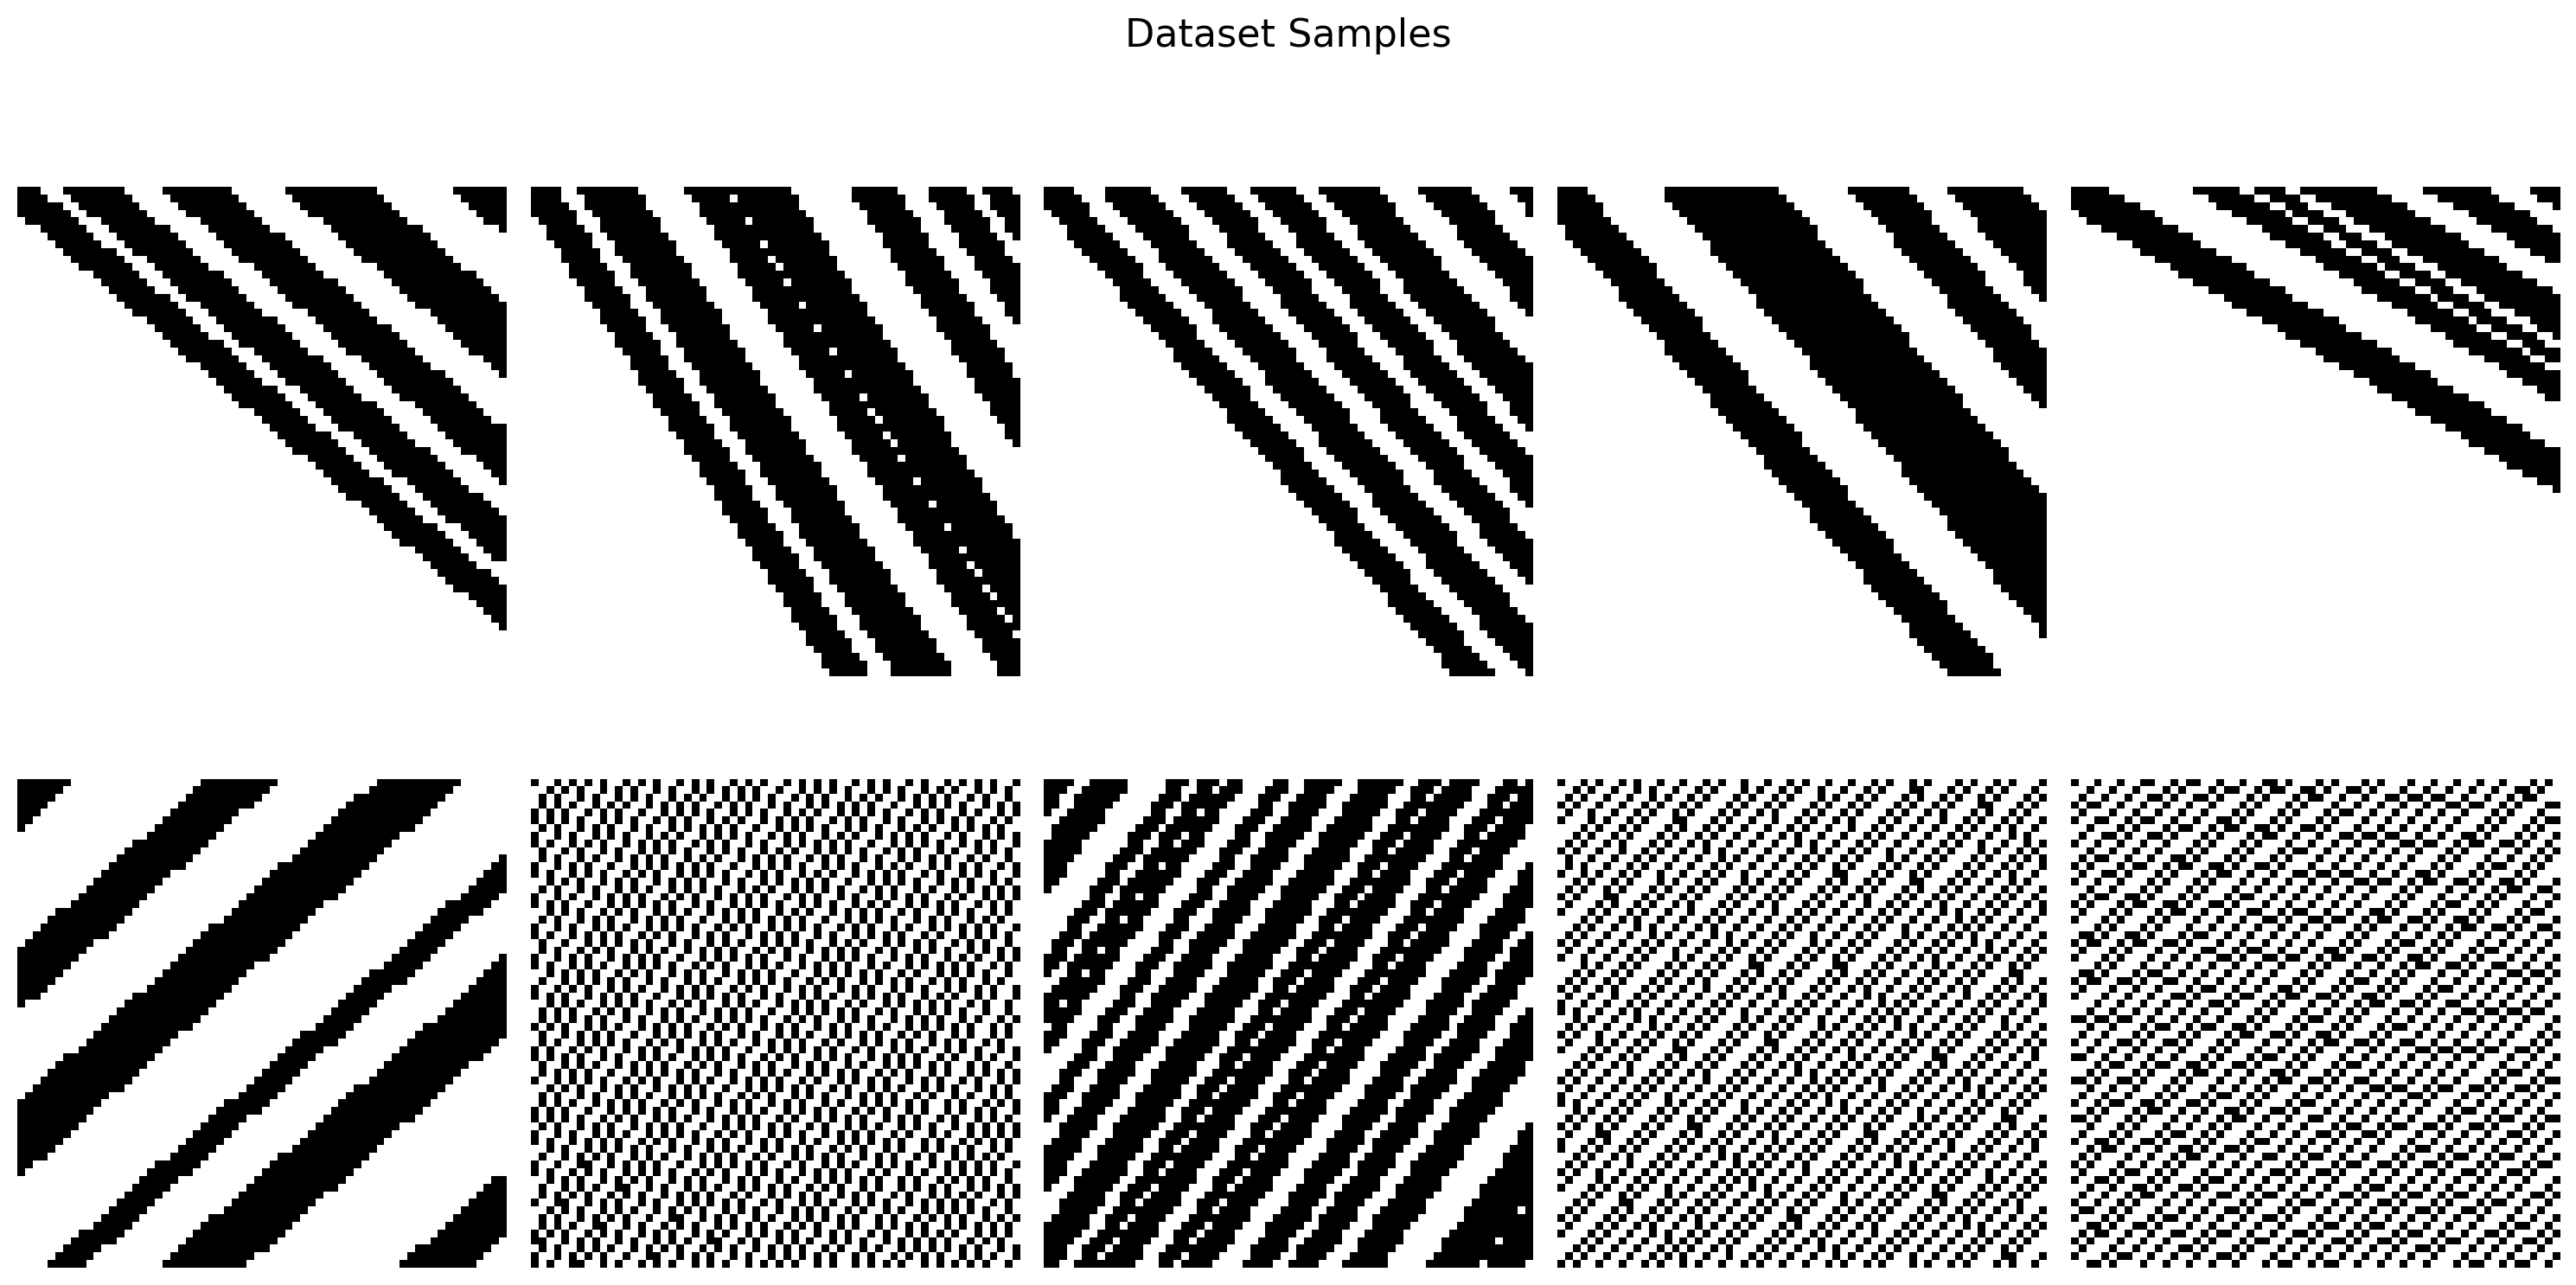


Creating t-SNE visualization of raw data...
Dataset contains 2 classes: ['consistent_layers', 'variable_layers']
Using all 1000 images for t-SNE...
Loading and preprocessing images...


100%|██████████| 1000/1000 [00:00<00:00, 3434.64it/s]
c:\Users\cjh5690.PSU\Anaconda3\envs\Hoydic2025b\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Running t-SNE on 1000 images of dimension 4096...
This might take a while...
t-SNE completed in 3.10 seconds
Silhouette score on t-SNE embedding: 0.5699


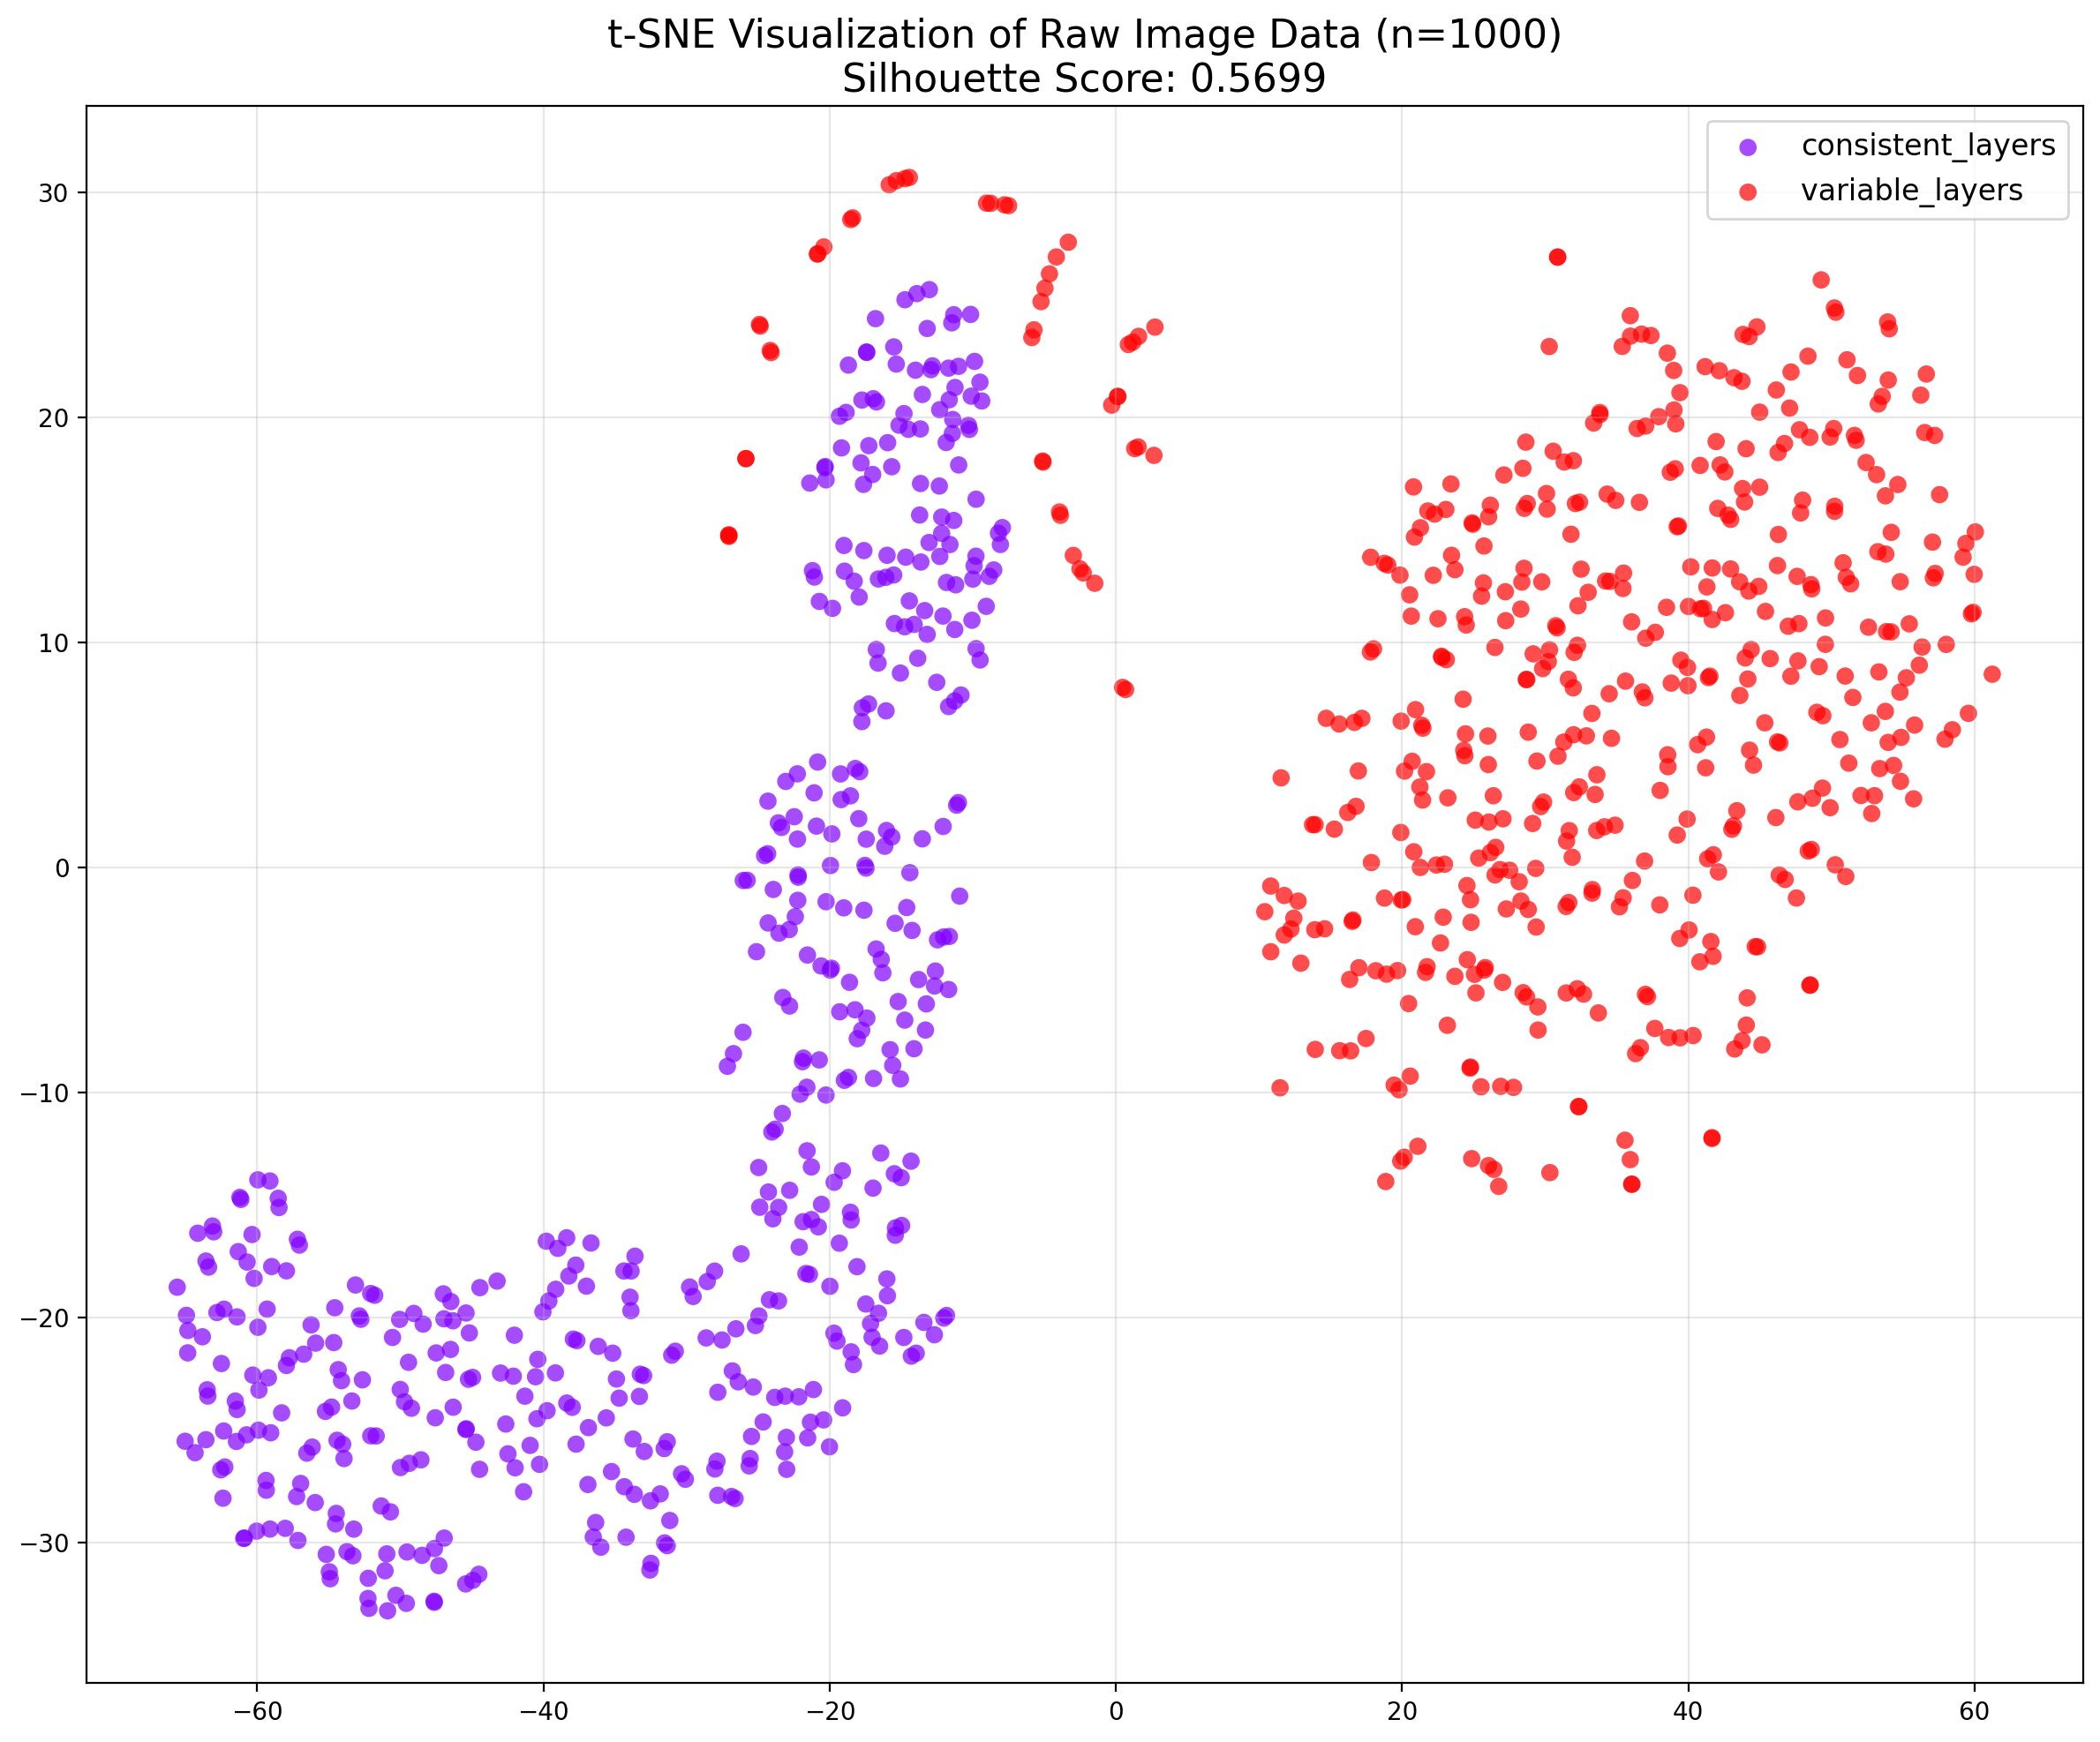

In [24]:
# Generate a dataset with different patterns and visualize it
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import time
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import random
from tqdm import tqdm

# Define a function to visualize dataset samples
def visualize_dataset_samples(dataset_info, samples_per_class=5, figure_size=(15, 8)):
    """
    Visualize random samples from each class in the dataset.
    
    Parameters:
    -----------
    dataset_info : dict
        Dictionary containing dataset information
    samples_per_class : int
        Number of samples to display per class
    figure_size : tuple
        Size of the figure to display
    """
    if not dataset_info.get('filenames'):
        print("Error: No filenames found in dataset_info.")
        return

    unique_labels = sorted(list(set(dataset_info.get('labels', []))))
    label_names = dataset_info.get('label_names', [f"Class {i}" for i in unique_labels])
    
    num_classes = len(unique_labels)
    plt.figure(figsize=figure_size)
    
    # For each class
    for i, label in enumerate(unique_labels):
        # Get indices of this class
        indices = [j for j, l in enumerate(dataset_info['labels']) if l == label]
        
        # Select random samples
        sample_indices = random.sample(indices, min(samples_per_class, len(indices)))
        
        # Plot each sample
        for j, idx in enumerate(sample_indices):
            img_path = dataset_info['filenames'][idx]
            img = Image.open(img_path)
            
            ax = plt.subplot(num_classes, samples_per_class, i * samples_per_class + j + 1)
            ax.imshow(img, cmap='gray')
            
            # Add class label only to the first image of each row
            if j == 0:
                ax.set_ylabel(label_names[label], fontsize=12, rotation=0, labelpad=40, ha='right', va='center')

            ax.set_xticks([])
            ax.set_yticks([])
            ax.axis('off')

    plt.suptitle("Dataset Samples", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

# Function to generate a layered dataset
def generate_layered_dataset(
    output_dir='layered_geologic_patterns_dataset',
    num_samples_per_class=500,  # Reduced for quicker execution
    image_size=64,
    force_regenerate=False
):
    """
    Generate a dataset of synthetic images with two distinct layered pattern classes:
    1. Consistent layers with moderate orientation and thickness
    2. Highly variable layers with perpendicular orientation and extreme thickness variations
    """
    # Check if dataset already exists
    info_path = os.path.join(output_dir, 'dataset_info.npy')
    if os.path.exists(output_dir) and os.path.exists(info_path) and not force_regenerate:
        print(f"Loading existing dataset from {info_path}")
        try:
            dataset_info = np.load(info_path, allow_pickle=True).item()
            print(f"Successfully loaded dataset with {len(dataset_info['filenames'])} images.")
            return dataset_info
        except Exception as e:
            print(f"Error loading existing dataset: {e}")
            if not force_regenerate:
                print("Set force_regenerate=True to create a new dataset.")
                return None

    # Create output directory structure
    try:
        os.makedirs(output_dir, exist_ok=True)
    except Exception as e:
        print(f"Error creating output directory: {e}")
        return None

    # Define pattern classes and create their directories
    pattern_classes = ['consistent_layers', 'variable_layers']
    for pattern_type in pattern_classes:
        try:
            os.makedirs(os.path.join(output_dir, pattern_type), exist_ok=True)
        except Exception as e:
            print(f"Error creating directory for {pattern_type}: {e}")
            return None

    # Dictionary to store file paths and labels
    dataset_info = {
        'filenames': [],
        'labels': [],
        'label_names': pattern_classes,
        'params': {
            'image_size': image_size,
            'num_samples_per_class': num_samples_per_class
        }
    }

    # Generate images for each pattern class
    for class_idx, pattern_type in enumerate(pattern_classes):
        class_dir = os.path.join(output_dir, pattern_type)
        print(f"Generating {num_samples_per_class} '{pattern_type}' images...")

        for i in tqdm(range(num_samples_per_class)):
            # Create a blank white image
            img = Image.new('L', (image_size, image_size), color=255)
            draw = ImageDraw.Draw(img)

            if pattern_type == 'consistent_layers':
                # Consistent layers: moderate orientation and thickness
                angle_deg = random.uniform(30, 60)
                num_layers = random.randint(5, 8)
                base_thickness = random.randint(max(1, image_size // 15), max(3, image_size // 10))
            else:  # 'variable_layers'
                # Highly variable layers: perpendicular orientation
                angle_deg = random.uniform(120, 150)
                num_layers = random.randint(3, 15)
                base_thickness = random.randint(1, max(5, image_size // 5))

            angle_rad = np.radians(angle_deg)
            current_pos = 0
            
            while current_pos < image_size * 1.5:  # Ensure coverage even for diagonal
                # Slight thickness variation within the same sample
                thickness = max(1, base_thickness + random.randint(-base_thickness//3, base_thickness//3))
                
                # Calculate line coords based on angle and current position offset
                offset_x = current_pos * np.sin(angle_rad)
                offset_y = -current_pos * np.cos(angle_rad)
                
                # Line endpoints extended beyond image boundaries
                x0 = offset_x - image_size * np.cos(angle_rad) * 2
                y0 = offset_y - image_size * np.sin(angle_rad) * 2
                x1 = offset_x + image_size * np.cos(angle_rad) * 2
                y1 = offset_y + image_size * np.sin(angle_rad) * 2
                
                # Draw layer: black lines on white background
                draw.line([(x0, y0), (x1, y1)], fill=0, width=thickness)
                
                # Move to next layer position
                gap_multiplier = 1.5 if pattern_type == 'variable_layers' else 1.0
                gap = random.randint(max(1, thickness // 2), int(thickness * gap_multiplier))
                current_pos += thickness + gap

            # Save the image
            filename = os.path.join(class_dir, f"{pattern_type}_{i:05d}.png")
            try:
                img.save(filename)
                dataset_info['filenames'].append(filename)
                dataset_info['labels'].append(class_idx)
            except Exception as e:
                print(f"Error saving image {filename}: {e}")
                continue

    # Save dataset info
    try:
        np.save(info_path, dataset_info)
        print(f"\nLayered pattern dataset generation complete.")
        print(f"Total images generated: {len(dataset_info['filenames'])}")
        print(f"Images saved to {output_dir}")
        print(f"Dataset info saved to {info_path}")
    except Exception as e:
        print(f"Error saving dataset info: {e}")

    return dataset_info

# Function to visualize the raw data using t-SNE
def visualize_raw_data_tsne(dataset_info, random_state=42, max_samples=500, perplexity=30):
    """
    Create a t-SNE visualization of raw image data (not latent representations).
    
    Args:
        dataset_info: Dictionary with dataset information
        random_state: Random seed for reproducibility
        max_samples: Maximum number of samples to use (for speed)
        perplexity: t-SNE perplexity parameter
    """
    # Get class names
    class_names = dataset_info.get('label_names', [f"Class {i}" for i in range(len(np.unique(dataset_info['labels'])))])
    print(f"Dataset contains {len(class_names)} classes: {class_names}")
    
    # Use a subset of samples if there are too many
    total_samples = len(dataset_info['filenames'])
    if total_samples > max_samples:
        print(f"Sampling {max_samples} images out of {total_samples} for t-SNE...")
        sample_indices = np.random.choice(total_samples, max_samples, replace=False)
    else:
        print(f"Using all {total_samples} images for t-SNE...")
        sample_indices = np.arange(total_samples)
    
    # Load images and flatten them
    images = []
    labels = []
    
    print("Loading and preprocessing images...")
    for idx in tqdm(sample_indices):
        # Load image
        img_path = dataset_info['filenames'][idx]
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        
        # Flatten the image to a 1D vector
        img_array = np.array(img).flatten() / 255.0  # Normalize to [0, 1]
        
        images.append(img_array)
        labels.append(dataset_info['labels'][idx])
    
    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)
    
    print(f"Running t-SNE on {X.shape[0]} images of dimension {X.shape[1]}...")
    print("This might take a while...")
    
    # Apply t-SNE
    start_time = time.time()
    tsne = TSNE(n_components=2, perplexity=min(perplexity, len(X)-1), 
                n_iter=1000, random_state=random_state)
    X_tsne = tsne.fit_transform(X)
    elapsed = time.time() - start_time
    print(f"t-SNE completed in {elapsed:.2f} seconds")
    
    # Calculate silhouette score on t-SNE results if there are at least 2 classes
    if len(np.unique(y)) > 1:
        silhouette = silhouette_score(X_tsne, y)
        print(f"Silhouette score on t-SNE embedding: {silhouette:.4f}")
    else:
        silhouette = None
        print("Only one class found, silhouette score not calculated")
    
    # Visualize the t-SNE embedding
    plt.figure(figsize=(12, 10))
    
    # Plot each class with a different color
    unique_labels = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        mask = y == label
        plt.scatter(
            X_tsne[mask, 0], X_tsne[mask, 1],
            c=[colors[i]],
            label=class_names[label] if label < len(class_names) else f"Class {label}",
            alpha=0.7,
            s=50,
            edgecolors='none'
        )
    
    # Add silhouette score to title
    title = f't-SNE Visualization of Raw Image Data (n={len(X)})'
    if silhouette is not None:
        title += f'\nSilhouette Score: {silhouette:.4f}'
    
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return X_tsne, y, silhouette

# Run the dataset generation and visualization
# Either generate a new dataset or load an existing one
dataset_info = generate_layered_dataset(
    output_dir='layered_geologic_patterns_dataset',
    num_samples_per_class=100,  # Reduced for quicker execution
    image_size=64, 
    force_regenerate=False  # Set to True to regenerate the dataset
)

# Visualize samples from the dataset
if dataset_info:
    print("Visualizing dataset samples...")
    visualize_dataset_samples(dataset_info, samples_per_class=5)
    
    # Create and visualize t-SNE of raw data
    print("\nCreating t-SNE visualization of raw data...")
    tsne_results = visualize_raw_data_tsne(
        dataset_info, 
        random_state=42,
        max_samples=1000,  # Limit sample count for faster execution
        perplexity=30
    )
else:
    print("Dataset not available for visualization.")

The t-SNE visualization above shows the structure of the raw image data in 2D space. This represents how the data looks *before* any dimensionality reduction by an autoencoder.

Key observations:
1. The visualization reveals if classes are naturally separable in the raw data
2. The silhouette score quantifies how well-clustered the classes are
3. This provides a baseline for comparison with autoencoder latent space representations

When we later run autoencoders with different latent dimensions, we can compare their t-SNE visualizations with this raw data visualization to see if the model effectively captures the underlying structure of the data.

# Ready-to-Run Examples

The following cells contain complete examples that can be executed directly. Each demonstrates a specific aspect of the wrapper's functionality.

## Example 1: Running a Single Model Experiment

This example demonstrates training a single model with specific architecture and latent dimensions:

Experiment session timestamp: 20250514_170210
MultiArchitectureManager initialized with session timestamp: 20250514_170210
Loading dataset from layered_geologic_patterns_dataset/dataset_info.npy
Loaded dataset with 1000 samples
Classes: ['consistent_layers', 'variable_layers']
Loading existing data split from data_split.json
Loaded existing data split from data_split.json
Split data into 800 train and 200 test samples
Prepared data loaders with batch size 32
Train loader has 25 batches
Test data has 200 samples
Data preparation complete.
Dataset: layered_geologic_patterns_dataset/dataset_info.npy
Split: 20.0% test, 80.0% train
Classes: ['consistent_layers', 'variable_layers']

Running experiment: convolutional_16d_20250514_170210
Created model: ConvAutoencoder with latent dimension 16
Training ConvAutoencoder for 3 epochs on cpu
Learning rate: 0.001, Weight decay: 1e-05
Visualizing at epochs: [2]
Epoch 0/3 completed | Train loss: 0.2354 | Test loss: 0.2240
Epoch 1/3 completed | Train l

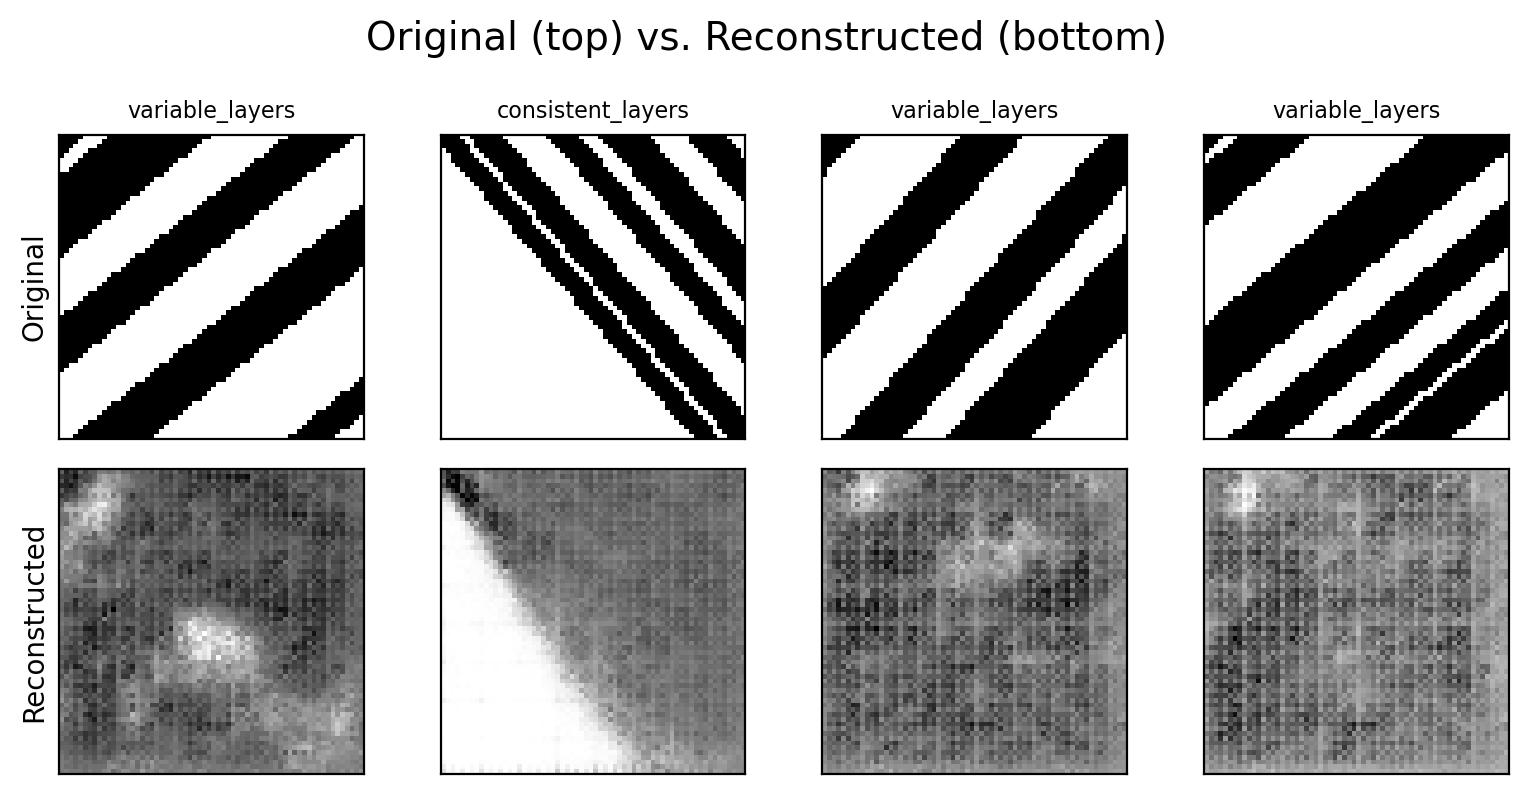

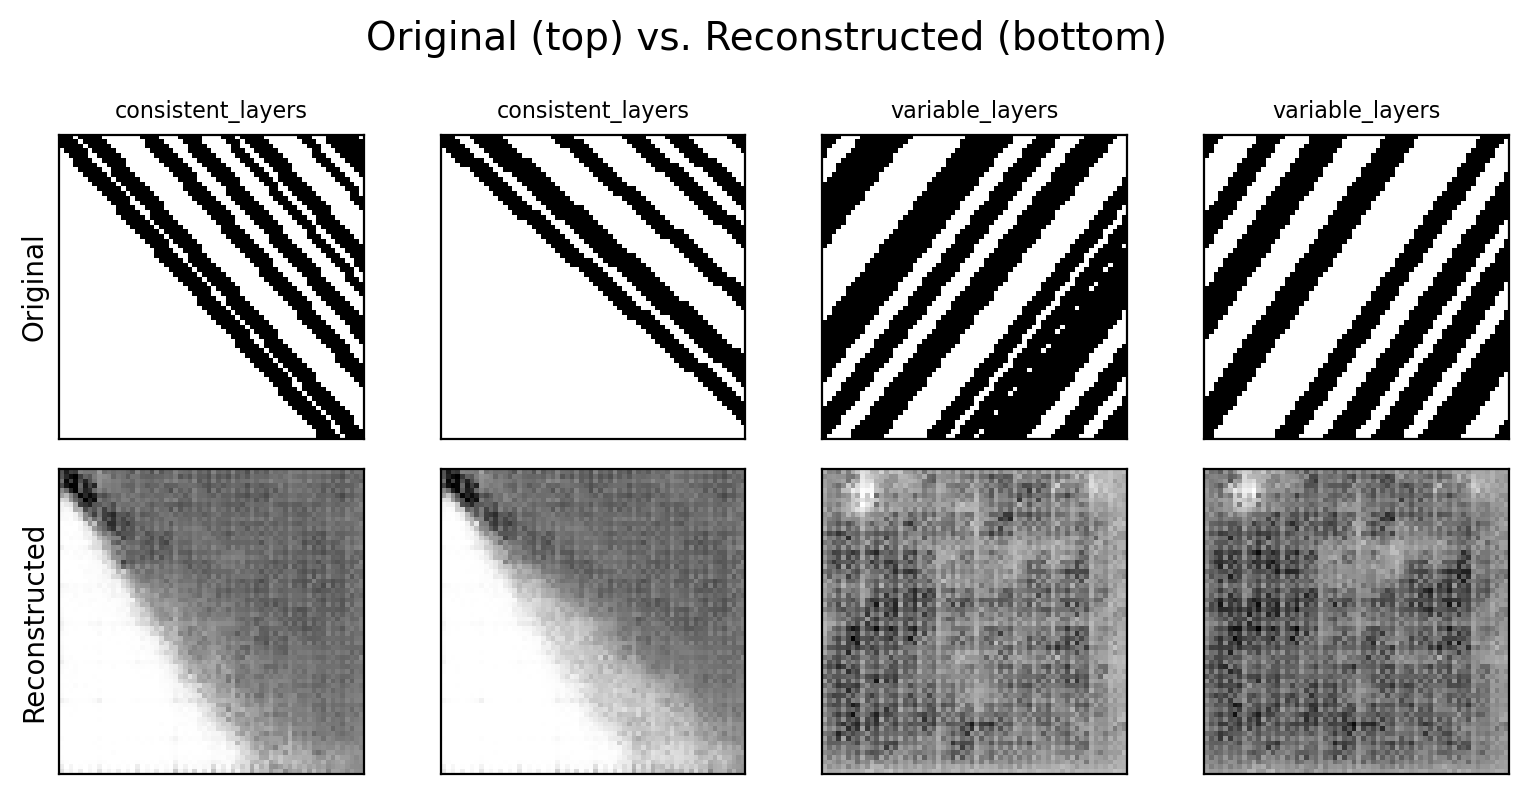

Train t-SNE Silhouette Score: 0.777
Test t-SNE Silhouette Score: 0.879


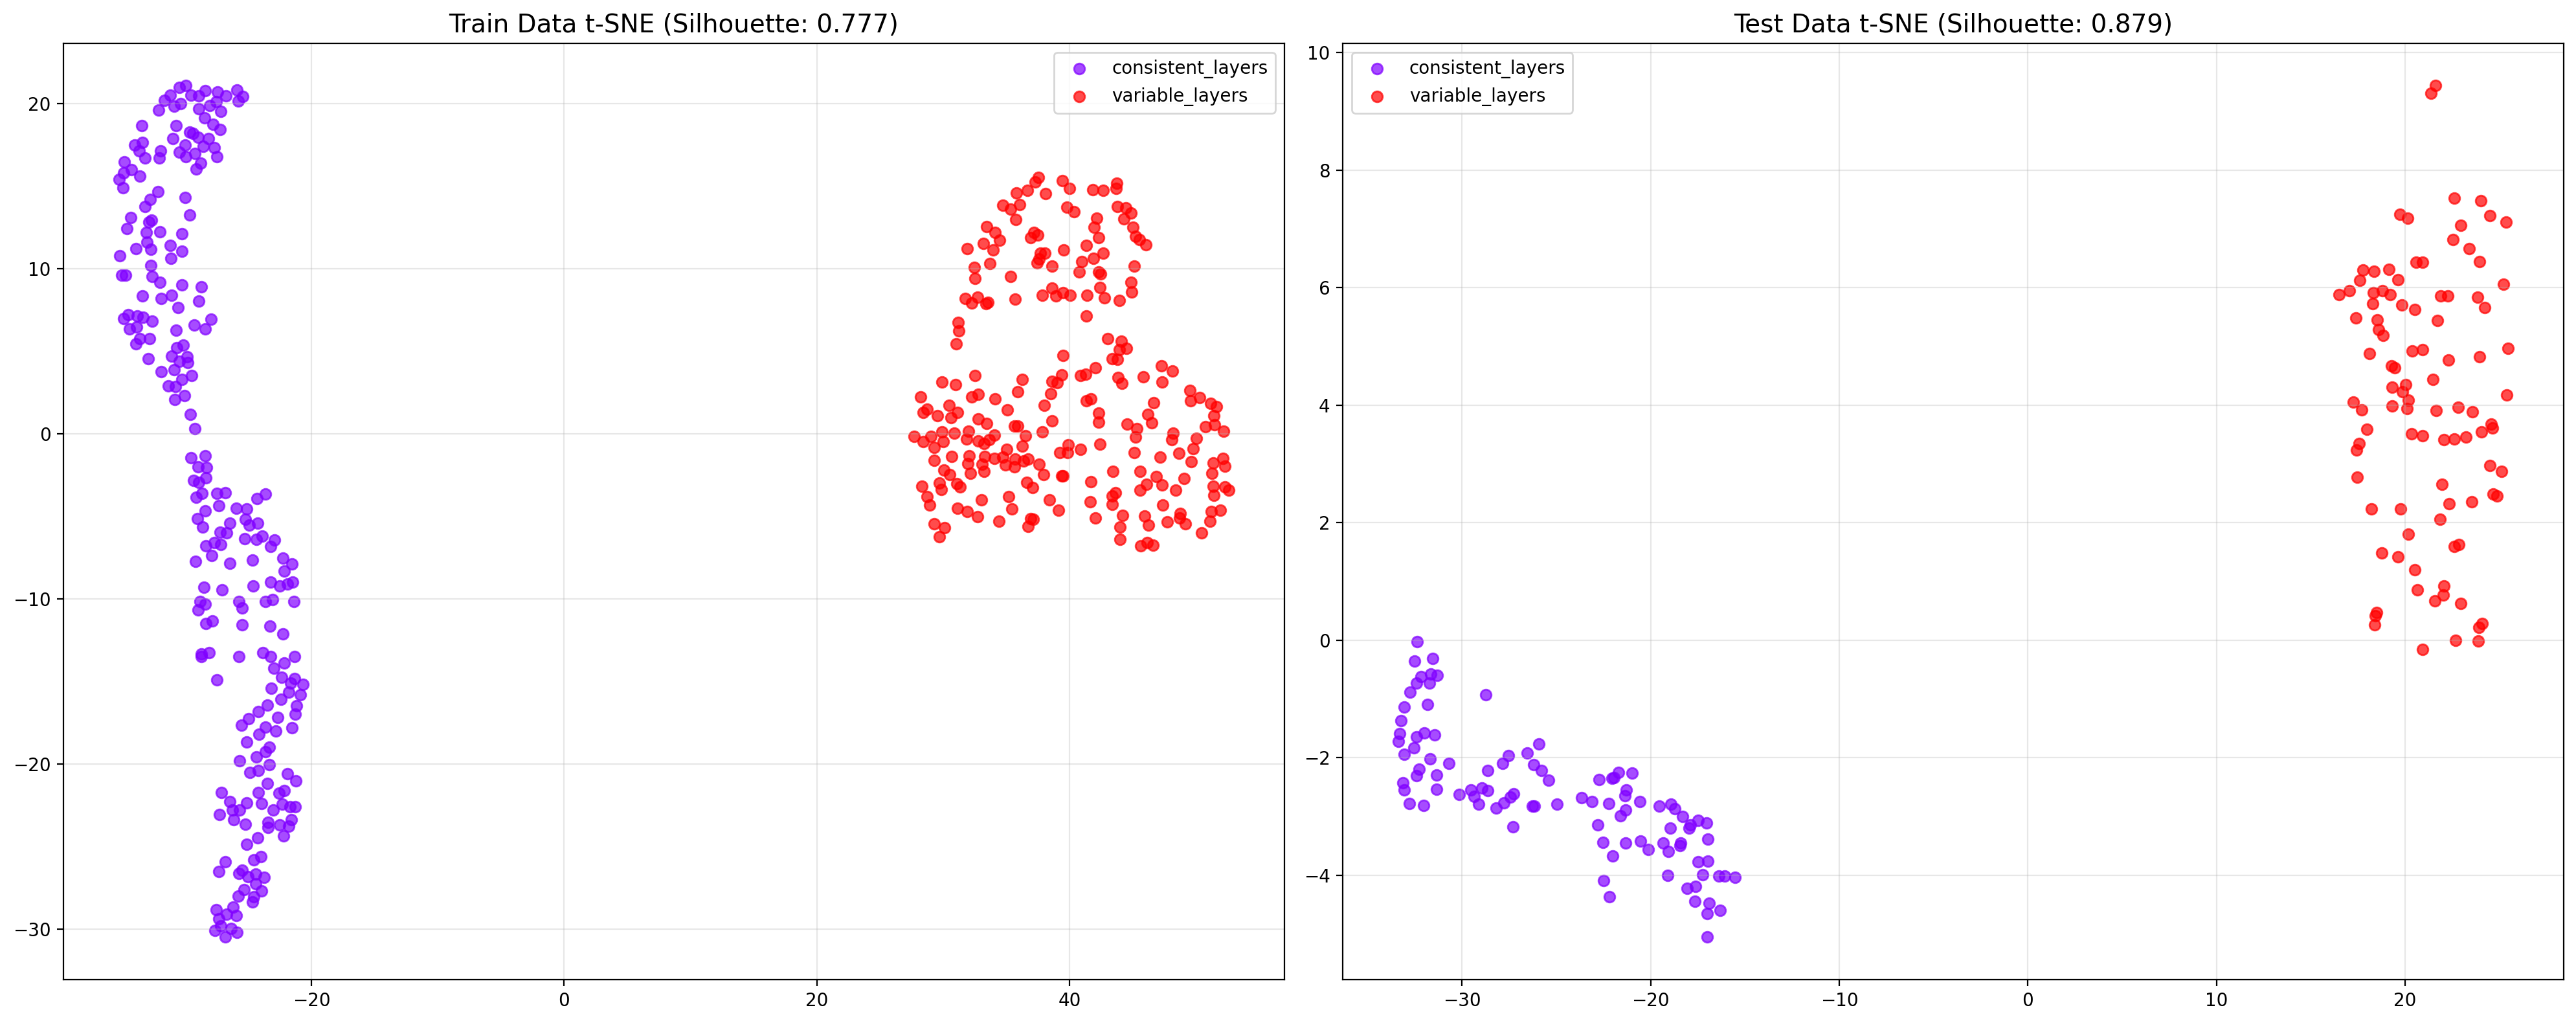

Performing final visualization at epoch 2, step 24
Epoch: 2, Step: 24 | train loss: 0.1779 | test loss: 0.1837


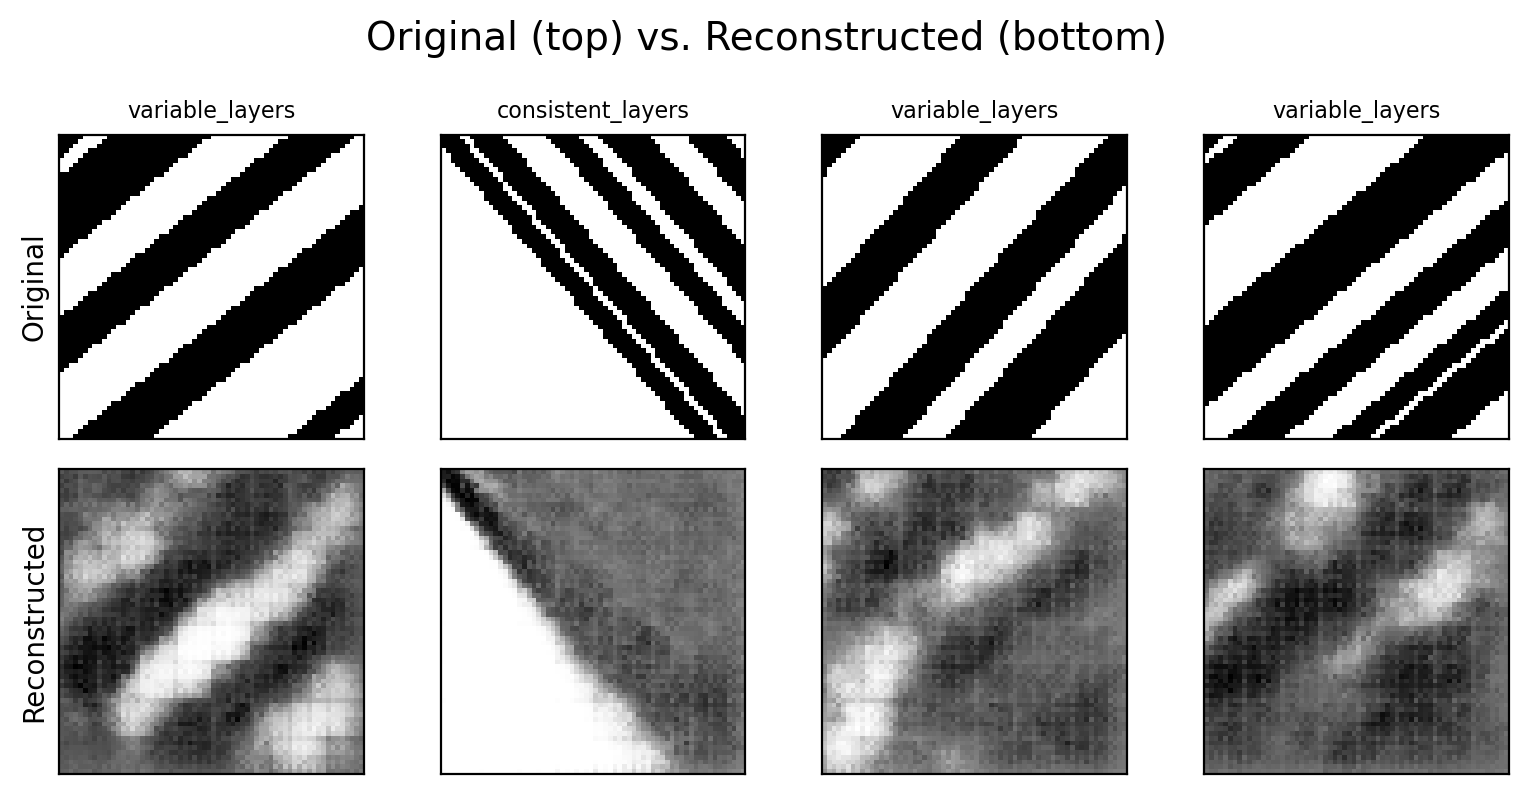

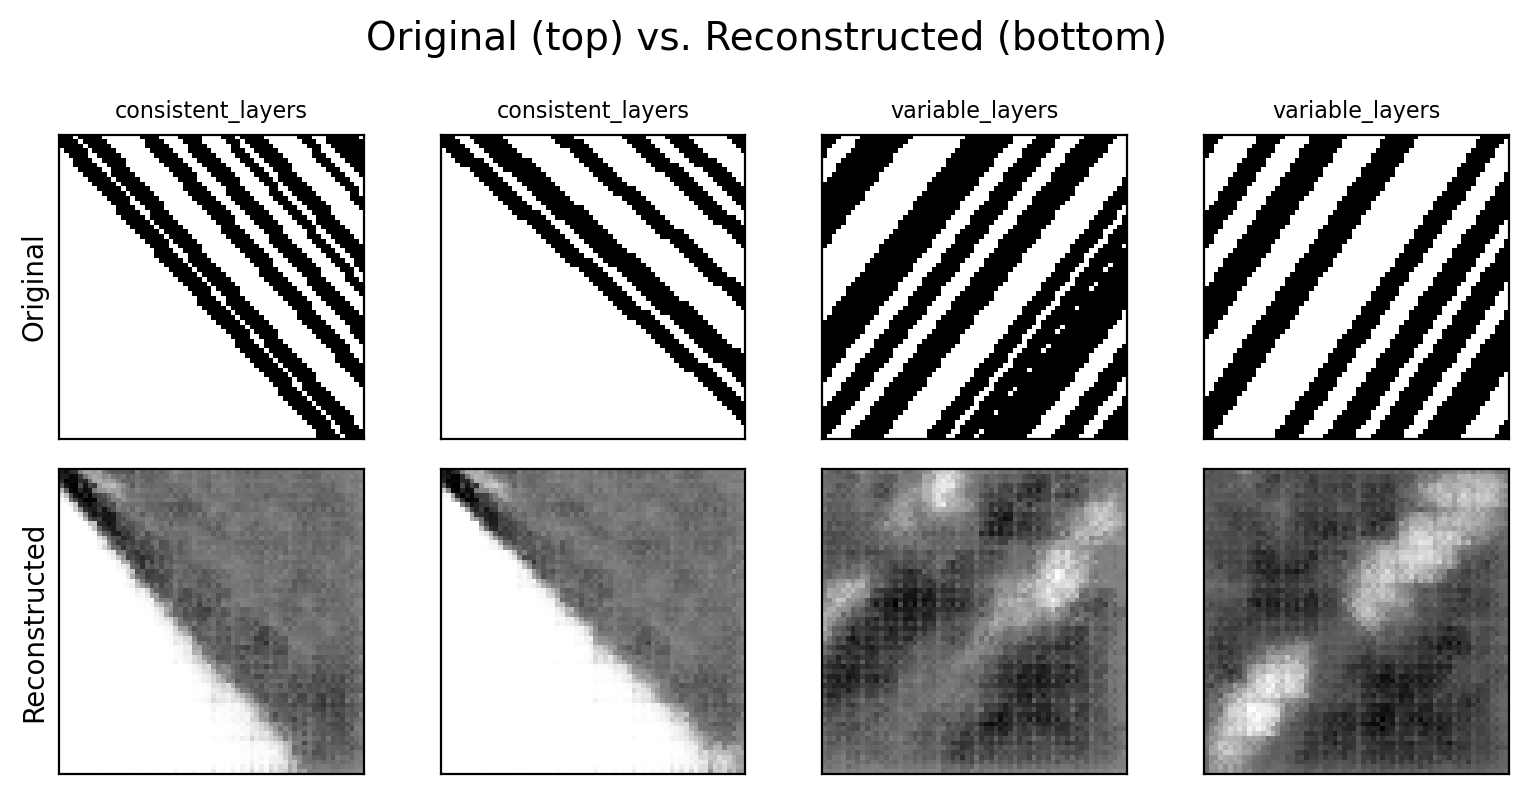

Epoch 2/3 completed | Train loss: 0.1904 | Test loss: 0.1837
Training completed in 12.73 seconds
Final train loss: 0.1798
Final test loss: 0.1837
Generating final latent space visualization and metrics
Train t-SNE Silhouette Score: 0.761
Test t-SNE Silhouette Score: 0.893


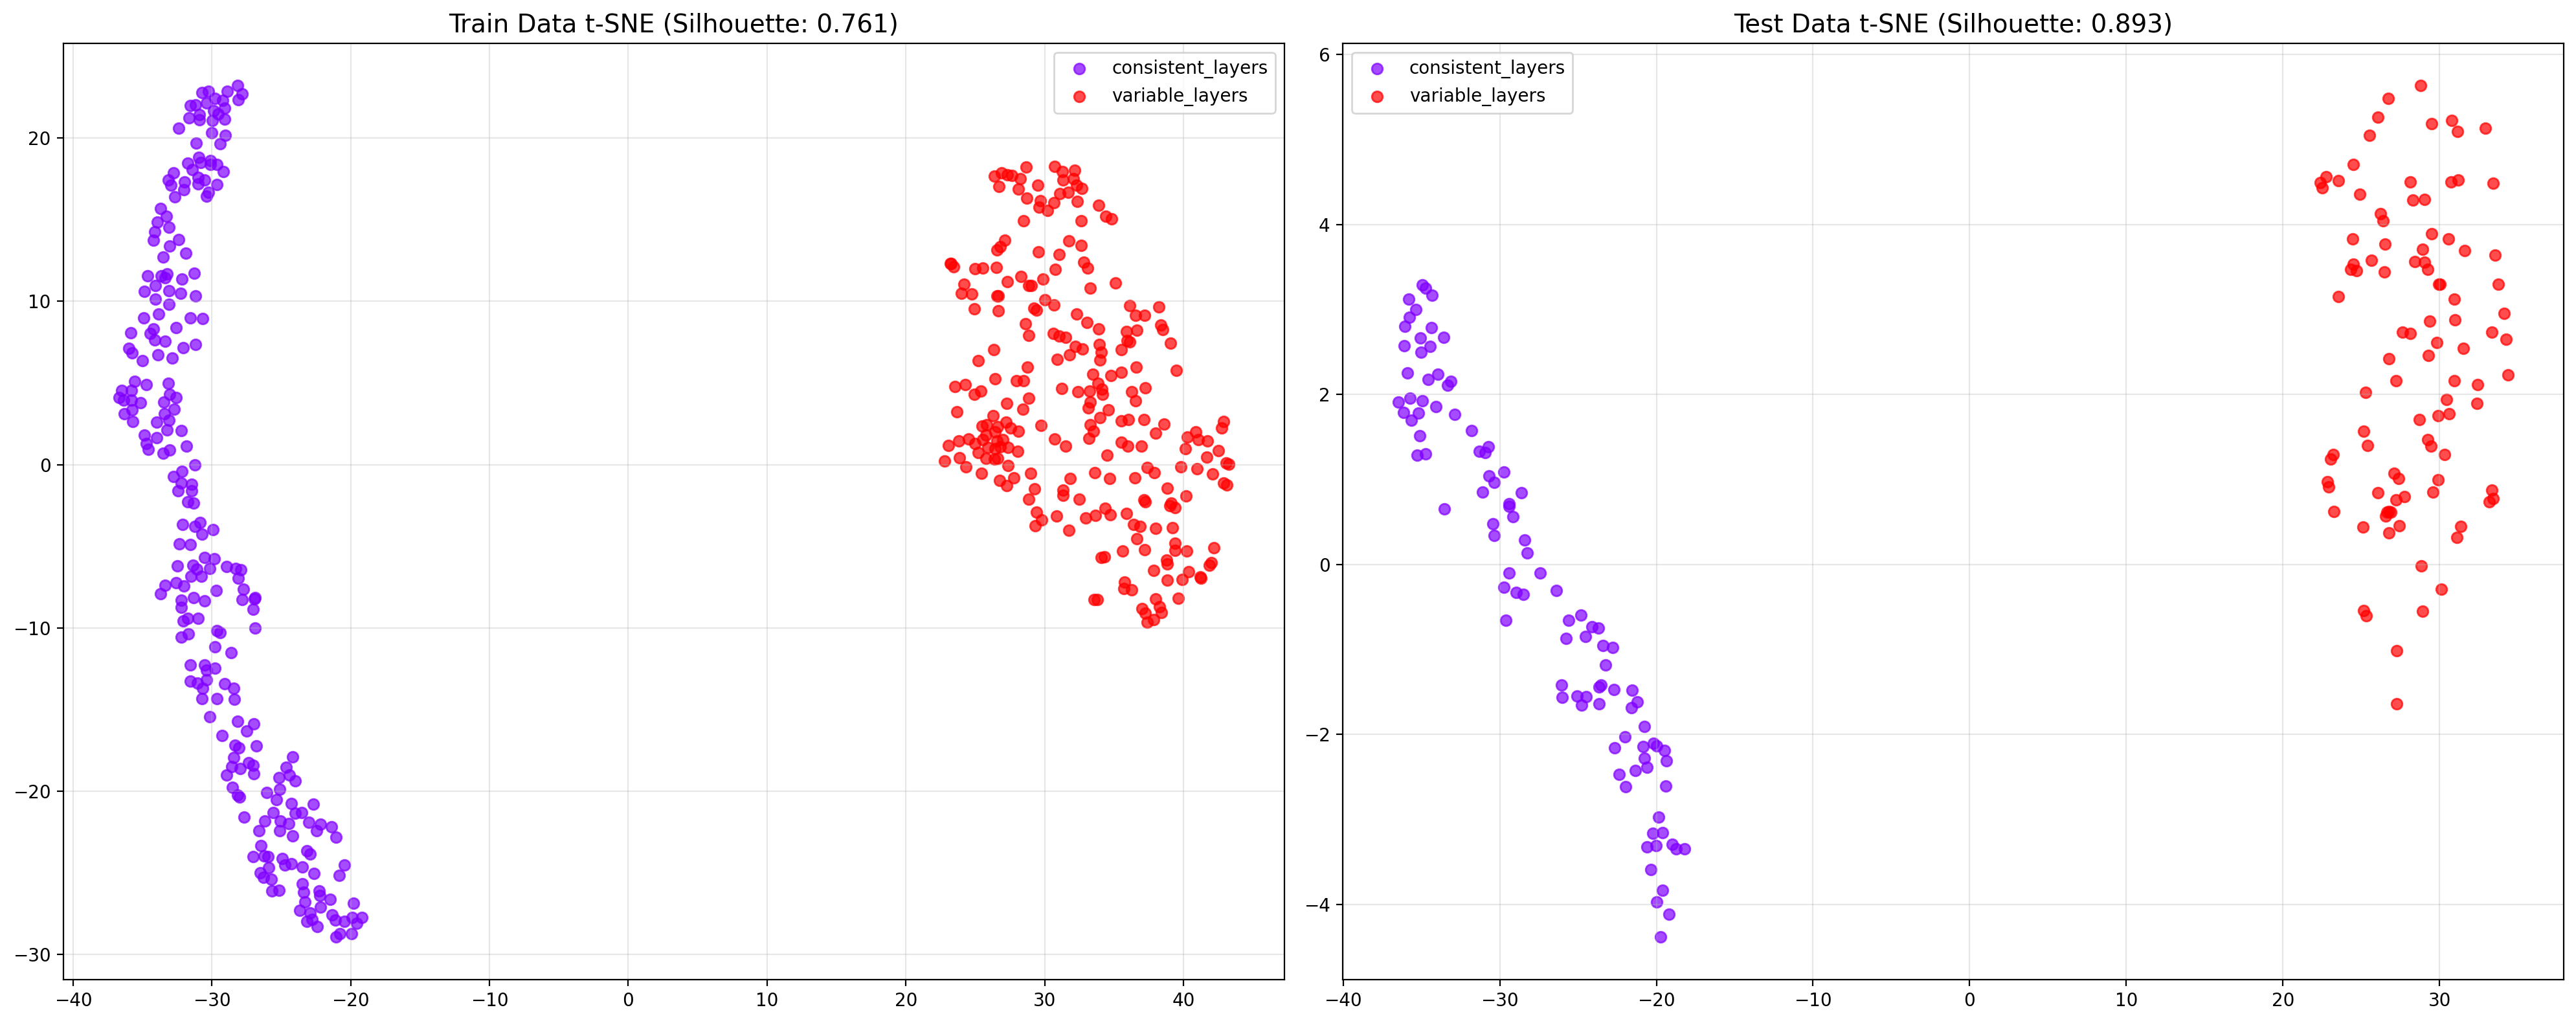

Final train silhouette score: 0.7611
Final test silhouette score: 0.8929
Model saved to latent_dim_exploration_results_layered_geology\convolutional_16d_20250514_170210_model.pth

Generating enhanced visualizations...


AttributeError: 'AutoEncoderWrapper' object has no attribute 'enhanced_training_visualizations'

In [25]:
# Create an experiment manager with configuration for a single model run
single_model_config = {
    'dataset_path': 'layered_geologic_patterns_dataset/dataset_info.npy',
    'output_dir': 'latent_dim_exploration_results_layered_geology',
    'epochs': 3,  # Small number of epochs for quick demonstration
    'batch_size': 32,
    'num_visualizations': 1  # Only visualize at the end to speed up training
}

# Initialize the experiment manager
exp_manager = ExperimentManager(single_model_config)

# Load and prepare the dataset
exp_manager.prepare_data()

# Train a single model (convolutional autoencoder with latent dimension 16)
model, history, results = exp_manager.run_single_experiment(
    architecture='convolutional',
    latent_dim=16
)

# Display summary of results
print(f"\nExperiment completed with:")
print(f"Architecture: convolutional")
print(f"Latent dimension: 16")
print(f"Final test loss: {results['test_loss']:.4f}")
if results['silhouette_score'] is not None:
    print(f"Silhouette score: {results['silhouette_score']:.4f}")
print(f"Training time: {history['training_time']:.2f} seconds")
print(f"Model saved in: {exp_manager.base_config['output_dir']}")

## Example 2: Running Multiple Architecture and Latent Dimension Study

This example demonstrates how to run a study that compares multiple architectures across different latent dimensions:

In [75]:
# Create an experiment manager for running multiple models
study_config = {
    'dataset_path': 'layered_geologic_patterns_dataset/dataset_info.npy',
    'output_dir': 'latent_dim_exploration_results_layered_geology',
    'epochs': 2,  # Very small number of epochs for quick demonstration
    'batch_size': 32,
    'num_visualizations': 1,  # Only visualize at the end to speed up training
    'random_seed': 42  # Set specific random seed for reproducibility
}

# Initialize the experiment manager
study_manager = ExperimentManager(study_config)

# Load and prepare the dataset
study_manager.prepare_data()

# Define architectures and latent dimensions to test
# For demonstration, we'll use a small subset to keep execution quick
architectures_to_test = ['simple_linear', 'convolutional']  # Try just two architectures
latent_dims_to_test = [8, 16]  # Try just two latent dimensions

# Run the architecture study
architecture_results = study_manager.run_architecture_latent_study(
    architectures=architectures_to_test,
    latent_dims=latent_dims_to_test,
    epochs=2  # Override epochs again for clarity
)

# Get and display a comparison table of all models
comparison_df = study_manager.create_comparison_table()
print("\nComparison of all trained models:")
display(comparison_df)  # For nicer display in Jupyter

# Save results to CSV
result_path = study_manager.save_results_to_csv()
print(f"\nResults saved to: {result_path}")

# The study also automatically generates heatmaps and comparison plots during execution

Experiment session timestamp: 20250514_163352
MultiArchitectureManager initialized with session timestamp: 20250514_163352
Loading dataset from layered_geologic_patterns_dataset/dataset_info.npy
Loaded dataset with 1000 samples
Classes: ['consistent_layers', 'variable_layers']
Loading existing data split from data_split.json
Loaded existing data split from data_split.json
Split data into 800 train and 200 test samples
Prepared data loaders with batch size 32
Train loader has 25 batches
Test data has 200 samples
Data preparation complete.
Dataset: layered_geologic_patterns_dataset/dataset_info.npy
Split: 20.0% test, 80.0% train
Classes: ['consistent_layers', 'variable_layers']


Training simple_linear with latent_dim=8
Created model: SimpleLinearAutoencoder with latent dimension 8


TypeError: enhanced_train() got an unexpected keyword argument 'epochs'

## Example 3: Loading and Analyzing Saved Model Results

This example demonstrates loading models saved with a specific timestamp and analyzing their performance:

Experiment session timestamp: 20250514_141558
MultiArchitectureManager initialized with session timestamp: 20250514_141558
Loading dataset from layered_geologic_patterns_dataset/dataset_info.npy
Loaded dataset with 1000 samples
Classes: ['consistent_layers', 'variable_layers']
Loading existing data split from data_split.json
Loaded existing data split from data_split.json
Split data into 800 train and 200 test samples
Prepared data loaders with batch size 32
Train loader has 25 batches
Test data has 200 samples
Data preparation complete.
Dataset: layered_geologic_patterns_dataset/dataset_info.npy
Split: 20.0% test, 80.0% train
Classes: ['consistent_layers', 'variable_layers']
Using timestamp from previous run: 20250514_135025
Found 4 model files
Loading model: convolutional_16d_20250514_135025_model
Loaded configuration from checkpoint
Created model: ConvAutoencoder with latent dimension 16
Loaded history from checkpoint
Model was trained for 2 epochs
Final test loss: 0.199879041910171

C:\Users\cjh5690.PSU\AppData\Local\Temp\ipykernel_35880\1398514019.py:698: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, map_location=torc

Evaluation results:
Test loss: 0.1999
Silhouette score: 0.7107
Loading model: convolutional_8d_20250514_135025_model
Loaded configuration from checkpoint
Created model: ConvAutoencoder with latent dimension 8
Loaded history from checkpoint
Model was trained for 2 epochs
Final test loss: 0.20432033896446228
Final test silhouette score: 0.832736611366272
Model loaded successfully from latent_dim_exploration_results_layered_geology\convolutional_8d_20250514_135025_model.pth
Evaluation results:
Test loss: 0.2043
Silhouette score: 0.7028
Loading model: simple_linear_16d_20250514_135025_model
Loaded configuration from checkpoint
Created model: SimpleLinearAutoencoder with latent dimension 16
Loaded history from checkpoint
Model was trained for 2 epochs
Final test loss: 0.20286369502544402
Final test silhouette score: 0.845875084400177
Model loaded successfully from latent_dim_exploration_results_layered_geology\simple_linear_16d_20250514_135025_model.pth
Evaluation results:
Test loss: 0.2029

C:\Users\cjh5690.PSU\AppData\Local\Temp\ipykernel_35880\1398514019.py:698: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, map_location=torc

Experiment   Architecture  Latent Dim  \
0  convolutional_16d_20250514_135025_model  convolutional          16   
1   convolutional_8d_20250514_135025_model  convolutional           8   
2  simple_linear_16d_20250514_135025_model  simple_linear          16   
3   simple_linear_8d_20250514_135025_model  simple_linear           8   

                     Model Test Loss Train Loss Silhouette Train Time (s)  \
0          ConvAutoencoder    0.1999     0.1976     0.7107          12.57   
1          ConvAutoencoder    0.2043     0.2040     0.7028          12.64   
2  SimpleLinearAutoencoder    0.2029     0.2030     0.6418          12.09   
3  SimpleLinearAutoencoder    0.2047     0.2013     0.6984          12.33   

  Timestamp  
0   Unknown  
1   Unknown  
2   Unknown  
3   Unknown


Generating performance visualization for loaded models...


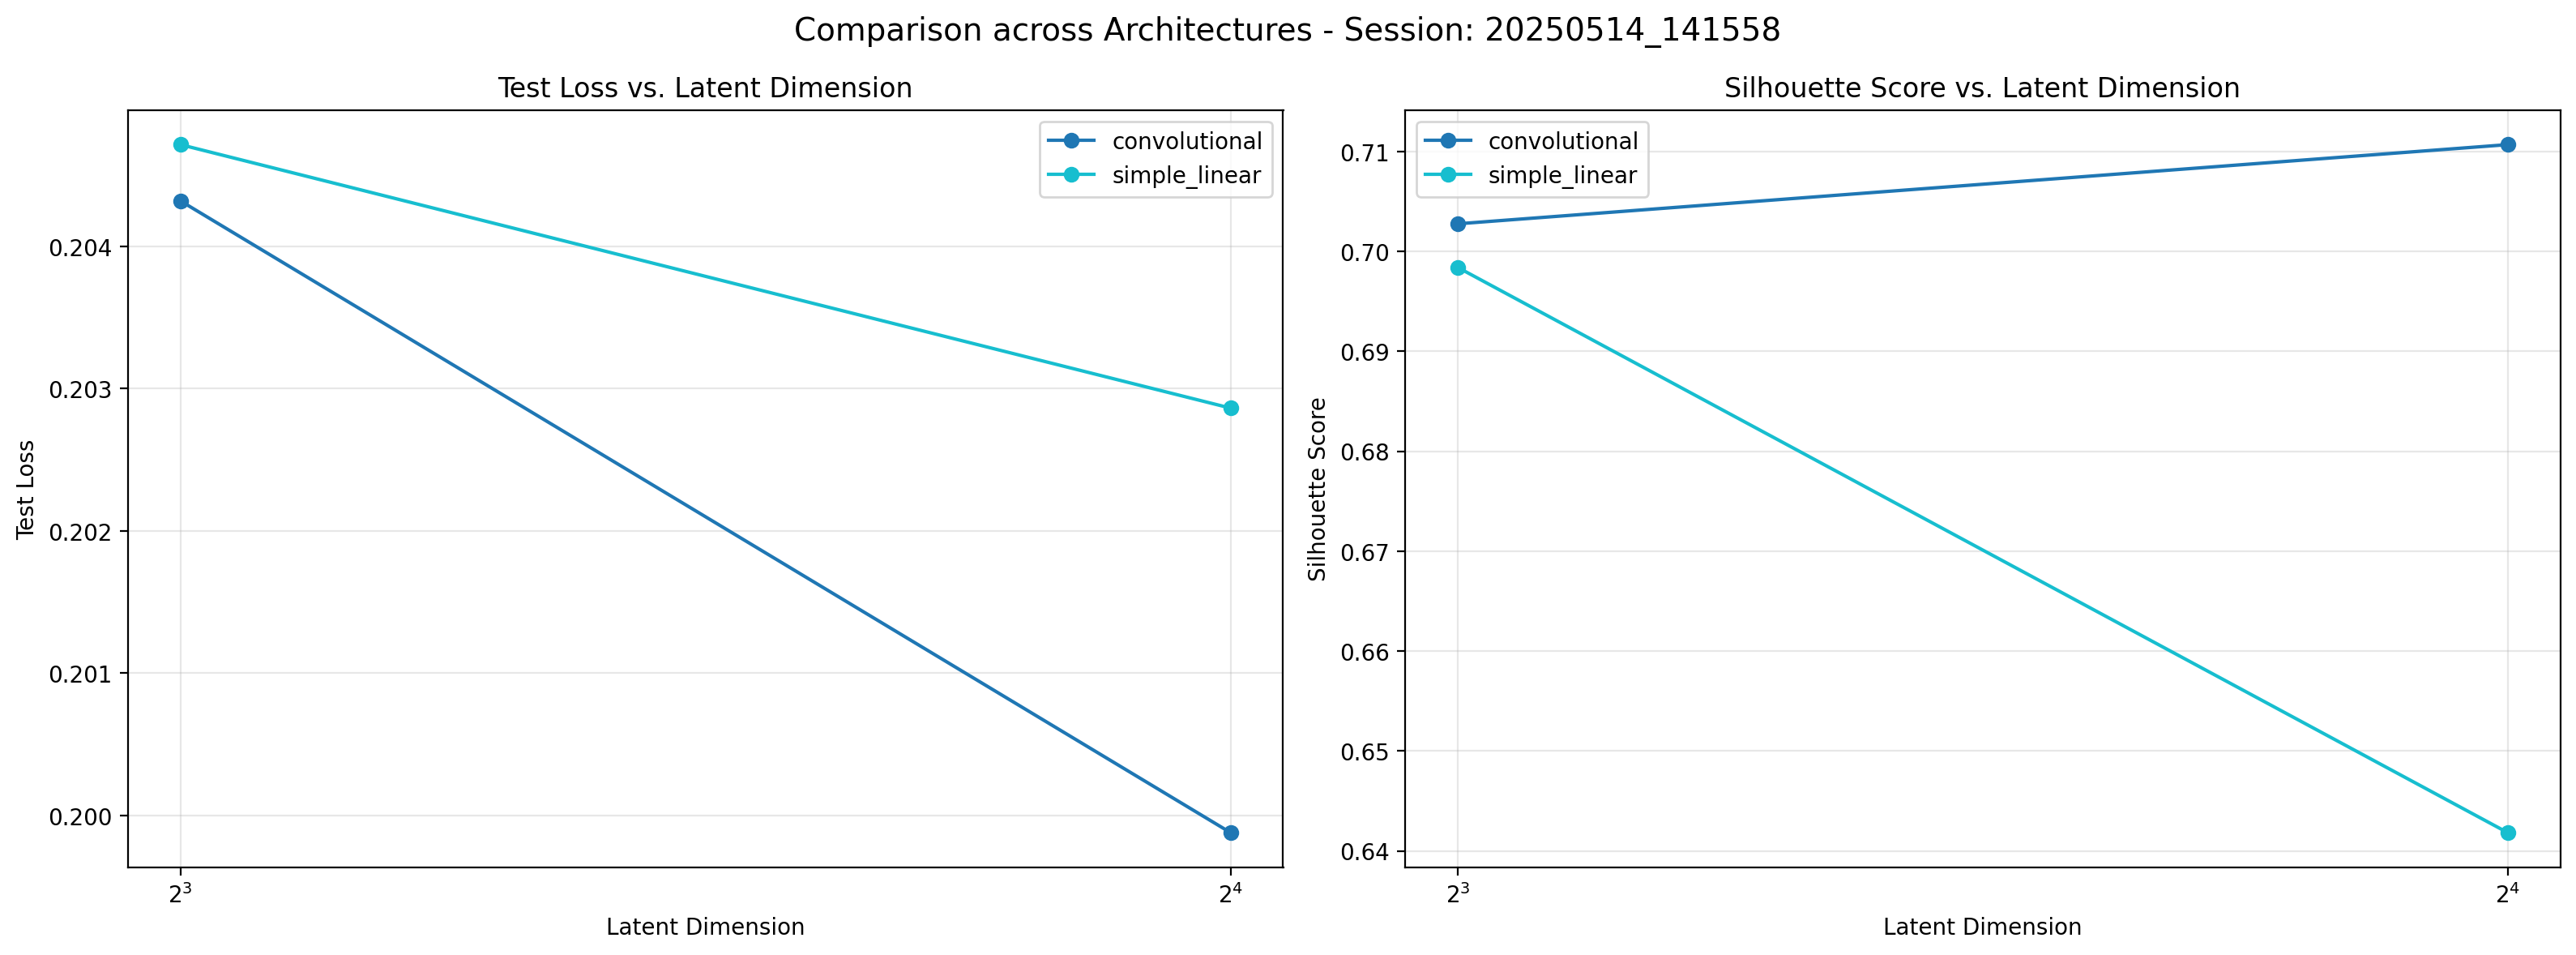

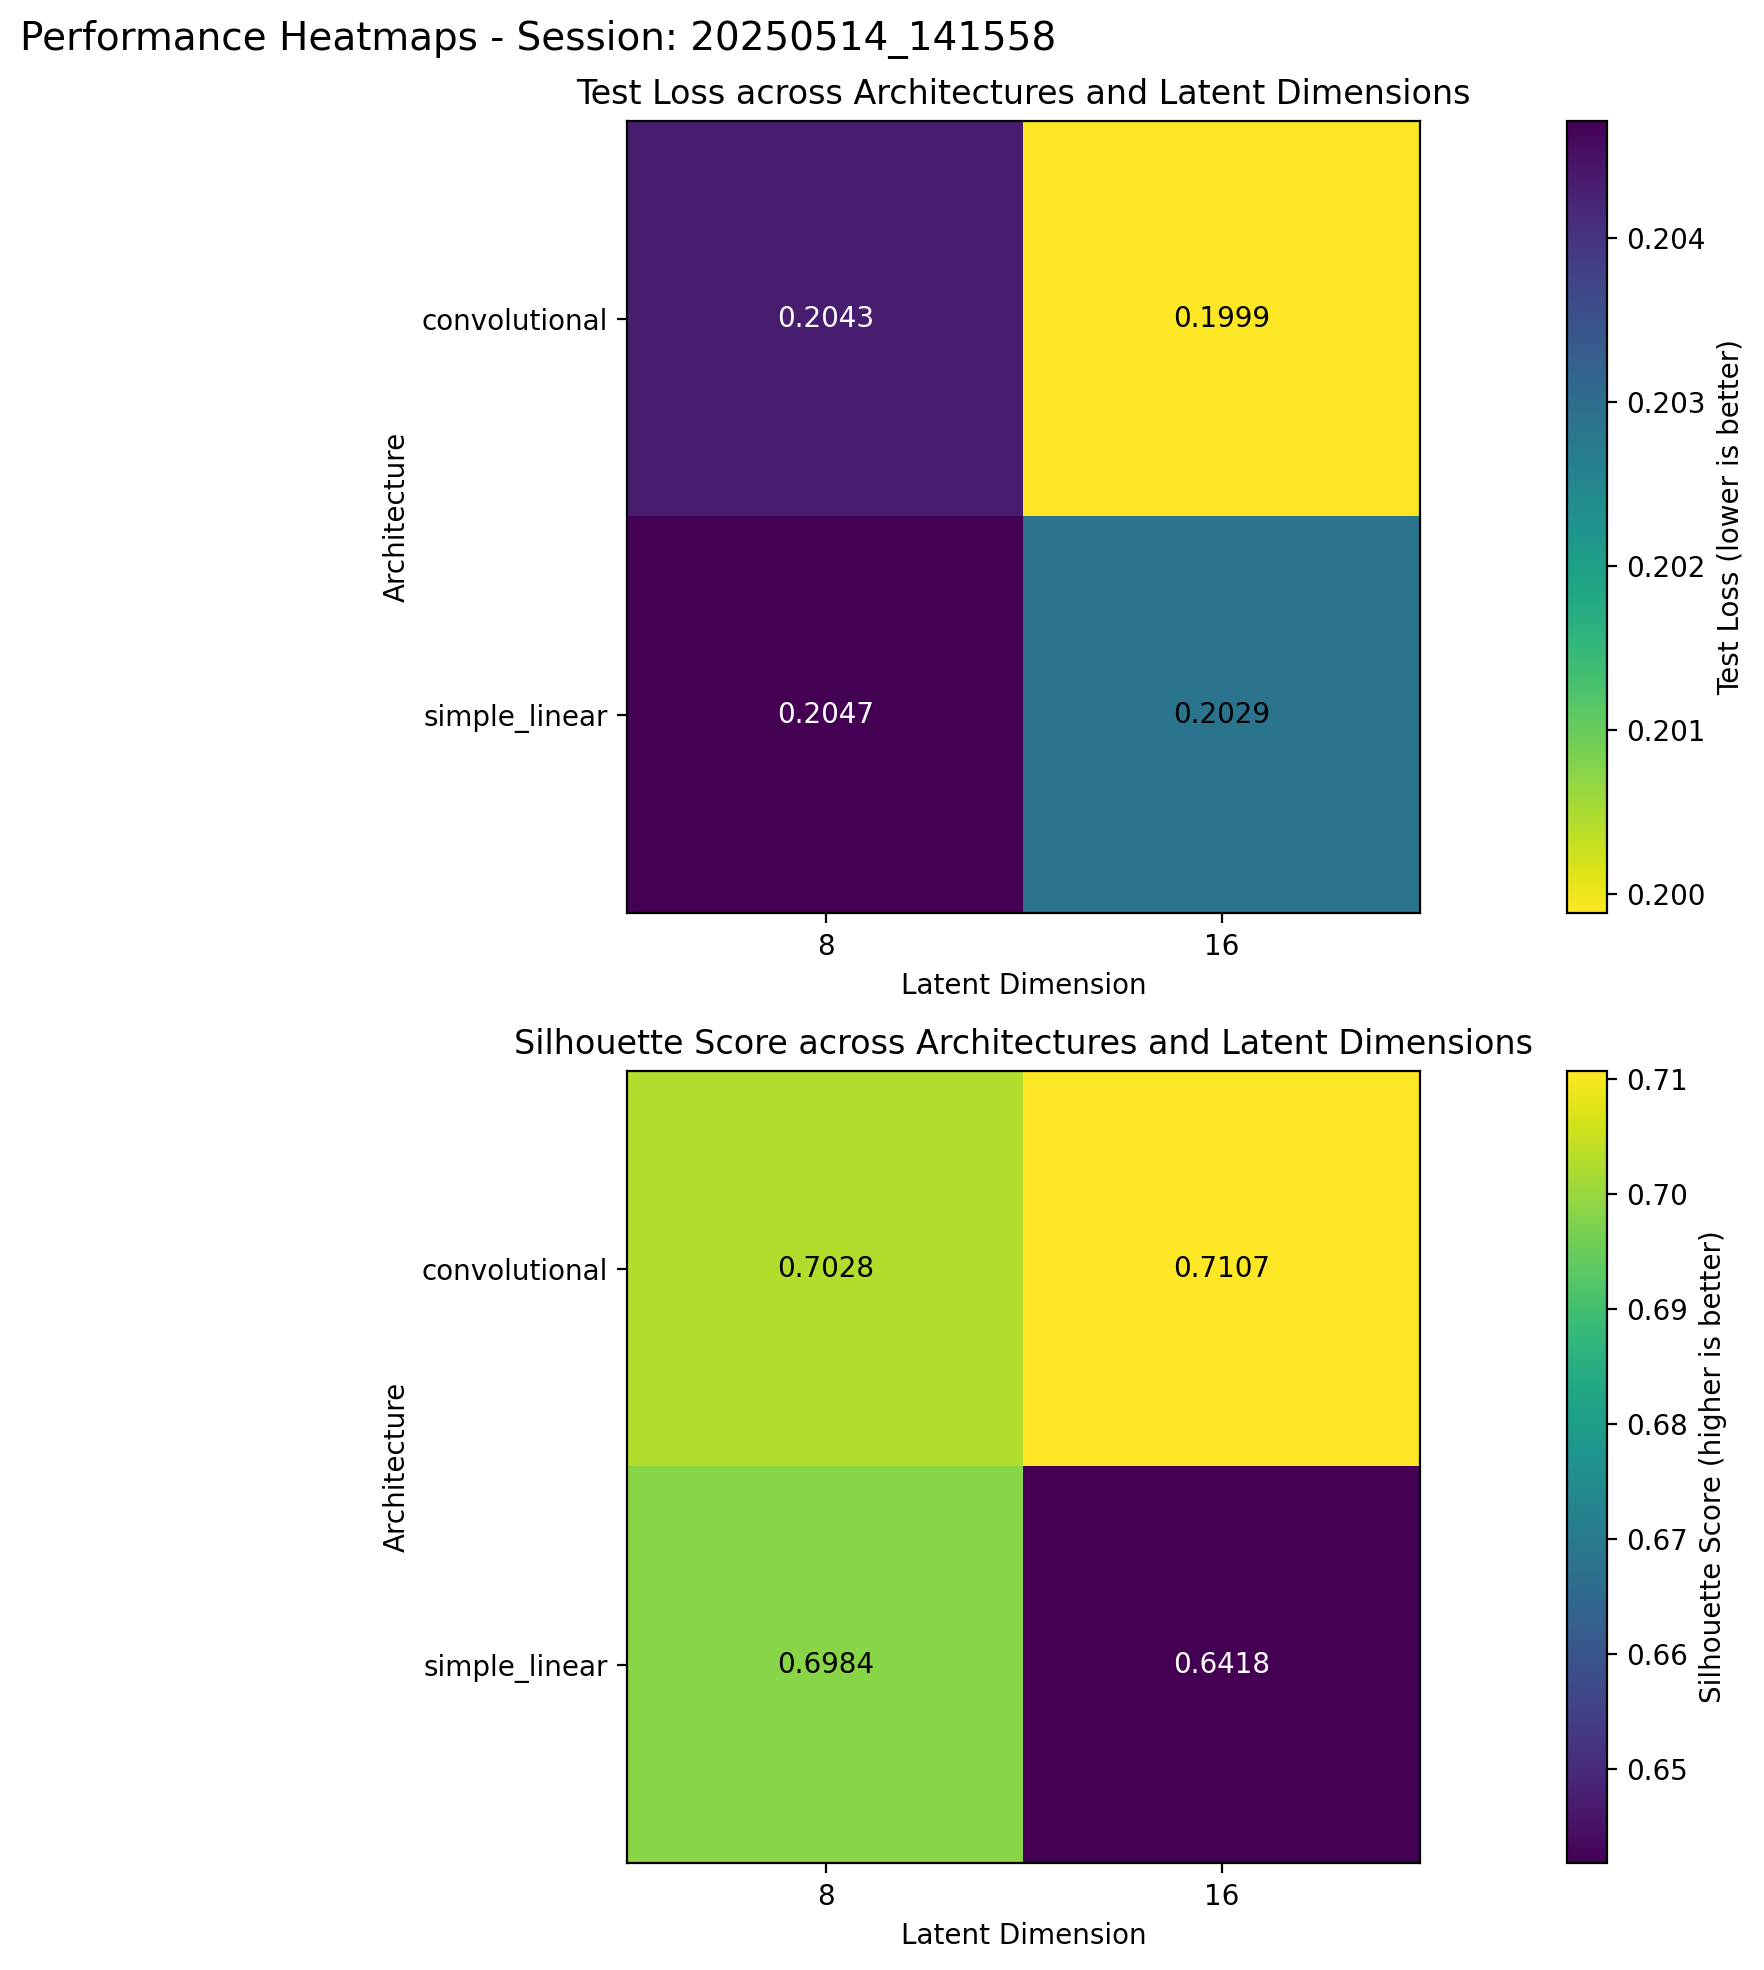


Generating comprehensive visualizations for each model...

Visualizing model: convolutional_16d_20250514_135025_model
Architecture: convolutional, Latent Dim: 16
Generating reconstruction visualizations...


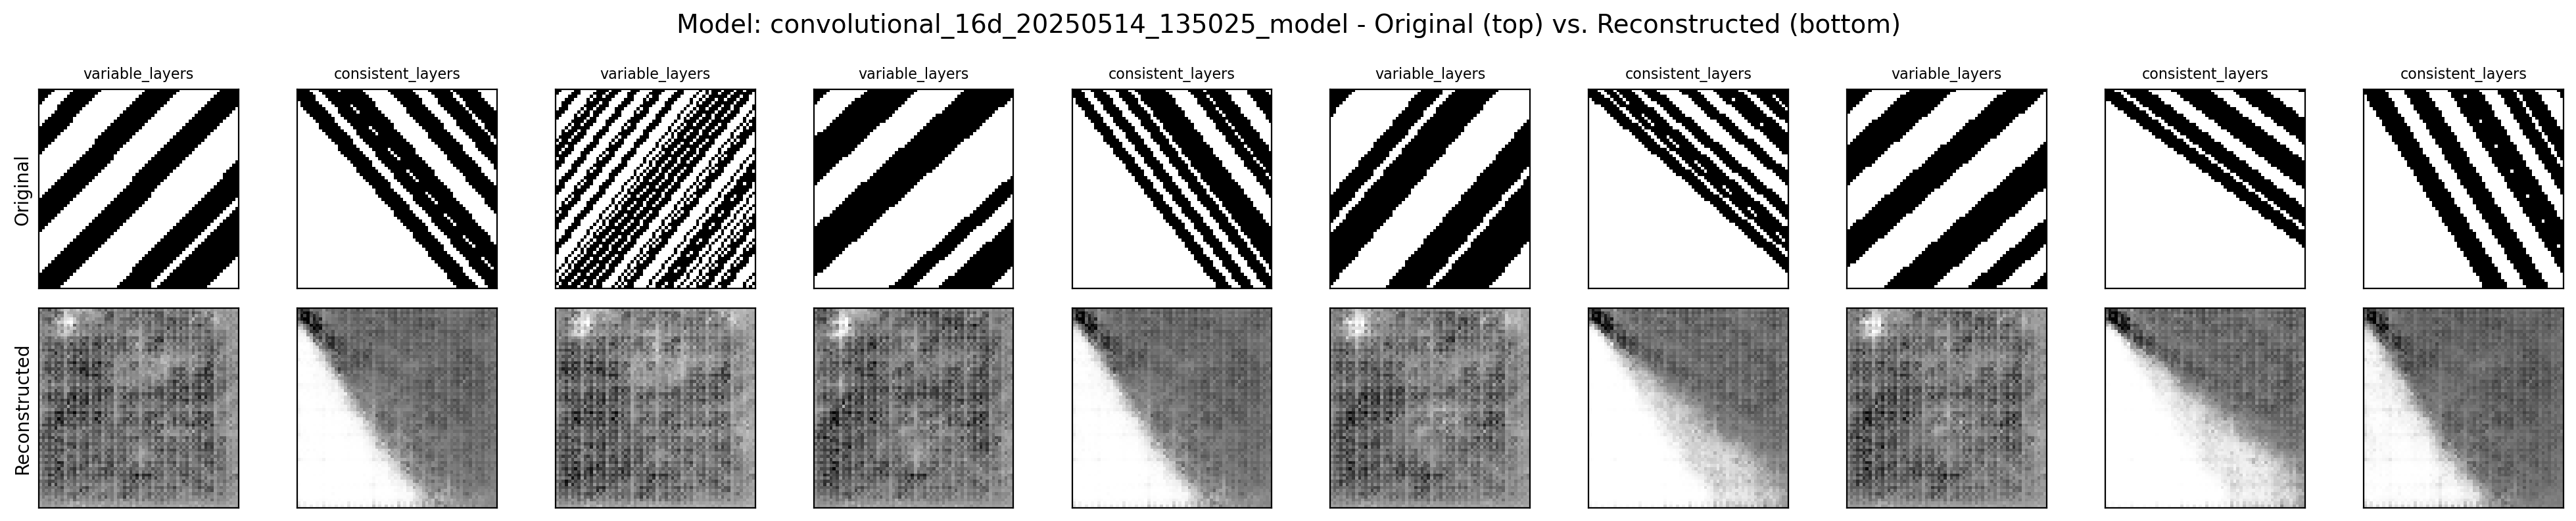

Generating train vs. test reconstruction comparison...


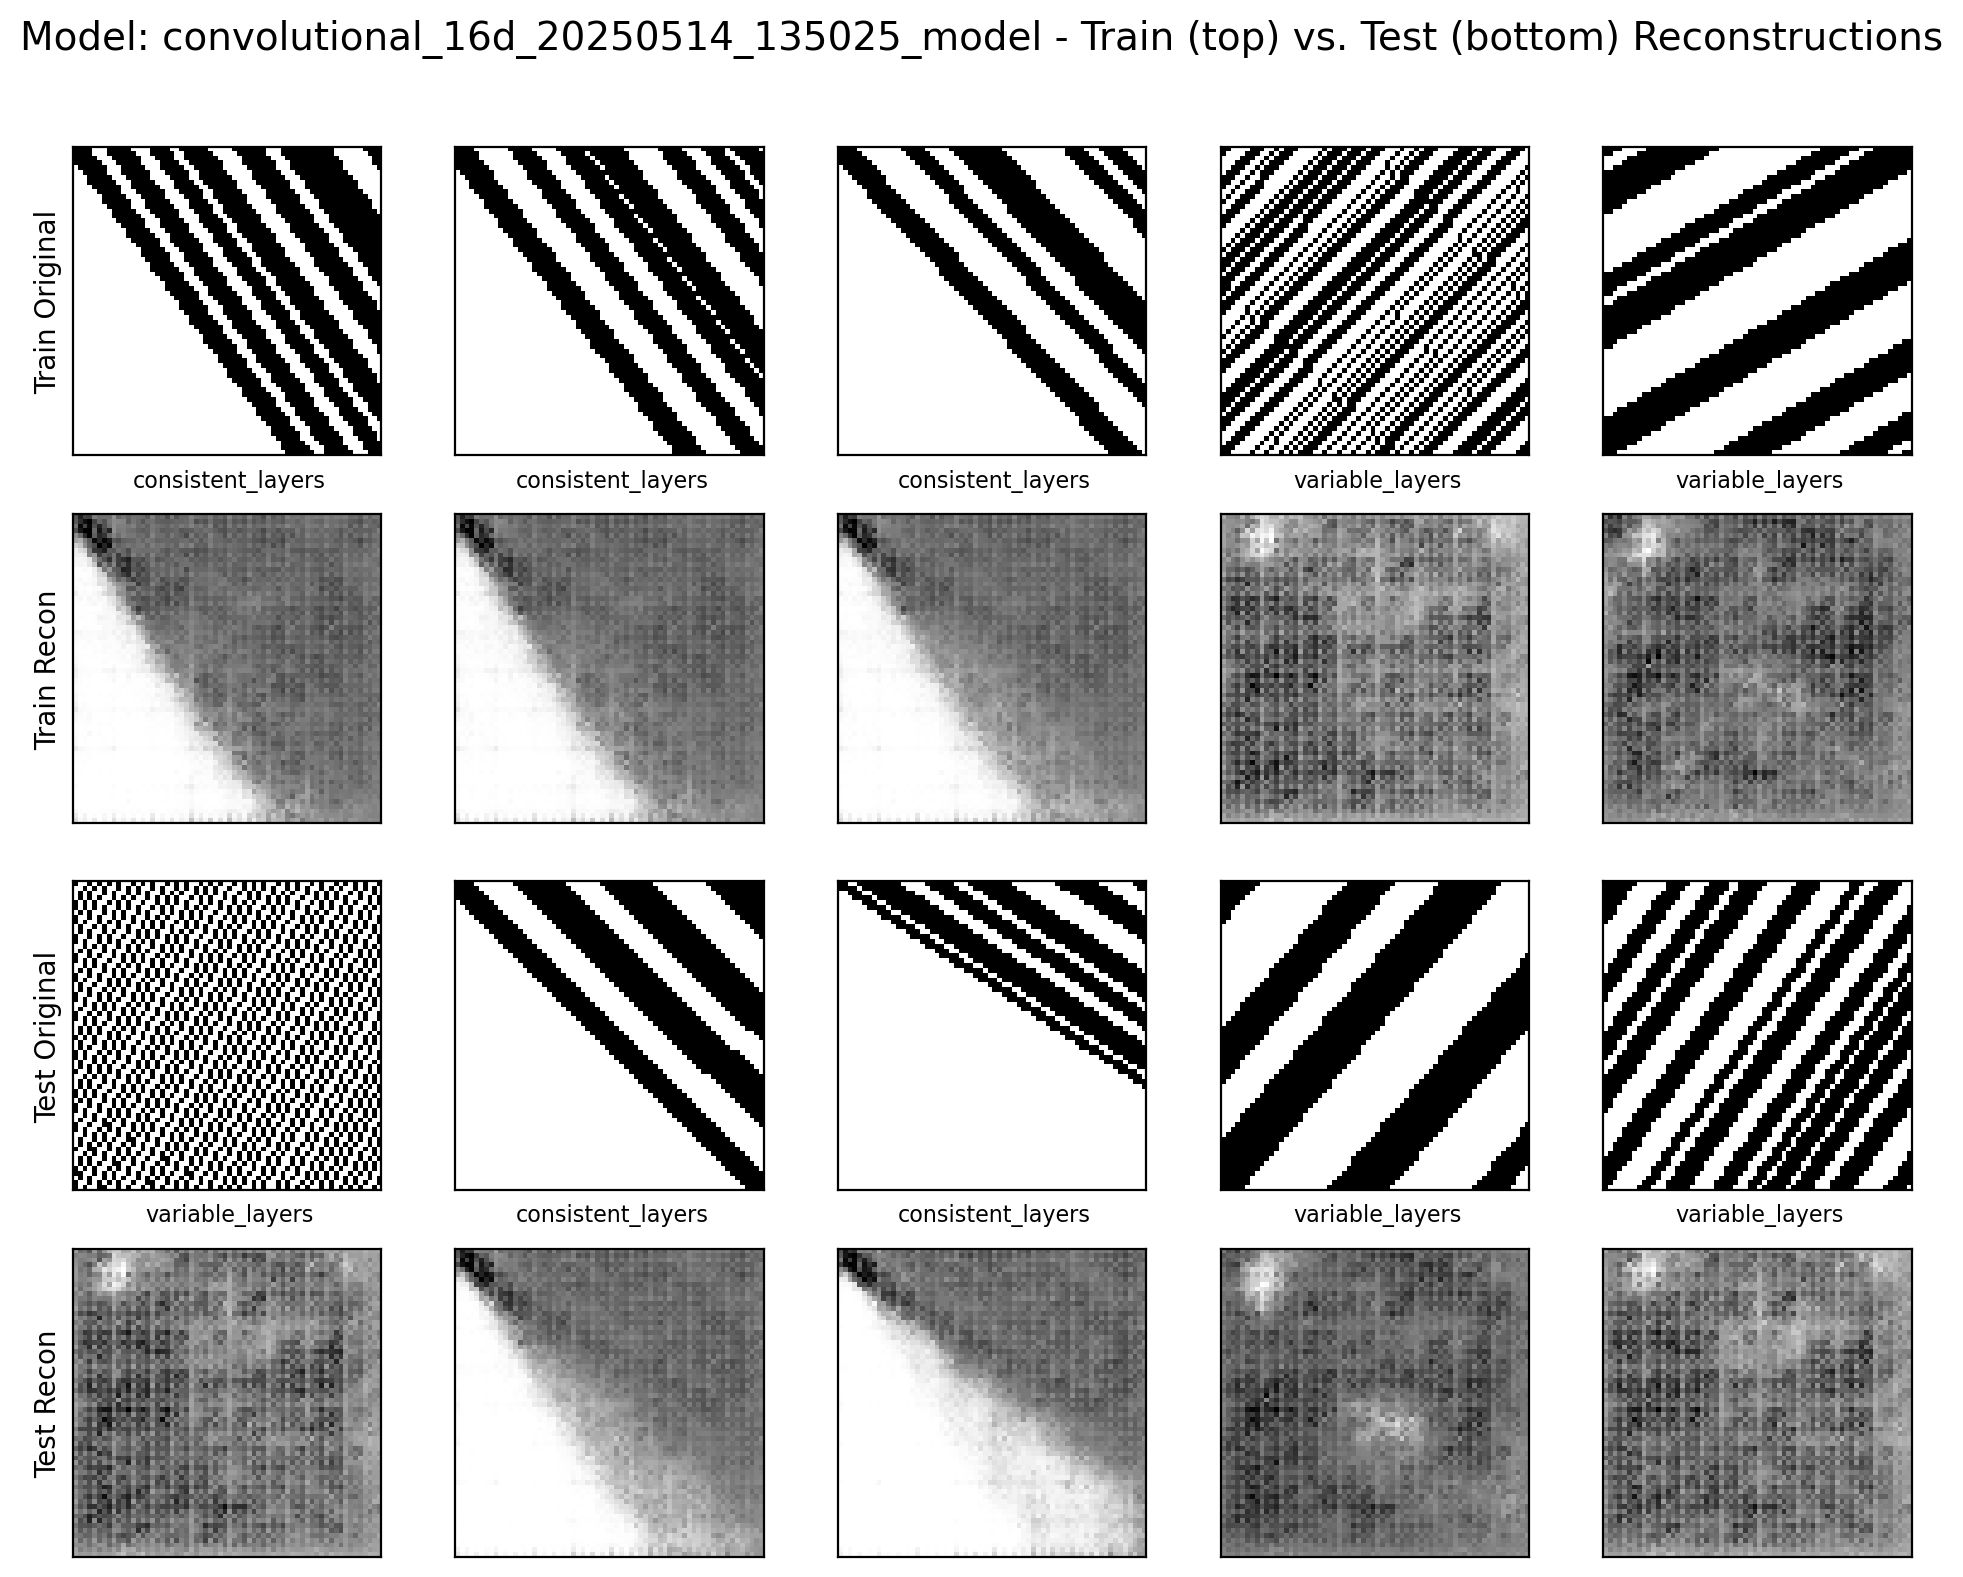

Generating latent space visualizations...
Train t-SNE Silhouette Score: 0.8863
Test t-SNE Silhouette Score: 0.8761


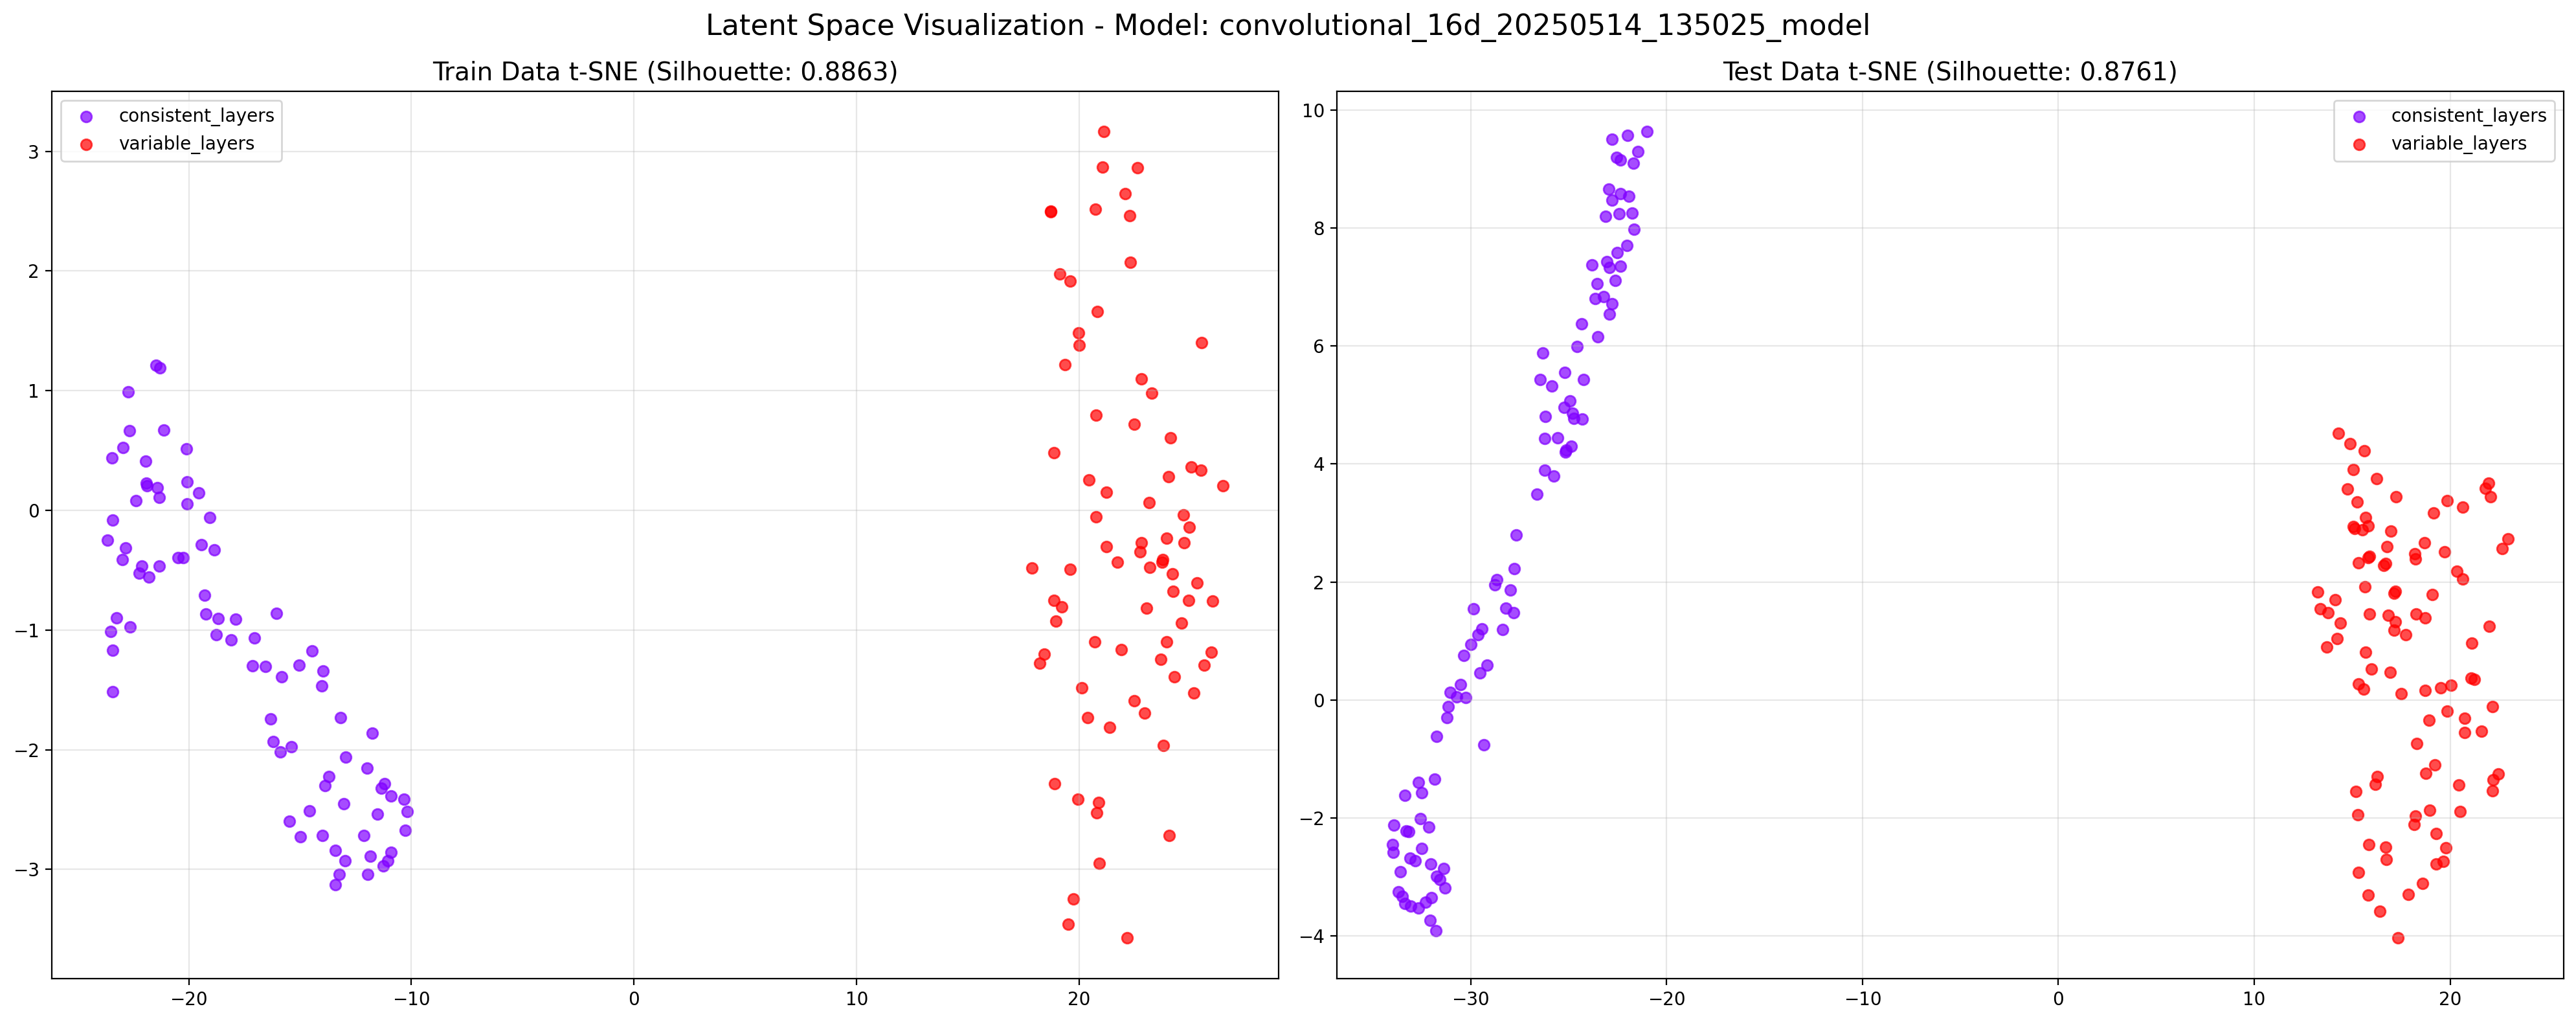


Visualizing model: convolutional_8d_20250514_135025_model
Architecture: convolutional, Latent Dim: 8
Generating reconstruction visualizations...


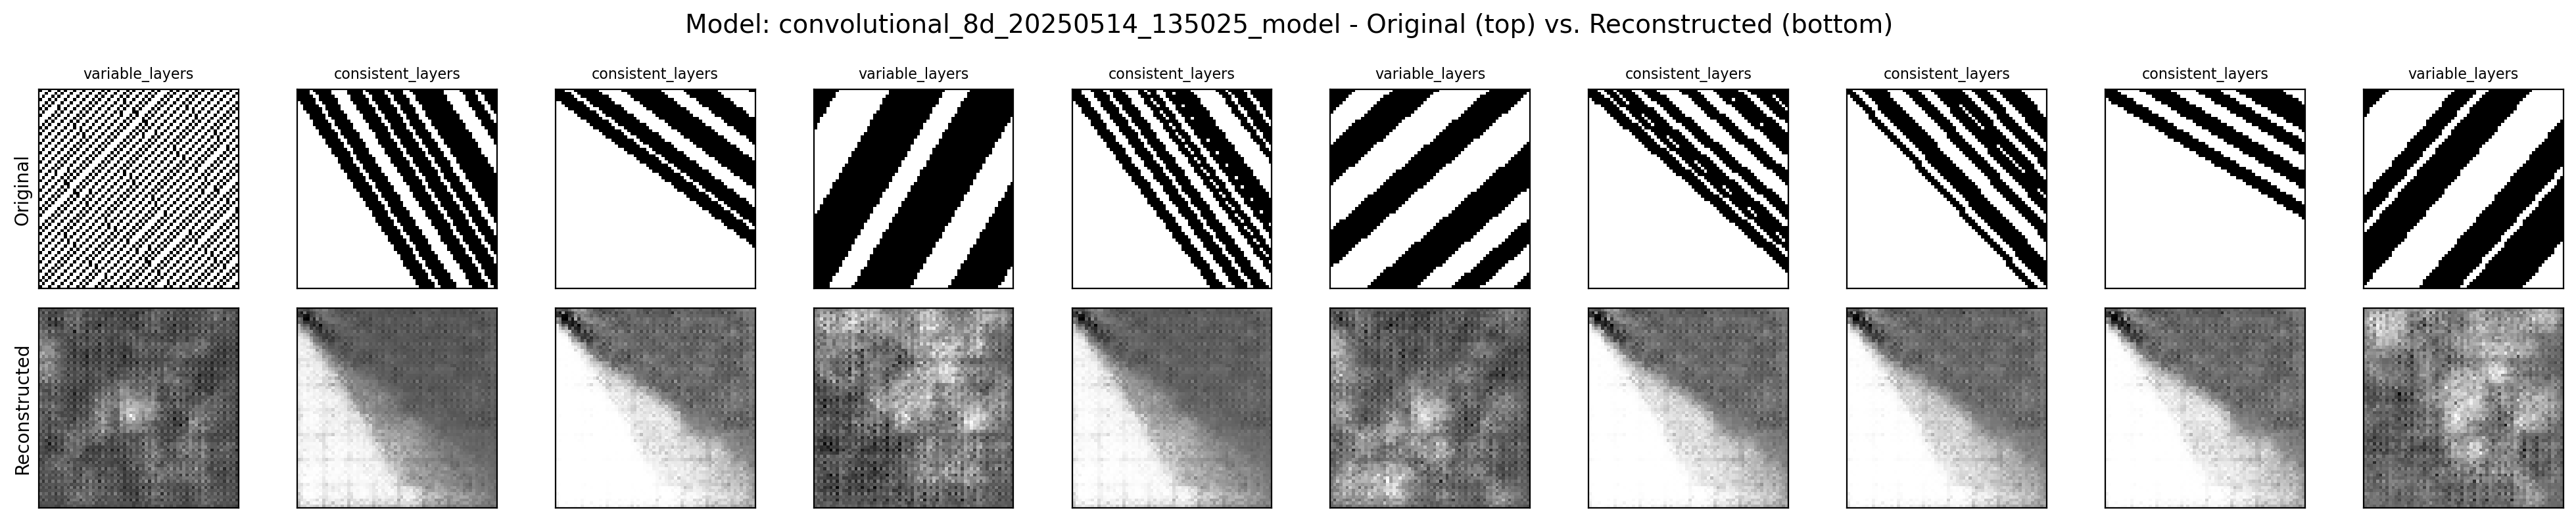

Generating train vs. test reconstruction comparison...


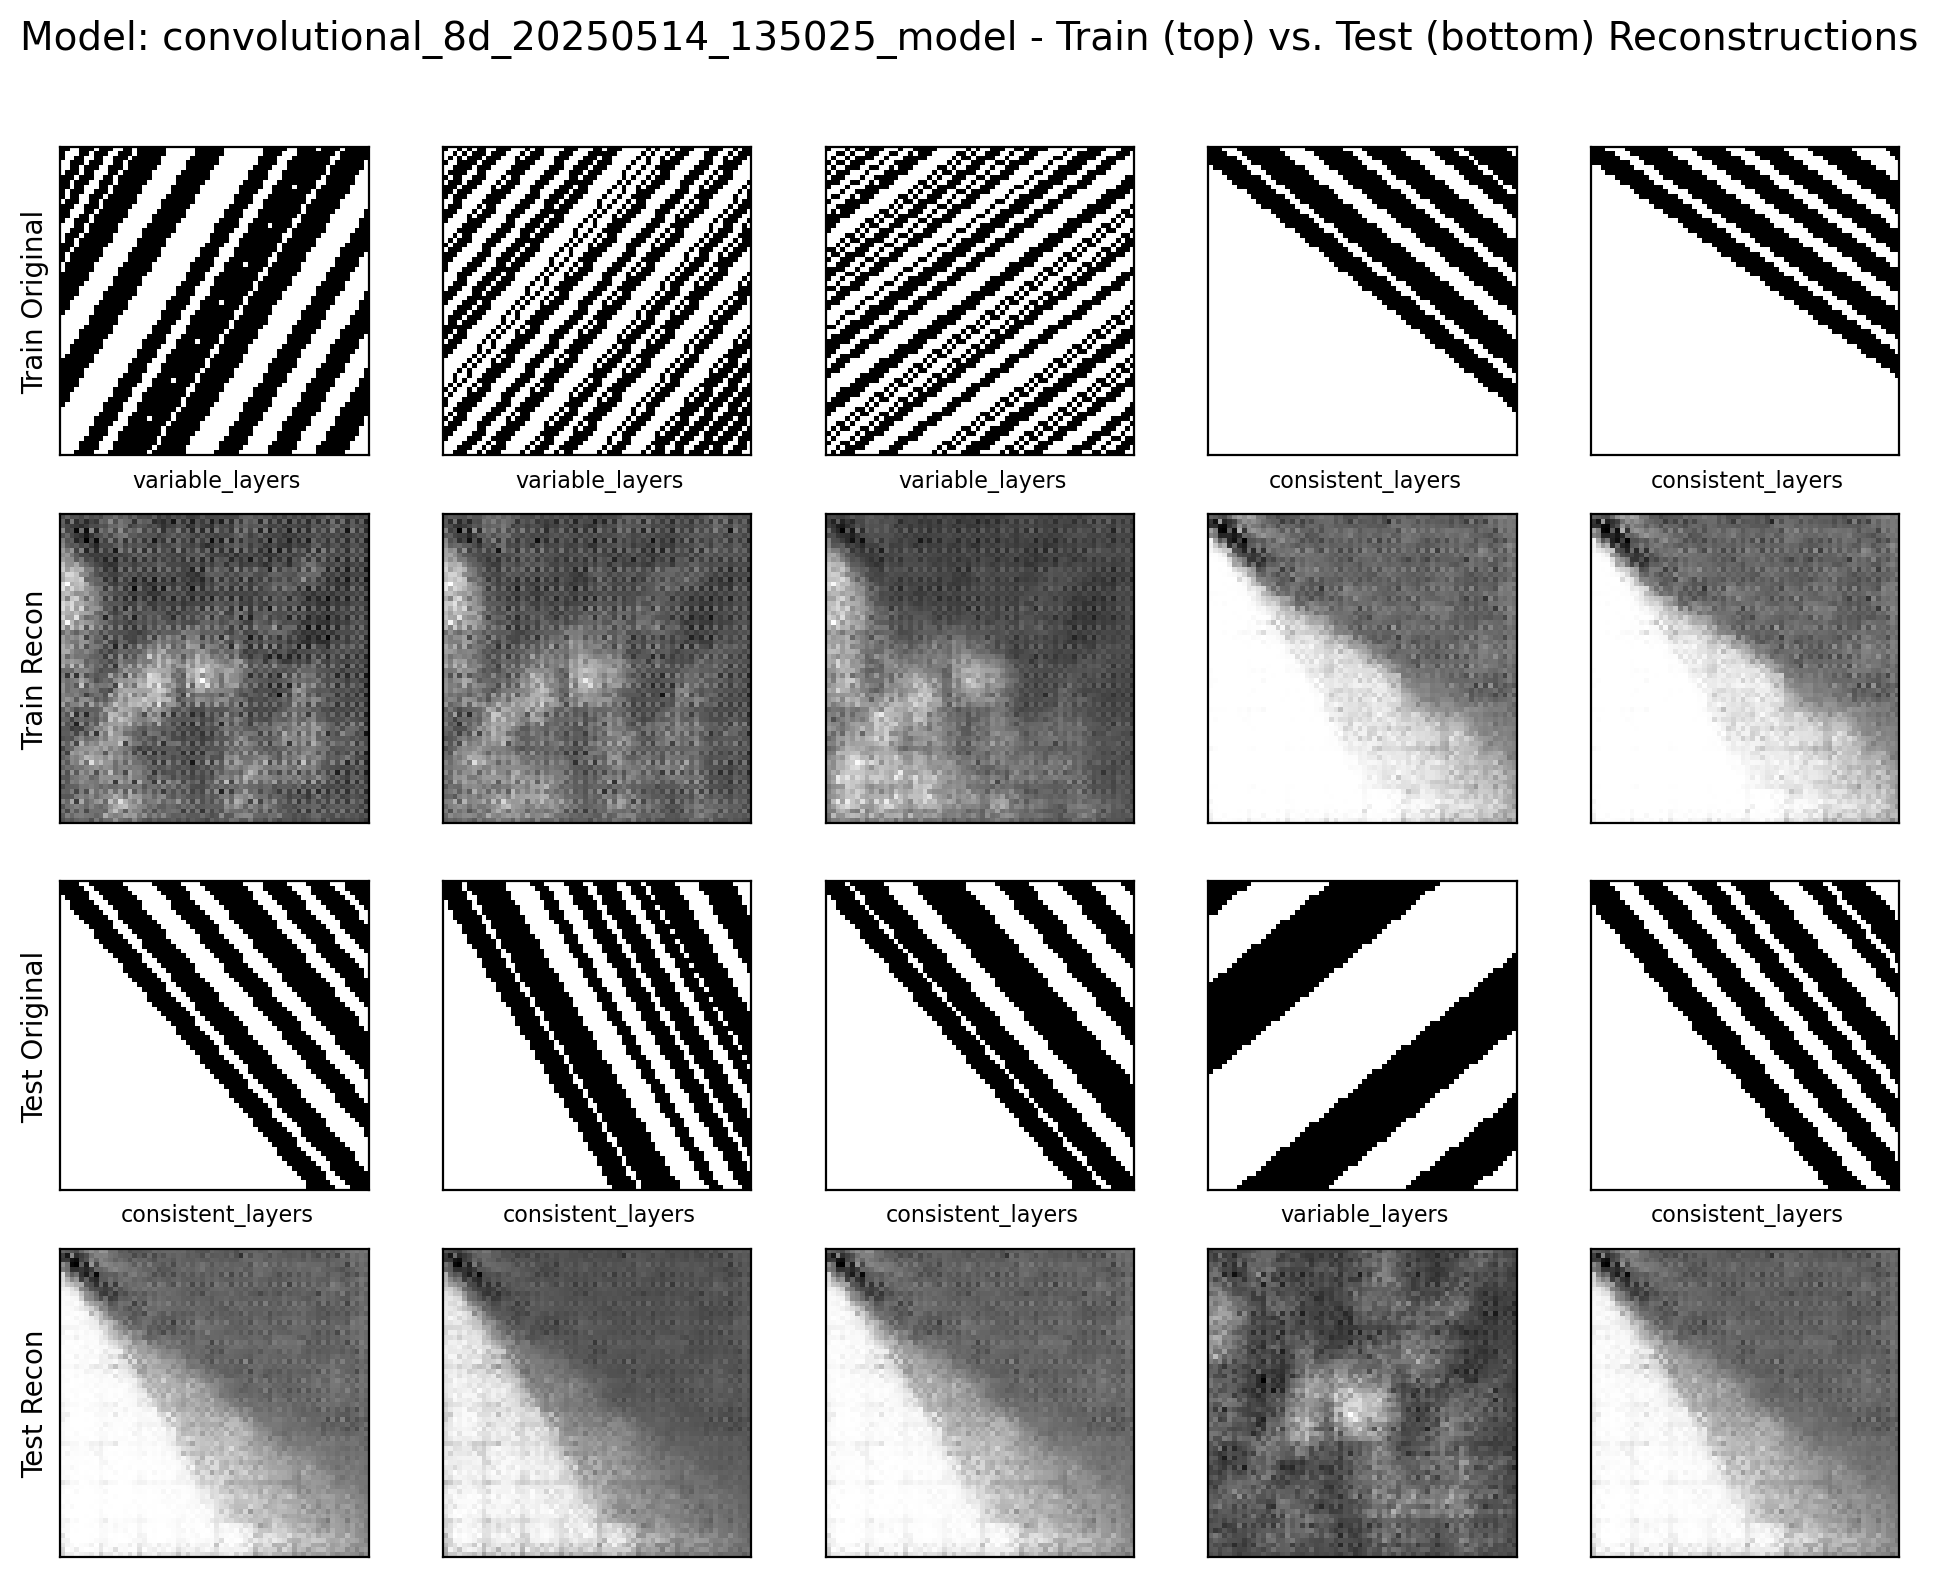

Generating latent space visualizations...
Train t-SNE Silhouette Score: 0.8024
Test t-SNE Silhouette Score: 0.8327


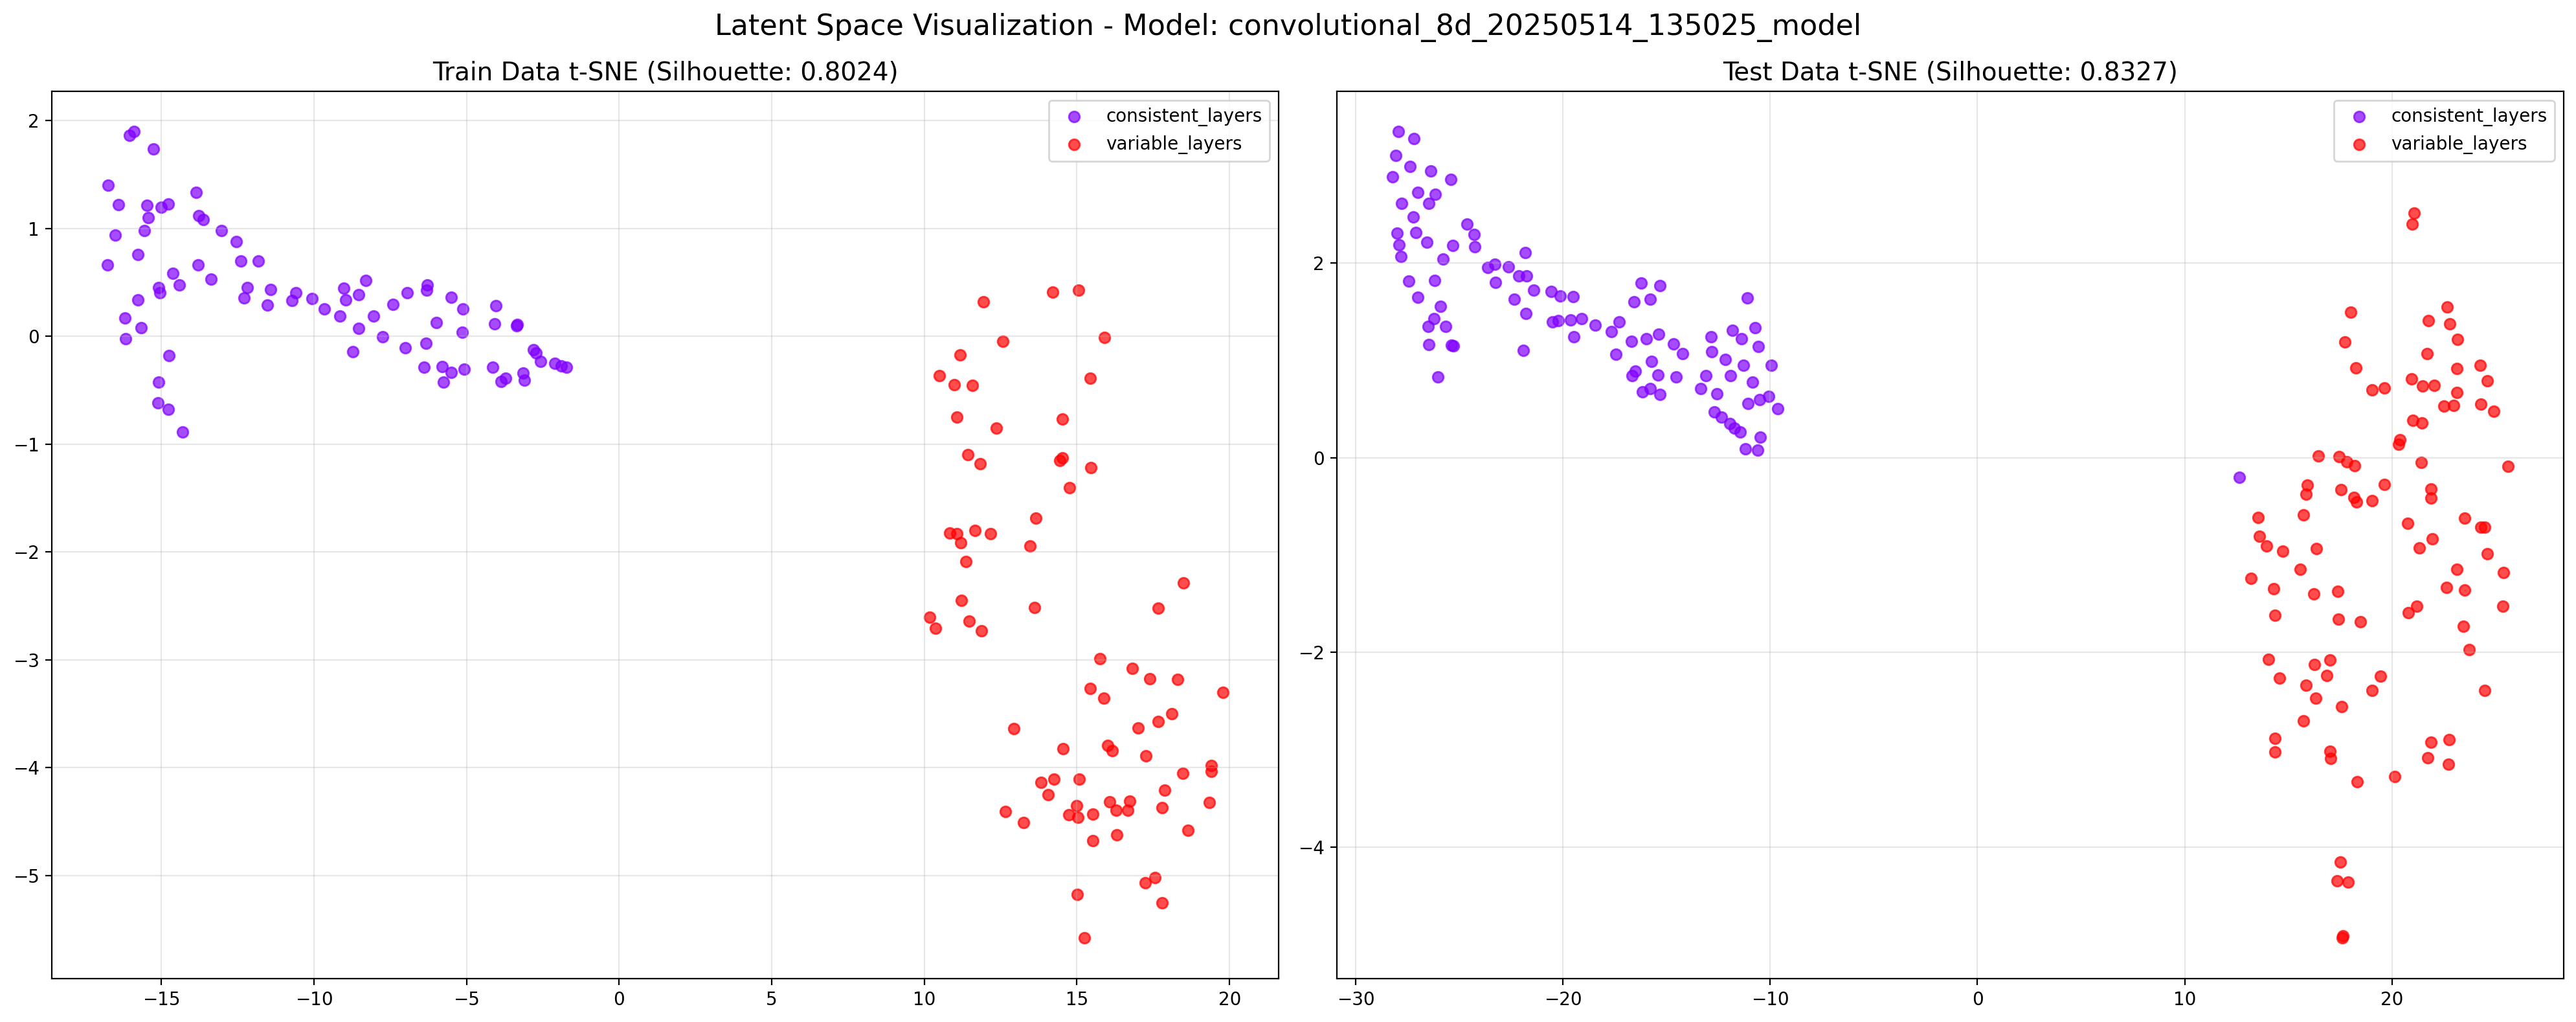


Visualizing model: simple_linear_16d_20250514_135025_model
Architecture: simple_linear, Latent Dim: 16
Generating reconstruction visualizations...


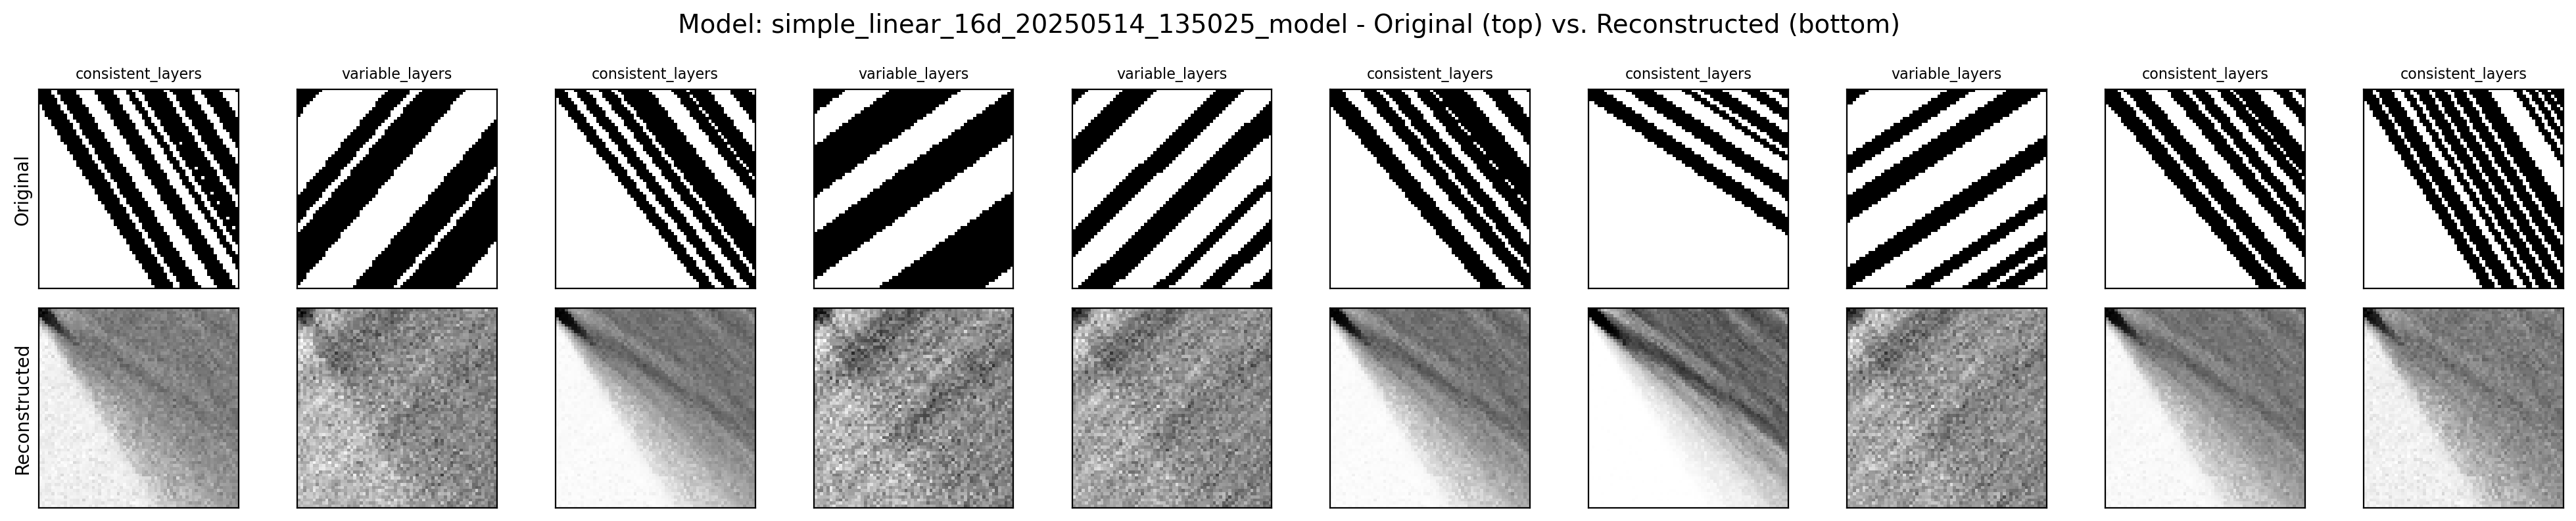

Generating train vs. test reconstruction comparison...


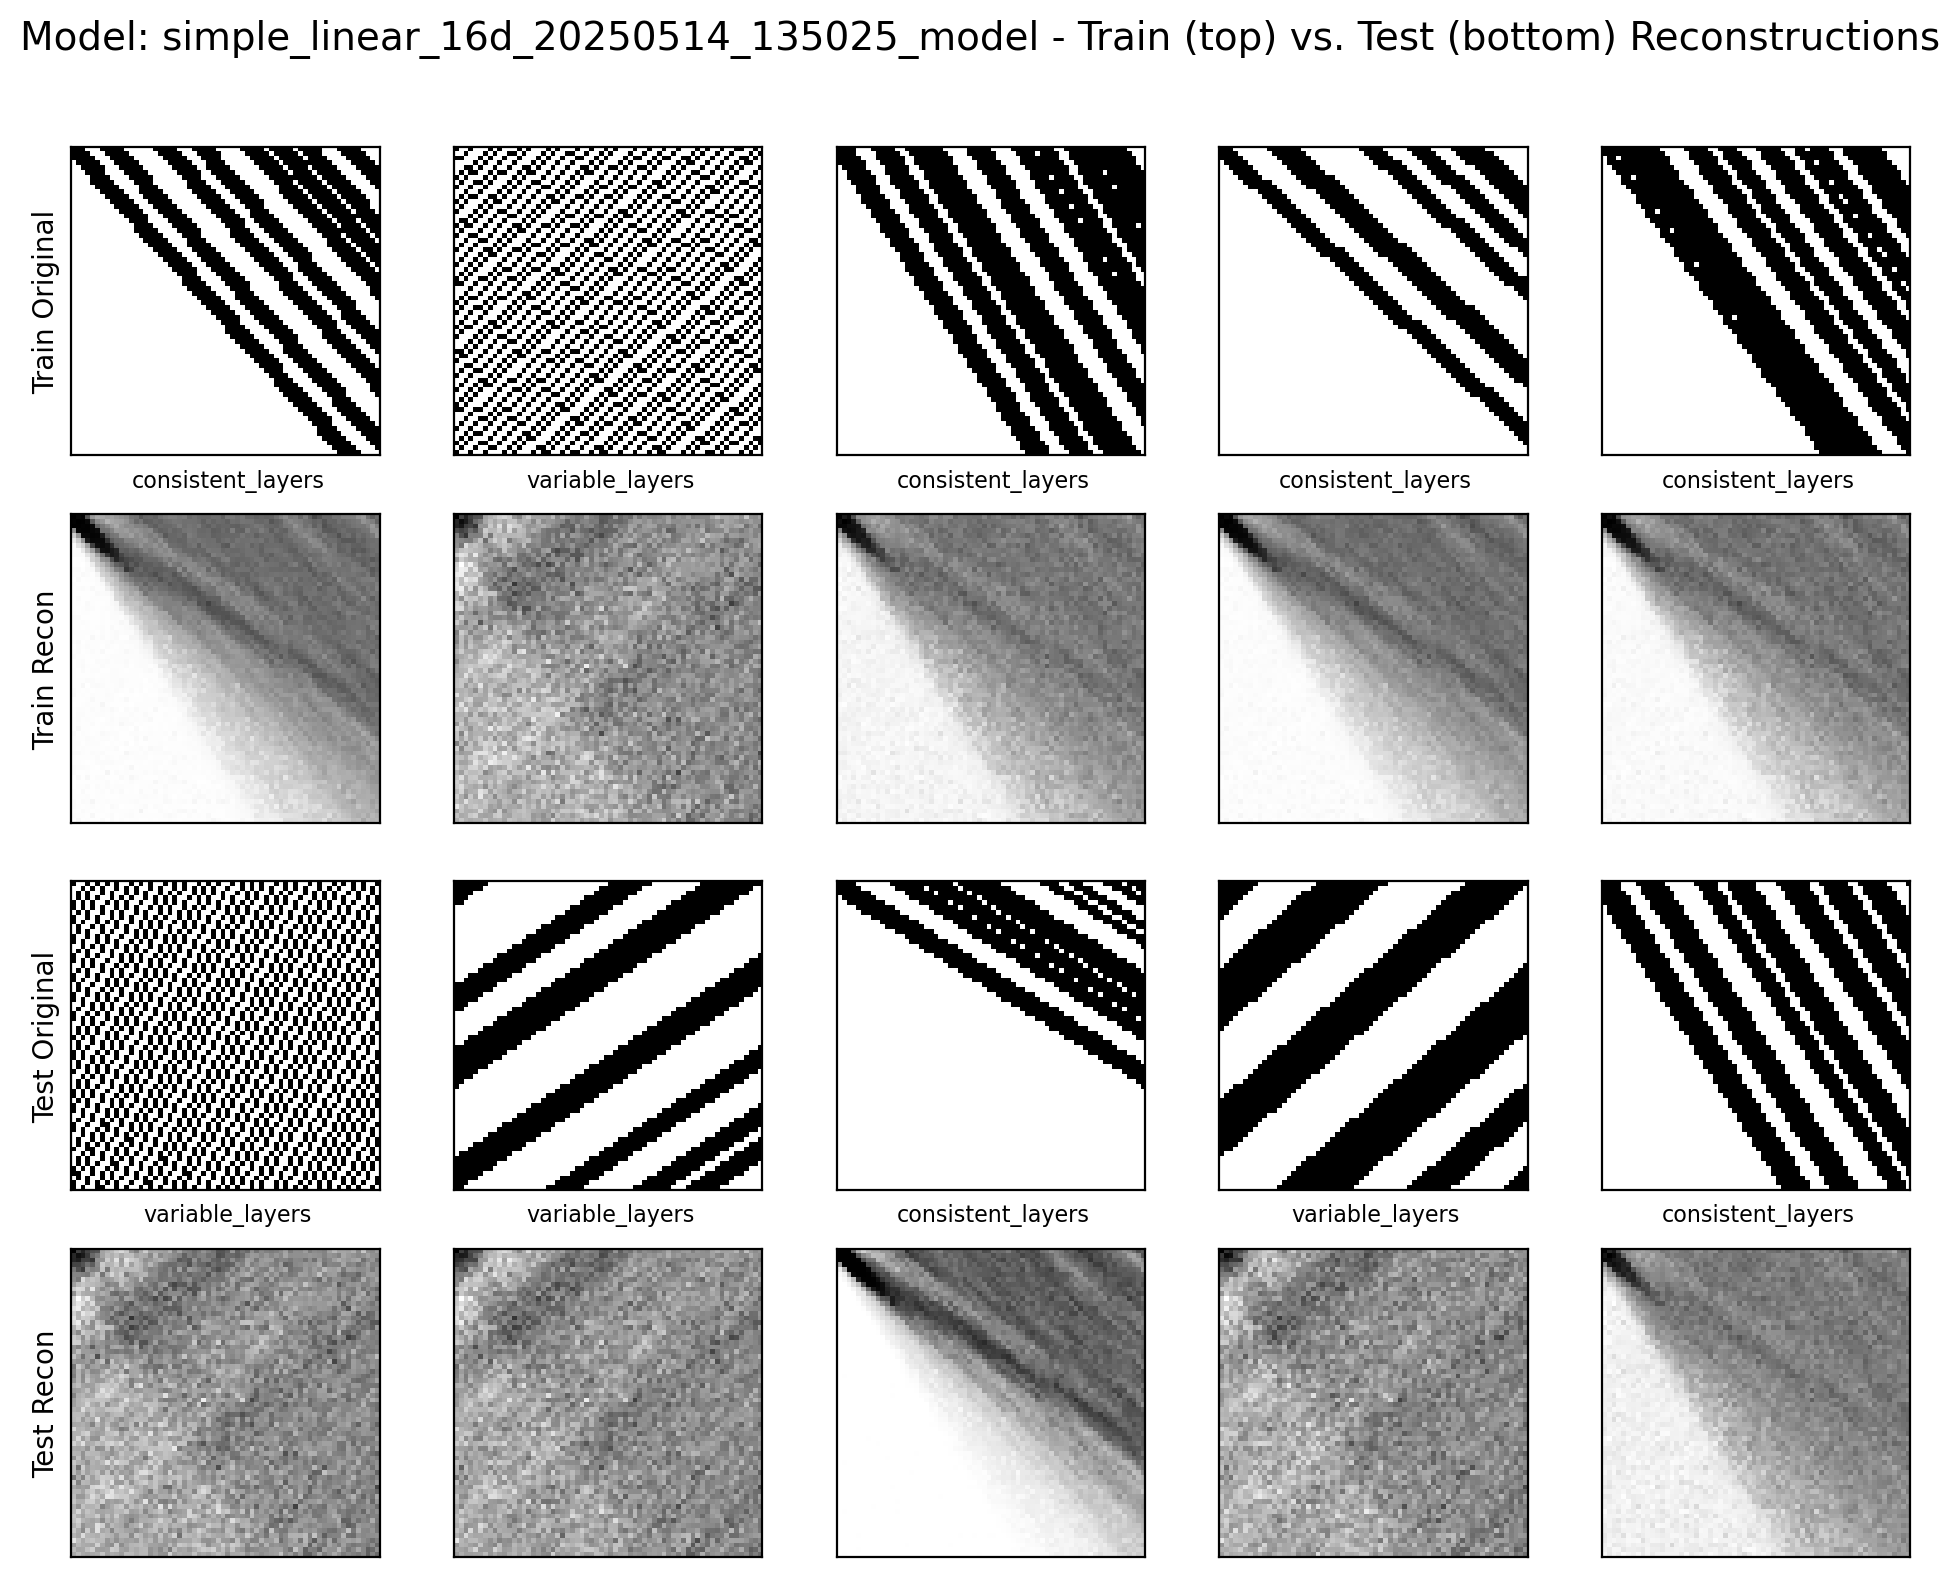

Generating latent space visualizations...
Train t-SNE Silhouette Score: 0.7590
Test t-SNE Silhouette Score: 0.8459


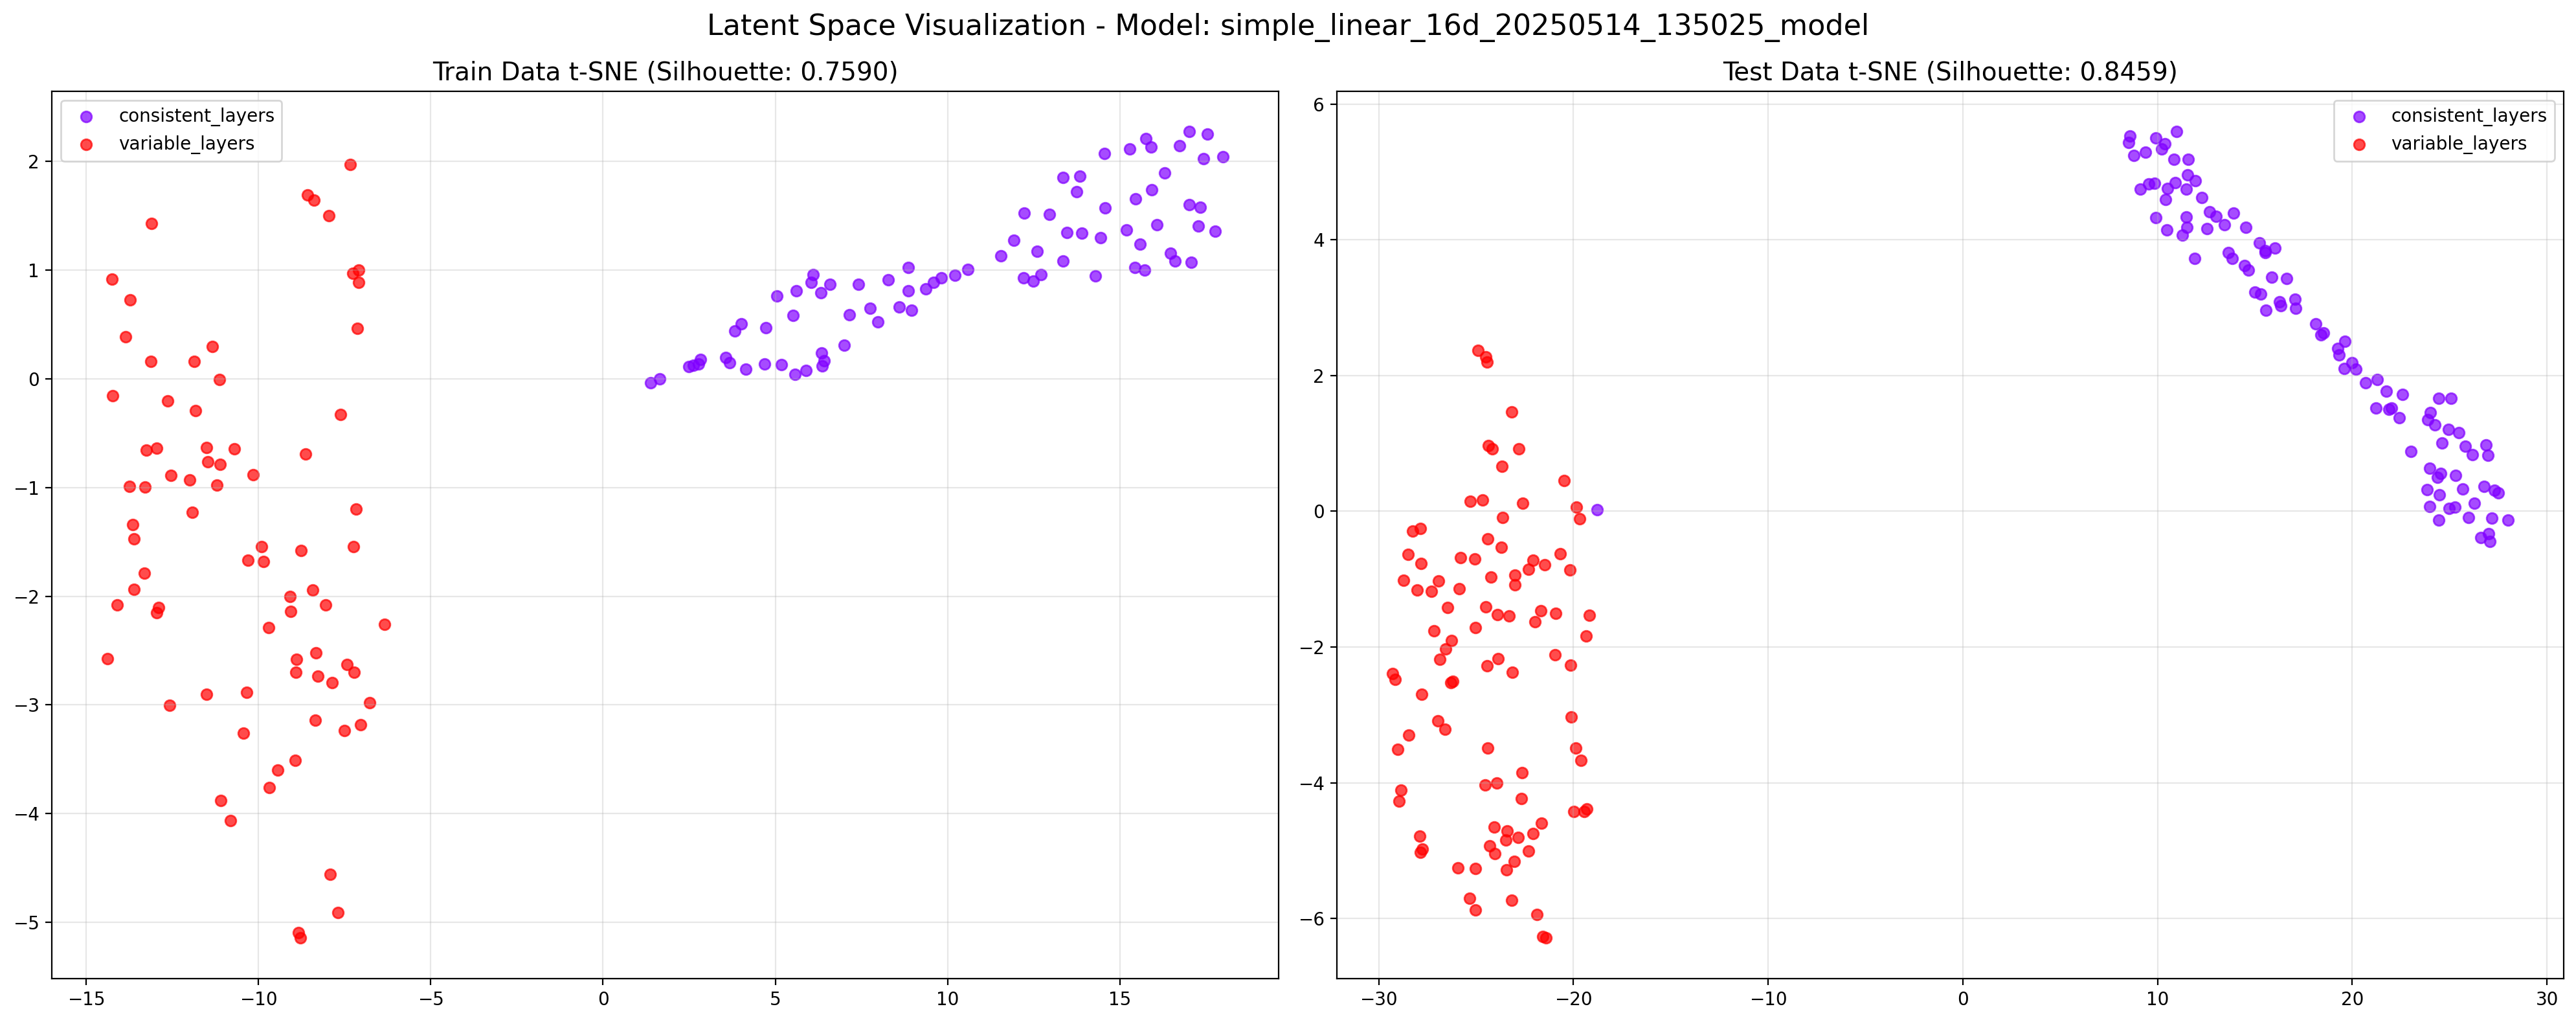


Visualizing model: simple_linear_8d_20250514_135025_model
Architecture: simple_linear, Latent Dim: 8
Generating reconstruction visualizations...


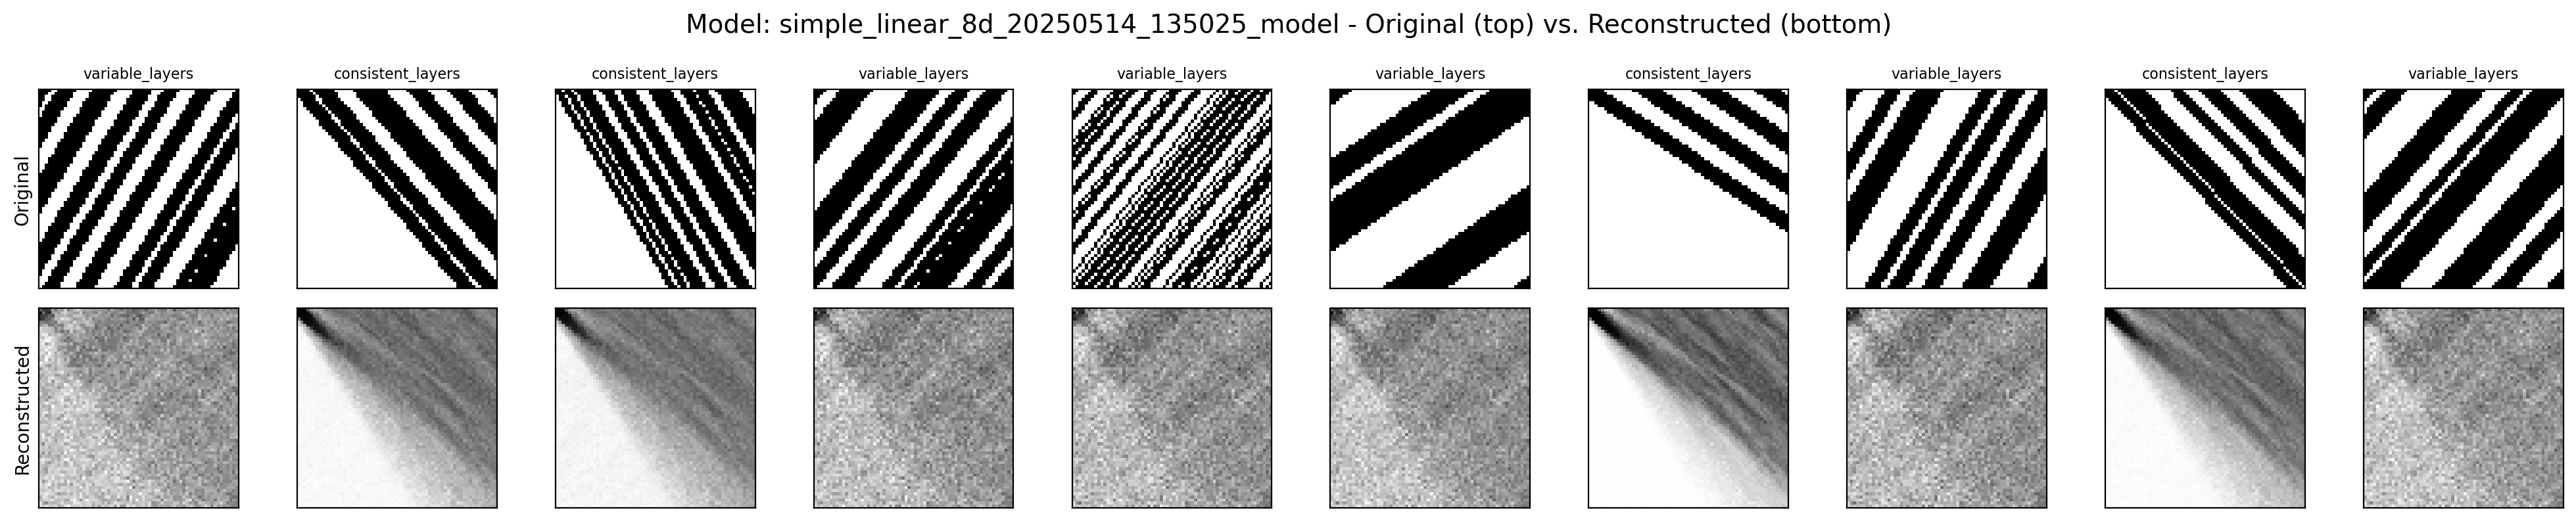

Generating train vs. test reconstruction comparison...


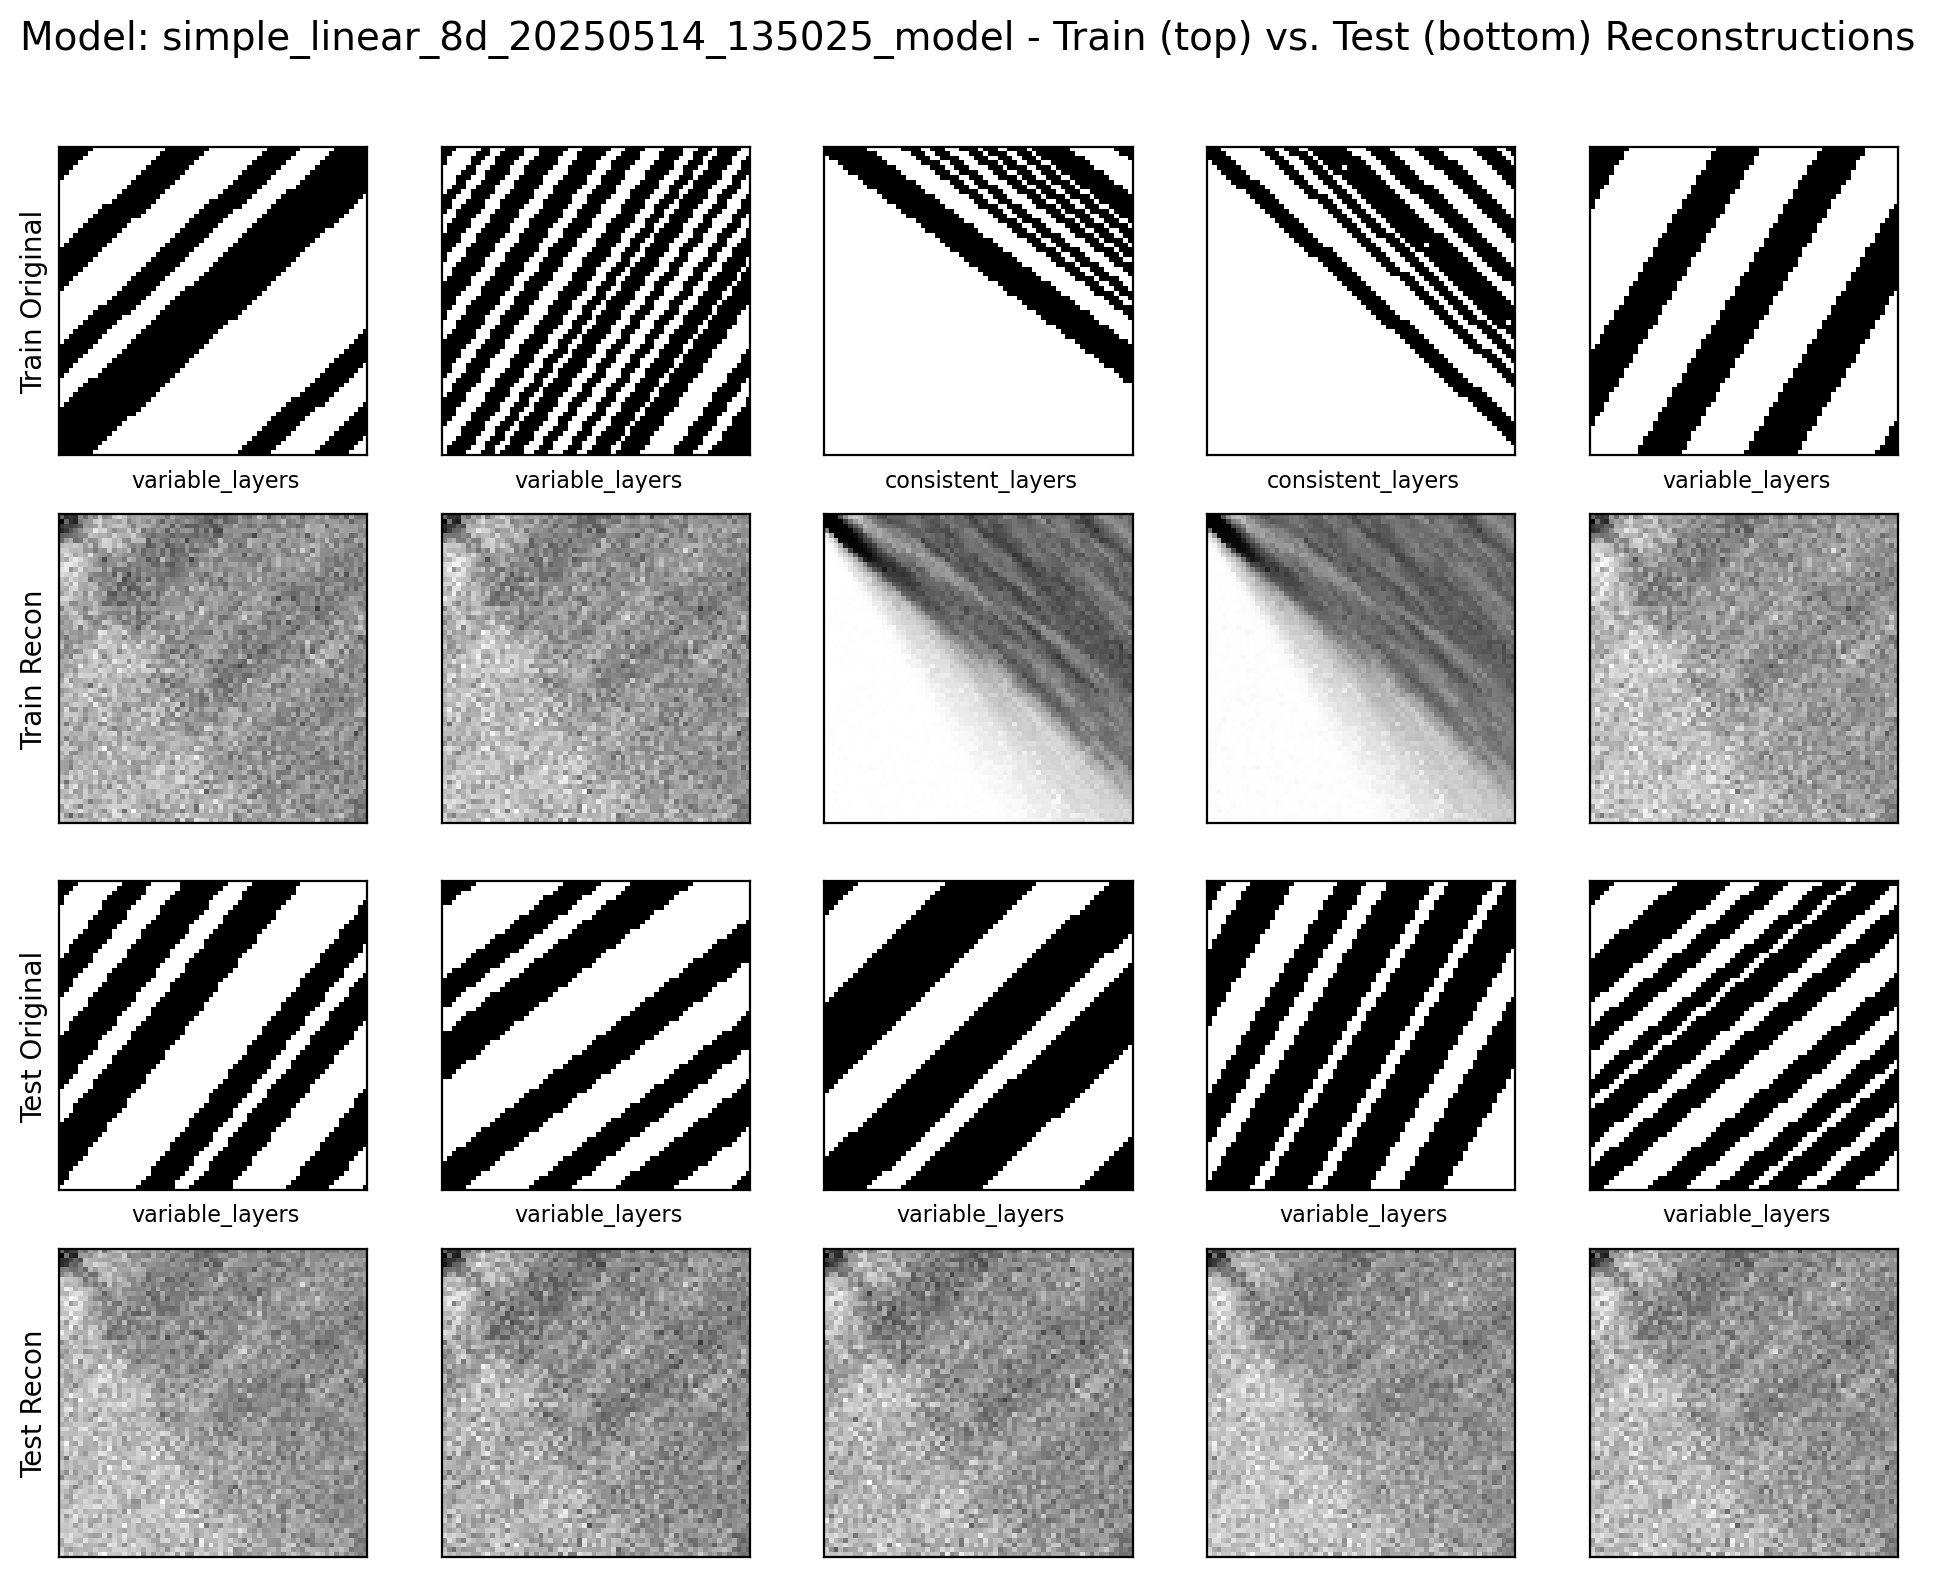

Generating latent space visualizations...
Train t-SNE Silhouette Score: 0.7756
Test t-SNE Silhouette Score: 0.8421


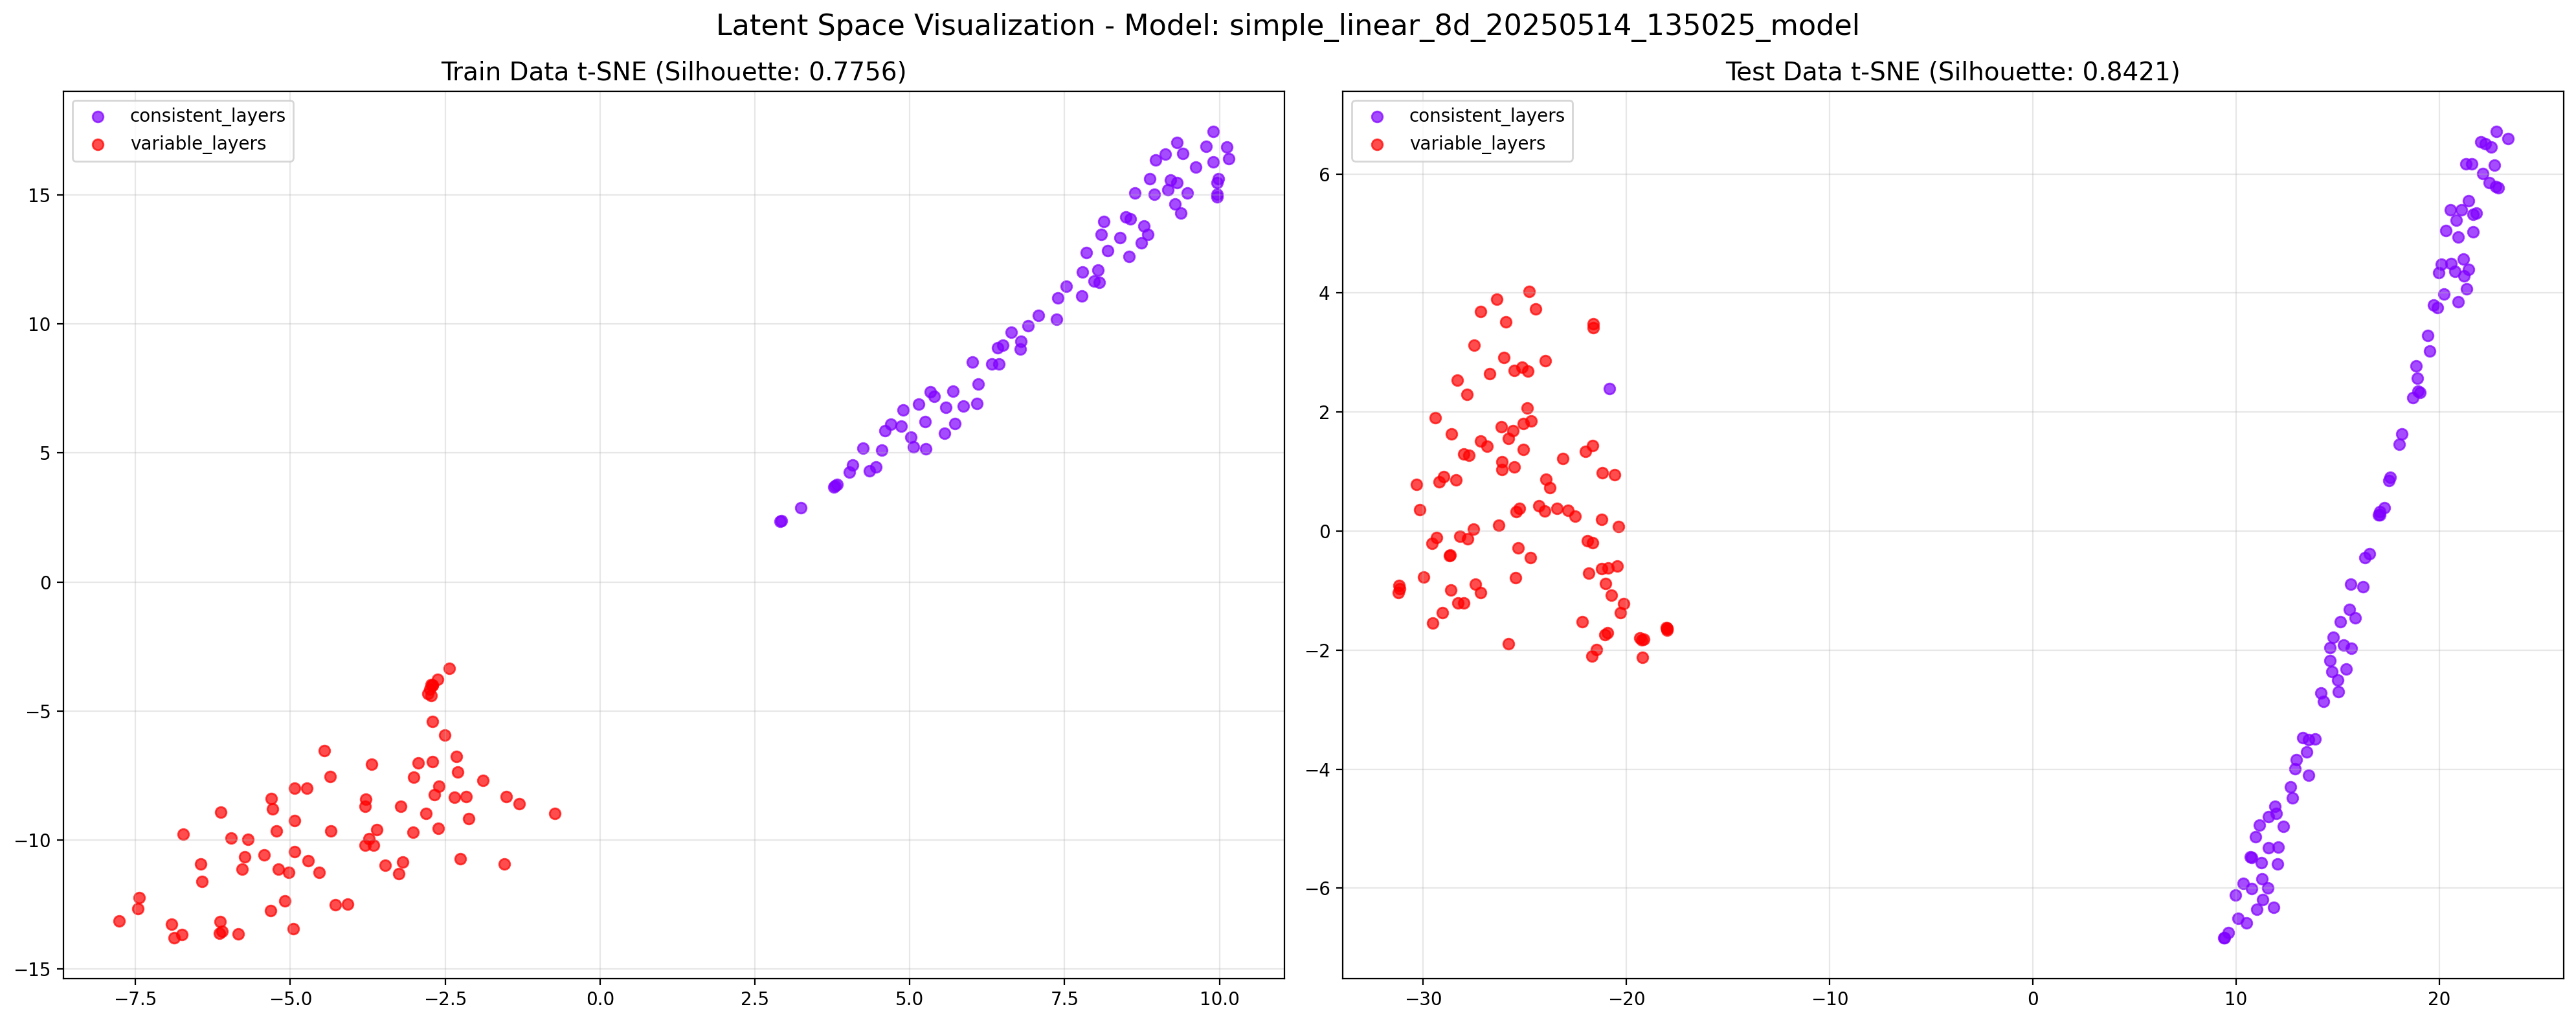


Analysis complete.


In [56]:
# Create an experiment manager for loading and analyzing saved models
analysis_config = {
    'dataset_path': 'layered_geologic_patterns_dataset/dataset_info.npy',
    'output_dir': 'latent_dim_exploration_results_layered_geology'
}

# Initialize the experiment manager
analysis_manager = ExperimentManager(analysis_config)

# Load and prepare the dataset (needed for proper model evaluation)
analysis_manager.prepare_data()

# Get the timestamp from any recently run experiment
# You would typically know this from previous runs
# For this example, let's use the timestamp from the study manager we just created
try:
    # If the previous cell was run, use its timestamp 
    recent_timestamp = study_manager.session_timestamp
    print(f"Using timestamp from previous run: {recent_timestamp}")
except NameError:
    # If not, use a placeholder - you would replace this with your actual timestamp
    recent_timestamp = None
    print("No recent timestamp found. Loading all available models.")

# Load all models with the matching timestamp
# If timestamp is None, loads all models in the output directory
loaded_models = analysis_manager.load_models_by_timestamp(
    timestamp=recent_timestamp,
    output_dir='latent_dim_exploration_results_layered_geology'
)

# Check if we found any models
if loaded_models:
    # Create comparison table of loaded models
    comparison_df = analysis_manager.create_comparison_table()
    print("\nLoaded Models Comparison:")
    display(comparison_df)  # For nicer display in Jupyter
    
    # Plot performance metrics
    print("\nGenerating performance visualization for loaded models...")
    # Organize results by architecture
    architecture_results = {}
    for model_name, model_data in loaded_models.items():
        architecture = model_data['architecture']
        if architecture not in architecture_results:
            architecture_results[architecture] = []
        
        architecture_results[architecture].append({
            'model': model_data['model'],
            'history': model_data['history'],
            'results': model_data['results'],
            'latent_dim': model_data['latent_dim'],
            'experiment_name': model_name
        })
    
    # Generate comparison metrics plots if we have results to show
    if architecture_results:
        # Visualize reconstructions for each model
        for model_name, model_data in loaded_models.items():
            print(f"\nVisualizing reconstructions for {model_name}...")
            model = model_data['model']
            
            # Visualize train reconstructions
            analysis_manager.wrapper.model = model
            analysis_manager.wrapper.visualize_reconstructions(
                samples=analysis_manager.train_data[:10],
                labels=analysis_manager.train_labels[:10] if hasattr(analysis_manager, 'train_labels') else None,
                n_samples=10
            )
            
            # Visualize test reconstructions
            analysis_manager.wrapper.visualize_reconstructions(
                samples=analysis_manager.test_data[:10],
                labels=analysis_manager.test_labels[:10] if hasattr(analysis_manager, 'test_labels') else None,
                n_samples=10
            )
            
            # Visualize latent space
            analysis_manager.wrapper.visualize_latent_space(
                train_data=analysis_manager.train_data[:500],  # Limit to 500 samples to prevent memory issues
                train_labels=analysis_manager.train_labels[:500] if hasattr(analysis_manager, 'train_labels') else None,
                test_data=analysis_manager.test_data,
                test_labels=analysis_manager.test_labels if hasattr(analysis_manager, 'test_labels') else None
            )
        
        # Plot comparison metrics
        analysis_manager.plot_comparison_metrics(architecture_results)
    else:
        print("No architecture results to visualize.")
else:
    print("No models found for analysis.")
    
print("\nAnalysis complete.")

## Example 4: Using a Custom Model Architecture

This example demonstrates defining a custom model architecture and using it with the experiment system:

In [ ]:
# Define a new custom model architecture - here we'll create a denoising autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_size=64*64, latent_dim=16):
        super(DenoisingAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, input_size),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 64, 64))  # Reshape back to image dimensions
        )
    
    def add_noise(self, x, noise_factor=0.25):
        # Add random noise to the input
        noise = torch.randn_like(x) * noise_factor
        noisy_x = x + noise
        # Clip to ensure values stay in valid range [0,1]
        return torch.clamp(noisy_x, 0., 1.)
    
    def forward(self, x):
        # Add noise to input (only during training)
        if self.training:
            noisy_x = self.add_noise(x)
        else:
            noisy_x = x
            
        # Encode the noisy input
        encoded = self.encoder(noisy_x)
        
        # Decode to reconstruct the clean input
        decoded = self.decoder(encoded)
        
        return encoded, decoded

# Register the custom model
MODEL_ARCHITECTURES['denoising'] = DenoisingAutoencoder

# Create an experiment manager for the custom model
custom_config = {
    'dataset_path': 'layered_geologic_patterns_dataset/dataset_info.npy',
    'output_dir': 'latent_dim_exploration_results_layered_geology',
    'epochs': 3,  # Small number of epochs for quick demonstration
    'batch_size': 32,
    'num_visualizations': 1  # Only visualize at the end
}

# Initialize the experiment manager
custom_manager = ExperimentManager(custom_config)

# Load and prepare the dataset
custom_manager.prepare_data()

# Train using the custom model
model, history, results = custom_manager.run_single_experiment(
    architecture='denoising',  # Our custom architecture
    latent_dim=16
)

# Display summary of results
print(f"\nCustom Model Experiment completed with:")
print(f"Architecture: denoising")
print(f"Latent dimension: 16")
print(f"Final test loss: {results['test_loss']:.4f}")
if results['silhouette_score'] is not None:
    print(f"Silhouette score: {results['silhouette_score']:.4f}")
print(f"Training time: {history['training_time']:.2f} seconds")
print(f"Model saved in: {custom_manager.base_config['output_dir']}")

# Visualize the model's reconstructions and latent space
print("\nVisualizing model reconstructions...")
custom_manager.wrapper.model = model
custom_manager.wrapper.visualize_reconstructions(
    samples=custom_manager.wrapper.test_data[:10],
    labels=custom_manager.wrapper.test_labels[:10] if hasattr(custom_manager.wrapper, 'test_labels') else None,
    n_samples=10
)

print("\nVisualizing latent space...")
custom_manager.wrapper.visualize_latent_space()

## Example 5: Working with a Custom Dataset

This example demonstrates creating and using a custom dataset:

## Example 9: Enhanced Visualizations - Run & Load Models with Identical Display Format

This example demonstrates the new visualization system that displays the same visualizations when running models and when loading saved models.

In [ ]:
# Create a configuration for demonstrating the enhanced visualizations
enhanced_viz_config = {
    'dataset_path': 'layered_geologic_patterns_dataset/dataset_info.npy',
    'output_dir': 'enhanced_viz_results',
    'epochs': 2,  # Small number of epochs for quick demonstration
    'batch_size': 32,
    'random_seed': 42  # Set specific random seed for reproducibility
}

# Create the output directory
os.makedirs('enhanced_viz_results', exist_ok=True)

# Initialize the experiment manager
enhanced_manager = ExperimentManager(enhanced_viz_config)

# Load and prepare the dataset
enhanced_manager.prepare_data()

# Run a single experiment - the enhanced visualization will be shown during training
print("\nRunning a model with enhanced visualizations:")
print("============================================")
model, history, results = enhanced_manager.run_single_experiment(
    architecture='convolutional',
    latent_dim=16,
    epochs=2
)

# Later, let's load the model we just created and see the same visualizations
# We'll use the timestamp from the model we just trained
timestamp = enhanced_manager.session_timestamp
print(f"\nLoading the model we just trained (timestamp: {timestamp}):")
print("==========================================================")

# Create a new manager for loading
load_manager = ExperimentManager(enhanced_viz_config)
load_manager.prepare_data()

# Load the model
loaded_models = load_manager.load_models_by_timestamp(
    timestamp=timestamp,
    output_dir='enhanced_viz_results'
)

# Generate comprehensive visualizations that match the format shown during training
if loaded_models:
    print(f"\nGenerating comprehensive visualizations for loaded model:")
    print("=========================================================")
    load_manager.comprehensive_visualize_loaded_models(loaded_models, timestamp=timestamp)
else:
    print("No models found to load.")

In [ ]:
# Generate a simple custom dataset with basic geometric shapes
def create_shapes_dataset(output_dir='basic_shapes_dataset', num_samples=40, image_size=64):
    """Generate a simple dataset with triangles, circles, and squares"""
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Define shape classes and create subdirectories
    shape_classes = ['triangle', 'circle', 'square']
    for shape in shape_classes:
        os.makedirs(os.path.join(output_dir, shape), exist_ok=True)
    
    # Dictionary to store dataset info
    dataset_info = {
        'filenames': [],
        'labels': [],
        'label_names': shape_classes,
        'params': {'image_size': image_size, 'num_samples': num_samples}
    }
    
    # Generate images for each class
    for class_idx, shape_type in enumerate(shape_classes):
        print(f"Generating {num_samples} '{shape_type}' images...")
        
        for i in range(num_samples):
            # Create blank white image
            img = Image.new('L', (image_size, image_size), color=255)
            draw = ImageDraw.Draw(img)
            
            # Randomize position and size
            size = random.randint(image_size//6, image_size//3)
            center_x = random.randint(size + 5, image_size - size - 5)
            center_y = random.randint(size + 5, image_size - size - 5)
            
            # Draw different shapes
            if shape_type == 'circle':
                draw.ellipse((center_x - size, center_y - size, 
                             center_x + size, center_y + size), fill=0)
                
            elif shape_type == 'square':
                draw.rectangle((center_x - size, center_y - size, 
                               center_x + size, center_y + size), fill=0)
                
            elif shape_type == 'triangle':
                # Define three points of triangle
                points = [
                    (center_x, center_y - size),  # top
                    (center_x - size, center_y + size),  # bottom left
                    (center_x + size, center_y + size)   # bottom right
                ]
                draw.polygon(points, fill=0)
            
            # Save the image
            filename = os.path.join(output_dir, shape_type, f"{shape_type}_{i:03d}.png")
            img.save(filename)
            dataset_info['filenames'].append(filename)
            dataset_info['labels'].append(class_idx)
    
    # Save dataset info
    info_path = os.path.join(output_dir, 'dataset_info.npy')
    np.save(info_path, dataset_info)
    print(f"Custom shapes dataset created with {len(dataset_info['filenames'])} images")
    print(f"Dataset info saved to {info_path}")
    
    return dataset_info

# Create the custom dataset
shapes_dataset = create_shapes_dataset(output_dir='basic_shapes_dataset', num_samples=40)

# Visualize a few samples from the dataset
def visualize_dataset_samples(dataset_info, samples_per_class=5):
    """Show some samples from a dataset"""
    unique_labels = sorted(list(set(dataset_info['labels'])))
    label_names = dataset_info.get('label_names', [f"Class {i}" for i in unique_labels])
    
    plt.figure(figsize=(12, 4))
    
    # For each class
    for i, label in enumerate(unique_labels):
        # Get indices of this class
        indices = [j for j, l in enumerate(dataset_info['labels']) if l == label]
        
        # Select random samples
        sample_indices = random.sample(indices, min(samples_per_class, len(indices)))
        
        # Plot each sample
        for j, idx in enumerate(sample_indices):
            img_path = dataset_info['filenames'][idx]
            img = Image.open(img_path)
            
            plt_idx = i * samples_per_class + j + 1
            plt.subplot(len(unique_labels), samples_per_class, plt_idx)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            
            # Add class label to first image in row
            if j == 0:
                plt.title(label_names[label])
    
    plt.tight_layout()
    plt.show()

# Show samples from our custom dataset
visualize_dataset_samples(shapes_dataset)

# Create an experiment manager configured to use our custom dataset
custom_dataset_config = {
    'dataset_path': 'basic_shapes_dataset/dataset_info.npy',
    'output_dir': 'basic_shapes_results',
    'epochs': 3,  # Small number of epochs for quick demonstration
    'batch_size': 16,  # Smaller batch size for small dataset
    'num_visualizations': 1  # Only visualize at the end
}

# Initialize the experiment manager for our custom dataset
shapes_manager = ExperimentManager(custom_dataset_config)

# Load and prepare the dataset
shapes_manager.prepare_data()

# Run a comparison of two architectures on our custom dataset
architectures_to_test = ['convolutional', 'deeper_convolutional']
latent_dims_to_test = [8, 16]

# Run the study
results = shapes_manager.run_architecture_latent_study(
    architectures=architectures_to_test,
    latent_dims=latent_dims_to_test,
    epochs=3
)

# Display comparison table
comparison_df = shapes_manager.create_comparison_table()
print("Results on custom shapes dataset:")
display(comparison_df)

# The manager already generates comparison plots and heatmaps during execution

## Example 6: Comparing Different Datasets with Same Architecture

This example demonstrates how to use the same architecture on different datasets to compare their latent space characteristics:

In [ ]:
# Create a configuration that we'll reuse for both datasets
base_config = {
    'epochs': 3,  # Small number of epochs for quick demonstration
    'batch_size': 32,
    'num_visualizations': 1,  # Only visualize at the end
    'architecture': 'deeper_convolutional',  # Use the same architecture for both datasets
    'latent_dim': 16  # Use the same latent dimension for both datasets
}

# Create separate managers for each dataset
geologic_config = base_config.copy()
geologic_config.update({
    'dataset_path': 'layered_geologic_patterns_dataset/dataset_info.npy',
    'output_dir': 'dataset_comparison/geologic_results'
})

shapes_config = base_config.copy()
shapes_config.update({
    'dataset_path': 'basic_shapes_dataset/dataset_info.npy',
    'output_dir': 'dataset_comparison/shapes_results'
})

# Create experiment managers
geologic_manager = ExperimentManager(geologic_config)
shapes_manager = ExperimentManager(shapes_config)

# Create output directory for comparison
os.makedirs('dataset_comparison', exist_ok=True)

# Train on the geologic dataset
print("Training on geologic dataset...")
geologic_model, geologic_history, geologic_results = geologic_manager.run_single_experiment(
    architecture=base_config['architecture'],
    latent_dim=base_config['latent_dim']
)

# Train on the shapes dataset
print("\nTraining on shapes dataset...")
shapes_model, shapes_history, shapes_results = shapes_manager.run_single_experiment(
    architecture=base_config['architecture'],
    latent_dim=base_config['latent_dim']
)

# Compare the results
print("\nComparison of same architecture on different datasets:")
print(f"{'Dataset':<15} {'Test Loss':<15} {'Silhouette Score':<20} {'Training Time':<15}")
print("-" * 65)

g_sil = geologic_results['silhouette_score']
g_sil_str = f"{g_sil:.4f}" if g_sil is not None else "N/A"

s_sil = shapes_results['silhouette_score']
s_sil_str = f"{s_sil:.4f}" if s_sil is not None else "N/A"

print(f"{'Geologic':<15} {geologic_results['test_loss']:.4f}{'':>9} {g_sil_str:>19} {geologic_history['training_time']:.2f}s{'':<6}")
print(f"{'Shapes':<15} {shapes_results['test_loss']:.4f}{'':>9} {s_sil_str:>19} {shapes_history['training_time']:.2f}s{'':<6}")

# Create a bar chart to visualize the metric differences
plt.figure(figsize=(12, 6))

# Create two subplots for different metrics
plt.subplot(1, 2, 1)
bars = plt.bar(['Geologic', 'Shapes'], 
        [geologic_results['test_loss'], shapes_results['test_loss']],
        color=['#1f77b4', '#ff7f0e'])
plt.title(f'Test Loss Comparison\n({base_config["architecture"]}, latent_dim={base_config["latent_dim"]})')
plt.ylabel('Test Loss')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom')

# Only add silhouette comparison if both values exist
if g_sil is not None and s_sil is not None:
    plt.subplot(1, 2, 2)
    bars = plt.bar(['Geologic', 'Shapes'], 
            [g_sil, s_sil],
            color=['#1f77b4', '#ff7f0e'])
    plt.title(f'Silhouette Score Comparison\n({base_config["architecture"]}, latent_dim={base_config["latent_dim"]})')
    plt.ylabel('Silhouette Score')
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('dataset_comparison/dataset_comparison.png', dpi=300)
plt.show()

# Visualize reconstructions for each dataset
print("\nVisualizing geologic dataset reconstructions:")
geologic_manager.wrapper.model = geologic_model
geologic_manager.wrapper.visualize_reconstructions(
    samples=geologic_manager.wrapper.test_data[:10],
    labels=geologic_manager.wrapper.test_labels[:10],
    n_samples=10
)

print("\nVisualizing shapes dataset reconstructions:")
shapes_manager.wrapper.model = shapes_model
shapes_manager.wrapper.visualize_reconstructions(
    samples=shapes_manager.wrapper.test_data[:10],
    labels=shapes_manager.wrapper.test_labels[:10],
    n_samples=10
)

# Visualize latent spaces
print("\nVisualizing geologic dataset latent space:")
geologic_manager.wrapper.visualize_latent_space()

print("\nVisualizing shapes dataset latent space:")
shapes_manager.wrapper.visualize_latent_space()

print("\nComparison complete. Results saved to dataset_comparison/dataset_comparison.png")

## Example 7: Finding Minimum Latent Dimension for Class Discrimination

This example demonstrates finding the minimum latent dimension needed to discriminate between classes:

In [ ]:
# Create a configuration for our experiment
latent_search_config = {
    'dataset_path': 'basic_shapes_dataset/dataset_info.npy',  # Use the shapes dataset
    'output_dir': 'min_latent_dimension_results',
    'epochs': 3,  # Small number of epochs for quick demonstration
    'batch_size': 32,
    'num_visualizations': 1  # Only visualize at the end
}

# Initialize the experiment manager
latent_manager = ExperimentManager(latent_search_config)

# Load and prepare the dataset
latent_manager.prepare_data()

# Define the architecture to test
architecture = 'deeper_convolutional'  # Use a more powerful architecture for better latent encoding

# Define a wide range of latent dimensions to test, starting from very small
# In practice, you would explore more dimensions with a wider range
latent_dims = [2, 4, 8, 16, 32]

# Run experiments for each latent dimension
architecture_results = latent_manager.run_architecture_latent_study(
    architectures=[architecture],
    latent_dims=latent_dims,
    epochs=3
)

# Get the results organized by latent dimension
results_by_dim = {}
for exp in architecture_results[architecture]:
    results_by_dim[exp['latent_dim']] = {
        'test_loss': exp['results']['test_loss'],
        'silhouette': exp['results'].get('silhouette_score', None)
    }

# Create a plot to visualize how performance changes with latent dimension
plt.figure(figsize=(10, 6))

# Sort dimensions
dims = sorted(list(results_by_dim.keys()))
losses = [results_by_dim[d]['test_loss'] for d in dims]
silhouettes = [results_by_dim[d]['silhouette'] for d in dims]

# Plot test loss
plt.subplot(1, 2, 1)
plt.plot(dims, losses, 'o-', color='#1f77b4')
plt.title(f'Test Loss vs. Latent Dimension\n({architecture})')
plt.xlabel('Latent Dimension')
plt.ylabel('Test Loss')
plt.grid(alpha=0.3)
plt.xscale('log', base=2)  # Log scale for dimensions

# Plot silhouette scores if available
if all(s is not None for s in silhouettes):
    plt.subplot(1, 2, 2)
    plt.plot(dims, silhouettes, 'o-', color='#2ca02c')
    plt.title(f'Silhouette Score vs. Latent Dimension\n({architecture})')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Silhouette Score')
    plt.grid(alpha=0.3)
    plt.xscale('log', base=2)  # Log scale for dimensions
    
    # Find the minimum dimension that achieves good separation
    # Define a threshold for "good" separation (e.g., silhouette > 0.5)
    threshold = 0.5
    min_dim = None
    for dim, silhouette in zip(dims, silhouettes):
        if silhouette >= threshold:
            min_dim = dim
            break
    
    if min_dim is not None:
        plt.axvline(x=min_dim, color='r', linestyle='--')
        plt.text(min_dim*1.1, min(silhouettes), f'Min dim: {min_dim}', 
                 verticalalignment='bottom', color='r')

plt.tight_layout()
plt.savefig('min_latent_dimension_results/latent_dimension_search.png', dpi=300)
plt.show()

# Print the conclusion about minimum latent dimension
if all(s is not None for s in silhouettes):
    # First, find where silhouette starts to plateau
    # Simple approach: where the improvement is less than 10% of the total range
    silh_range = max(silhouettes) - min(silhouettes)
    plateau_threshold = 0.1 * silh_range
    
    plateau_dim = None
    for i in range(1, len(dims)):
        improvement = silhouettes[i] - silhouettes[i-1]
        if improvement < plateau_threshold:
            plateau_dim = dims[i-1]
            break
    
    # Second approach: where silhouette exceeds a fixed threshold
    good_threshold = 0.5  # Arbitrary threshold for "good" separation
    good_dim = None
    for dim, silhouette in zip(dims, silhouettes):
        if silhouette >= good_threshold:
            good_dim = dim
            break
    
    print("\nLatent Dimension Analysis Results:")
    print(f"Architecture tested: {architecture}")
    
    if plateau_dim:
        print(f"Minimum latent dimension where improvement plateaus: {plateau_dim}")
    else:
        print("No clear plateau detected in the range tested.")
        
    if good_dim:
        print(f"Minimum latent dimension with good class separation (silhouette ≥ {good_threshold}): {good_dim}")
    else:
        print(f"No latent dimension achieved good separation threshold of {good_threshold}.")
        
    print(f"\nBest silhouette score: {max(silhouettes):.4f} at dimension {dims[silhouettes.index(max(silhouettes))]}")
else:
    print("Silhouette scores not available for analysis.")

## Example 8: Multi-Run Experiment with Error Bars

This example demonstrates running multiple trials with different random seeds to get statistically significant results:

In [ ]:
# This example runs multiple trials of the same experiment with different random seeds
# to get statistically significant results with error bars

# Set up basic configuration
multi_run_config = {
    'dataset_path': 'basic_shapes_dataset/dataset_info.npy',
    'output_dir': 'multi_run_results',
    'epochs': 3,  # Small number of epochs for quick demonstration
    'batch_size': 32,
    'num_visualizations': 0  # No visualizations during training to speed up runs
}

# Define experiment parameters
architecture = 'convolutional'  # Model architecture to test
latent_dim = 16  # Latent dimension to test
num_trials = 3  # Number of trials to run (you'd use more in a real experiment)
random_seeds = [42, 123, 456]  # Different seeds for each trial

# Create a directory for results
os.makedirs('multi_run_results', exist_ok=True)

# List to store results from each trial
trial_results = []

# Run the trials
for trial, seed in enumerate(random_seeds):
    print(f"\n{'='*40}")
    print(f"Running trial {trial+1}/{num_trials} with seed {seed}")
    print(f"{'='*40}")
    
    # Update config with current seed
    trial_config = multi_run_config.copy()
    trial_config['random_seed'] = seed
    
    # Create a new experiment manager for this trial
    trial_manager = ExperimentManager(trial_config)
    
    # Load and prepare data
    trial_manager.prepare_data()
    
    # Run the experiment
    model, history, results = trial_manager.run_single_experiment(
        architecture=architecture,
        latent_dim=latent_dim
    )
    
    # Store results
    trial_results.append({
        'seed': seed,
        'test_loss': results['test_loss'],
        'silhouette': results['silhouette_score'],
        'train_time': history['training_time']
    })

# Calculate statistics
test_losses = [r['test_loss'] for r in trial_results]
silhouettes = [r['silhouette'] for r in trial_results if r['silhouette'] is not None]
train_times = [r['train_time'] for r in trial_results]

# Calculate means and standard deviations
mean_test_loss = np.mean(test_losses)
std_test_loss = np.std(test_losses)

if silhouettes:
    mean_silhouette = np.mean(silhouettes)
    std_silhouette = np.std(silhouettes)
else:
    mean_silhouette = None
    std_silhouette = None

mean_train_time = np.mean(train_times)
std_train_time = np.std(train_times)

# Display results
print("\nMulti-Run Experiment Results:")
print(f"Architecture: {architecture}, Latent Dimension: {latent_dim}")
print(f"Number of trials: {num_trials}")
print("\nTest Loss:")
print(f"  Mean: {mean_test_loss:.4f} ± {std_test_loss:.4f}")
print(f"  Range: [{min(test_losses):.4f}, {max(test_losses):.4f}]")

if silhouettes:
    print("\nSilhouette Score:")
    print(f"  Mean: {mean_silhouette:.4f} ± {std_silhouette:.4f}")
    print(f"  Range: [{min(silhouettes):.4f}, {max(silhouettes):.4f}]")

print("\nTraining Time:")
print(f"  Mean: {mean_train_time:.2f}s ± {std_train_time:.2f}s")
print(f"  Range: [{min(train_times):.2f}s, {max(train_times):.2f}s]")

# Create visualizations with error bars
plt.figure(figsize=(15, 5))

# Individual trial results for test loss
plt.subplot(1, 3, 1)
x = np.arange(num_trials)
plt.bar(x, test_losses, yerr=std_test_loss, align='center', alpha=0.7, 
        ecolor='black', capsize=10, color=['#1f77b4']*num_trials)
plt.axhline(y=mean_test_loss, color='r', linestyle='--')
plt.xlabel('Trial')
plt.ylabel('Test Loss')
plt.title(f'Test Loss Across Trials\nMean: {mean_test_loss:.4f} ± {std_test_loss:.4f}')
plt.xticks(x, [f"Seed {s}" for s in random_seeds])

# Individual trial results for silhouette score
if silhouettes:
    plt.subplot(1, 3, 2)
    plt.bar(x, silhouettes, yerr=std_silhouette, align='center', alpha=0.7, 
            ecolor='black', capsize=10, color=['#2ca02c']*num_trials)
    plt.axhline(y=mean_silhouette, color='r', linestyle='--')
    plt.xlabel('Trial')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Scores Across Trials\nMean: {mean_silhouette:.4f} ± {std_silhouette:.4f}')
    plt.xticks(x, [f"Seed {s}" for s in random_seeds])

# Individual trial results for training time
plt.subplot(1, 3, 3)
plt.bar(x, train_times, yerr=std_train_time, align='center', alpha=0.7, 
        ecolor='black', capsize=10, color=['#ff7f0e']*num_trials)
plt.axhline(y=mean_train_time, color='r', linestyle='--')
plt.xlabel('Trial')
plt.ylabel('Training Time (s)')
plt.title(f'Training Time Across Trials\nMean: {mean_train_time:.2f}s ± {std_train_time:.2f}s')
plt.xticks(x, [f"Seed {s}" for s in random_seeds])

plt.tight_layout()
plt.savefig('multi_run_results/multi_trial_results.png', dpi=300)
plt.show()

# Save results to CSV
results_df = pd.DataFrame(trial_results)
results_df.to_csv('multi_run_results/multi_trial_results.csv', index=False)
print("\nDetailed results saved to multi_run_results/multi_trial_results.csv")

# Conclusion

This notebook has demonstrated a flexible and powerful framework for autoencoder experimentation. The key components include:

1. **Core classes**:
   - `AutoEncoderWrapper`: Base wrapper for individual models
   - `MultiArchitectureManager`: Manages multiple models simultaneously
   - `ExperimentManager`: Orchestrates complete experiments and analysis

2. **Key capabilities**:
   - Training individual models with specific architectures and latent dimensions
   - Running comprehensive studies across architectural variants and latent space sizes
   - Loading and analyzing saved models with timestamp filtering
   - Extending with custom architectures and datasets
   - Generating statistical analyses and visualizations
   
3. **Workflow patterns**:
   - Single model exploration
   - Architecture-latent dimension grid search
   - Multi-run statistical analysis
   - Dataset comparison
   - Minimum latent dimension discovery

These components enable structured exploration of how autoencoders represent features in the latent space, and help determine the minimum set of latent features needed for effective discrimination between different classes of images.